# Introduction 

Image reduction within astronomy plays a crucial role in enabling a vast majority of observations to be available for use by increasing the SNR of the observed objects. Telescopes are subject to several effects which may reduce the clarity of an image, such as vignetting, CCD feedback, cosmic ray appearances, small dust particles, etc. While current telescopes may have systems in place which can correct for some of these sources of noise (such as adaptive optics systems for thermal corrections of atmospheric effects), and while some of these sources of noise can be minimized by proper instrument maintanence, performing data reduction on images taken with these instruments is still an important part of the process towards making these images ready for scientific analysis and eventual publication.

In the lab, written in the Jupyter notebook below, we attempt to recreate the results found the paper titled "A giant planet candidate near a young brown dwarf," led by G. Chauvin, where an exoplanet was detected through direct imaging for the first time in history. We attempt to apply general data reduction techniques to significantly improve our SNR to a point where the exoplanet is easily visible so that we may conduct photometry and determine its magntitude and a potential SED fit for the exoplanet.

# Equipment

A laptop to run this code on.

#### Importing relevant dependencies

In [84]:
import numpy as np
import vip_hci
from os import mkdir
from os.path import join, sep,exists
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import stats
from astropy.stats import histogram
from astropy.wcs import WCS
from scipy.ndimage.filters import median_filter
from scipy.ndimage.interpolation import shift
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture
from matplotlib.offsetbox import AnchoredText

#### Defining helper functions used throughout the notebook.

In [111]:
def open_fits(file):
    """
    Shorthand function for opening a fits file.
    """
    return fits.open(file)[0].data

def stack_fits(file_list):
    """
    Stacks a list of fits files
    """
    data_arrays = []
    for file in file_list:
        data_arrays.append(fits.open(file)[0].data)
    stacked_array = np.sum(data_arrays, axis=0)
    return stacked_array


def mean_fits(file_list):
    """
    Takes the mean of a list of fits files
    """
    data_arrays = []
    for file in file_list:
        data_arrays.append(fits.open(file)[0].data)
    mean_array = np.average(data_arrays, axis=0)
    return mean_array


def median_fits(file_list):
    """
    Takes the median of a list of fits files
    """
    data_arrays = []
    for file in file_list:
        data_arrays.append(fits.open(file)[0].data)
    median_array = np.median(np.array(data_arrays), axis=0)
    return median_array


def hist_fits(file):
    """
    Plots a 1D pixel histogram of a fits file
    """
    data = fits.open(file)[0].data
    mean, std = hist_data(data)
    return mean, std
    
    
def hist_data(data):
    """
    Plots a 1D pixel histogram of a data array
    """
    fig, ax = plt.subplots()
    histogram(data, bins=100, range=None, weights=None, **kwargs)
    ax.hist(np.ndarray.flatten(data), bins=100)
    ax.set_yscale("log")
    ax.set_xlabel("Counts")
    ax.set_ylabel("Pixels at Counts")
    mean = np.mean(data)
    std = np.std(data)
    ax.set_title(f"Mean: {mean}; StdDev: {std}")
    plt.show()
    return mean, std


def crop_array(datap, x_center, y_center):
    """
    Returns a cropped array of dimensions 2nx2n
    """
    n = 50
    return datap[x_center - n:x_center + n,y_center-n:y_center + n]


def plot_whole_image(data, vmin=0, vmax=30, title=""):
    """
    Plots the entirety of a data array
    """
    plt.figure(figsize=(20,20))
    plt.imshow(data,vmin=vmin,vmax=vmax,cmap='magma',origin='lower')
    plt.xlabel("X pixel")
    plt.ylabel("Y pixel")
    plt.title(title)
    plt.colorbar()
    plt.show();


def plot_image_center(data, x_center, y_center, vmin=0,vmax=30, title=""):
    """
    Plots a centered version of a data array of dimensions 2nx2n
    """
    n = 50
    x_center = x_center
    y_center = y_center
    raw_cropped = data[x_center - n:x_center + n,y_center-n:y_center + n]
    plt.figure(figsize=(20,20))
    plt.imshow(raw_cropped,vmin=vmin,vmax=vmax,cmap='magma',origin='lower')
    plt.xlabel("X pixel")
    plt.ylabel("Y pixel")
    plt.title(title)
    plt.colorbar()
    plt.show();

    
def sigma_mask(data):
    """
    Returns a boolean map of pixels which are 3 standard deviations away from the mean
    """
    clipped_data = stats.sigma_clip(data)
    rejected_mask = clipped_data.mask
    accepted_mask = 1 - rejected_mask
    rejected_data = rejected_mask * data
    accepted_data = accepted_mask * data
    return rejected_mask, accepted_mask, rejected_data, accepted_data


def sigma_cut(data):
    return stats.sigma_clip(data)

    
def populate_raw_fits():
    """
    Populates a dictionary of strings which correspond to raw fits images
    """
    bands = ['H', 'J', 'K', 'L']
    filedict = {}
    for band in bands:
        frameSize = 351
        tg_name= '2M1207'
        useRefFrames = False
        path_input = './2M1207_bands/' + band + 'band/'
        path_output = path_input + 'out/'
        sep='/'

        path_flats = path_input+'flats'+sep
        path_flats_darks = path_input+'flats/darks'+sep
        path_sci = path_input+'sci'+sep
        path_darks = path_input+'darks'+sep

        filelist_flats = glob.glob(path_flats+'*.fits')
        filelist_flats_darks = glob.glob(path_flats_darks+'*.fits')
        filelist_sci = sorted(glob.glob(path_sci+'*.fits'))
        filelist_darks = glob.glob(path_darks+'*.fits')

        filedict[band] = {}
        filedict[band]["flats"] = filelist_flats
        filedict[band]["flats_darks"] = filelist_flats_darks
        filedict[band]["sci"] = filelist_sci
        filedict[band]["darks"] = filelist_darks
    return filedict


def populate_master_files():
    """
    Populates a dictionary with a set of master files for each band
    """
    bands = ['H', 'J', 'K', 'L']
    fits_types = ["flats", "flats_darks", "sci", "darks"]
    masterdict = {}
    for band in bands:
        masterdict[band] = {}
        for fits_type in fits_types:
            masterdict[band][fits_type] = [mean_fits(filedict[band][fits_type]), 
                                           median_fits(filedict[band][fits_type]), 
                                           stack_fits(filedict[band][fits_type])]
    return masterdict

First we beign by populating all of the relevant files and defining crude estimates for positions of our source. The reason for defining these estimates is so that when we are ready to generate our final output file, we can properly center our image so that we can conduct photometry on our exoplanet

In [104]:
filedict = populate_raw_fits()
masterdict = populate_master_files()
posdict = {}
posdict["H"] = [(582, 597), (753, 722), (375, 610), (490, 407), 
                (581, 596), (365, 405), (396, 607), (738, 412)]
posdict["J"] = [(626, 619), (479, 498), (500, 747), (794, 589)]
posdict["K"] = [(621, 611), (822, 600), (484, 782), (835, 411), 
                (581, 596), (407, 439), (742, 429), (780, 796)]

Next we define our general processing function, which will also run the photometry section of the lab after finishing the generation of the output files.

In [105]:
def generate_outputs():
    bands = ["H", "J", "K"]
    mag_bands = {}
    for band in bands:
        mag_bands[band] = []
        # We create a bad pixels map which tells us which pixels to omit when creating our output file.
        hot_pixels = sigma_mask(masterdict[band]["darks"][1])[0]
        cold_pixels = sigma_mask(masterdict[band]["flats"][1])[0]
        bad_pixels = hot_pixels + cold_pixels
        # From our hot pixels map, we can create a mask so that we can eliminate any flagged pixels for ommision.
        bad_mask = np.zeros((1024, 1024)) + bad_pixels/bad_pixels
        for row in bad_mask:
            np.nan_to_num(row, 0)
        # Now we iterate through each science frame and remove the background sky 
        # The background sky is determined by combining all of the science frames and taking hte median
        for index, file in enumerate(filedict[band]["sci"]):
            sky_no_background = fits.open(file)[0].data - masterdict[band]["sci"][1]
            # We multiply through by the inverted mask to remove all of the bad pixels
            full_output = sky_no_background * (1 - bad_mask)
            # And then we write to a new FITS image in the outputs directory
            hdu = fits.PrimaryHDU(full_output)
            path_input = './2M1207_bands/' + band + 'band/'
            path_output = path_input + 'out/'
            sep='/'
            file_id = file.replace(f"./2M1207_bands/{band}band/sci/", '').replace('.fits','')
            hdu.writeto(path_output + file_id + '_out.fits', overwrite=True)
            # We crop our array to make the photometry section less compuationally intensive
            cropped_output = crop_array(full_output, posdict[band][index][1], posdict[band][index][0])
            # Now we determine the magnitudes for each science frame and sort by band
            mag_bands[band].append(determine_mag(cropped_output))
    # Now we generate our SED
    generate_SED(mag_bands)
    return mag_bands

In this lab, we notably omitted the L band from our analysis. The reason for this was that we were unable to find/resolve the source star in these images, and much less the exoplanet. Since we could not locate our object, we did not believe that it would be possible to image our exoplanet, so we made the decision to stick the H, J, and K bands. In our general data reduction function, we referenced the photometry and SED functions, I will now define those below.

In [106]:
def determine_mag(data):
    # determine the background standard deviation 
    #bkg_sigma = mad_std(data)
    filter_fwhm = 206265*1630.0*1.0e-9/8.2 / 0.012
    #daofind = DAOStarFinder(fwhm = filter_fwhm, threshold = 2.0*bkg_sigma)
    #sources = daofind(data)
    #for col in sources.colnames:
    #    sources[col].info.format = '%.8g'

    #positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    # I will make a note about the commented out code shortly
    # Define the circular aperture on the exoplanet and star respectively
    apertures = CircularAperture([[25.73661874, 32.59190509],[49.5, 49.5]], r=filter_fwhm)
    phot_table = aperture_photometry(data, apertures)
    # Plot the aperture rings as a sanity check
    plt.figure(figsize = [20,20])
    plt.imshow(data,vmin=0,vmax=20,cmap='hot')
    plt.xlabel("X pixel")
    plt.ylabel("Y pixel")
    plt.title("Aperture Analysis of Final Science File")
    plt.colorbar()
    apertures.plot(color = 'cyan', lw = 5, alpha = 0.75)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    # Determine the flux ratio between the exoplanet and the host star, using it to find the planet magnitude
    planet_counts = np.min(phot_table["aperture_sum"])
    star_counts = np.max(phot_table["aperture_sum"])
    FluxRatio = planet_counts / star_counts
    return -2.5*np.log10(FluxRatio) + 12.388


def generate_SED(mag_bands):
    # Define the appropriate wavelengths for each of the relevant bands
    H_lambda = 1.65 * 10**(-6)
    J_lambda = 1.25 * 10**(-6)
    K_lambda = 2.20 * 10**(-6)
    
    # Generate a list of flux and wavelength pairs for plotting
    sed_vals_x = []
    sed_vals_y = []
    for hval in mag_bands['H']:
        sed_vals_x.append(H_lambda)
        sed_vals_y.append(hval)
    for jval in mag_bands['J']:
        sed_vals_x.append(J_lambda)
        sed_vals_y.append(jval)
    for kval in mag_bands['K']:
        sed_vals_x.append(K_lambda)
        sed_vals_y.append(kval)
    
    # Plotting flux and wavelength pairs
    fig, ax = plt.subplots()
    ax.scatter(sed_vals_x, sed_vals_y)
    ax.set_xlabel(f"Wavelength (micron)")
    ax.set_ylabel("Flux")
    plt.show()

Now that I have defined our data reduction procedure, I will now run the code which write these images to a new FITS file in the output folder. Outputted for each science image is the photometry conducted on the two objects.

/var/folders/sj/wxtxl35d5pl6ht44_743jjv80000gn/T/ipykernel_5576/609110403.py:11: RuntimeWarning: invalid value encountered in divide
  bad_mask = np.zeros((1024, 1024)) + bad_pixels/bad_pixels
/var/folders/sj/wxtxl35d5pl6ht44_743jjv80000gn/T/ipykernel_5576/609110403.py:11: RuntimeWarning: invalid value encountered in divide
  bad_mask = np.zeros((1024, 1024)) + bad_pixels/bad_pixels
/var/folders/sj/wxtxl35d5pl6ht44_743jjv80000gn/T/ipykernel_5576/609110403.py:11: RuntimeWarning: invalid value encountered in divide
  bad_mask = np.zeros((1024, 1024)) + bad_pixels/bad_pixels
/var/folders/sj/wxtxl35d5pl6ht44_743jjv80000gn/T/ipykernel_5576/2128300099.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()

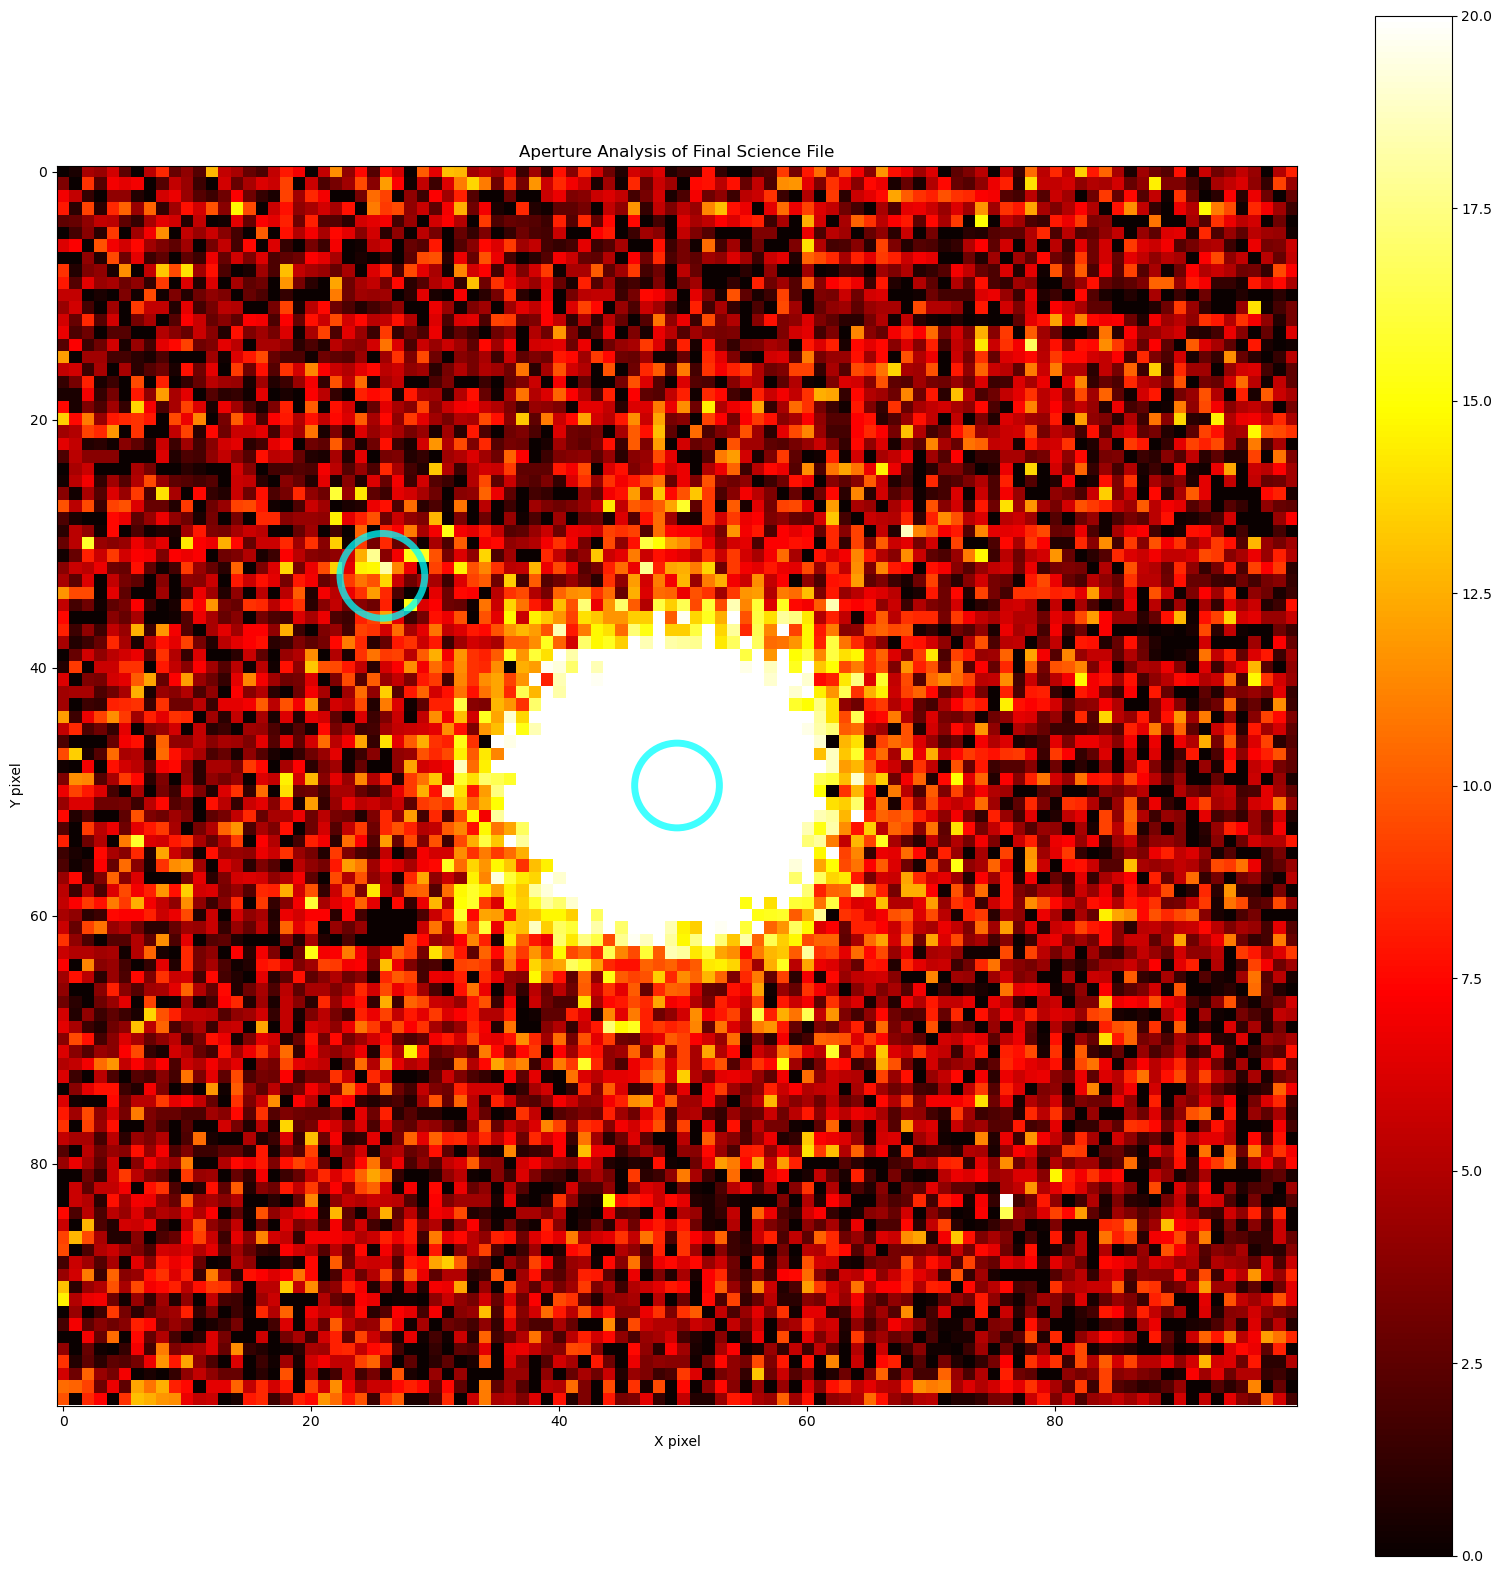

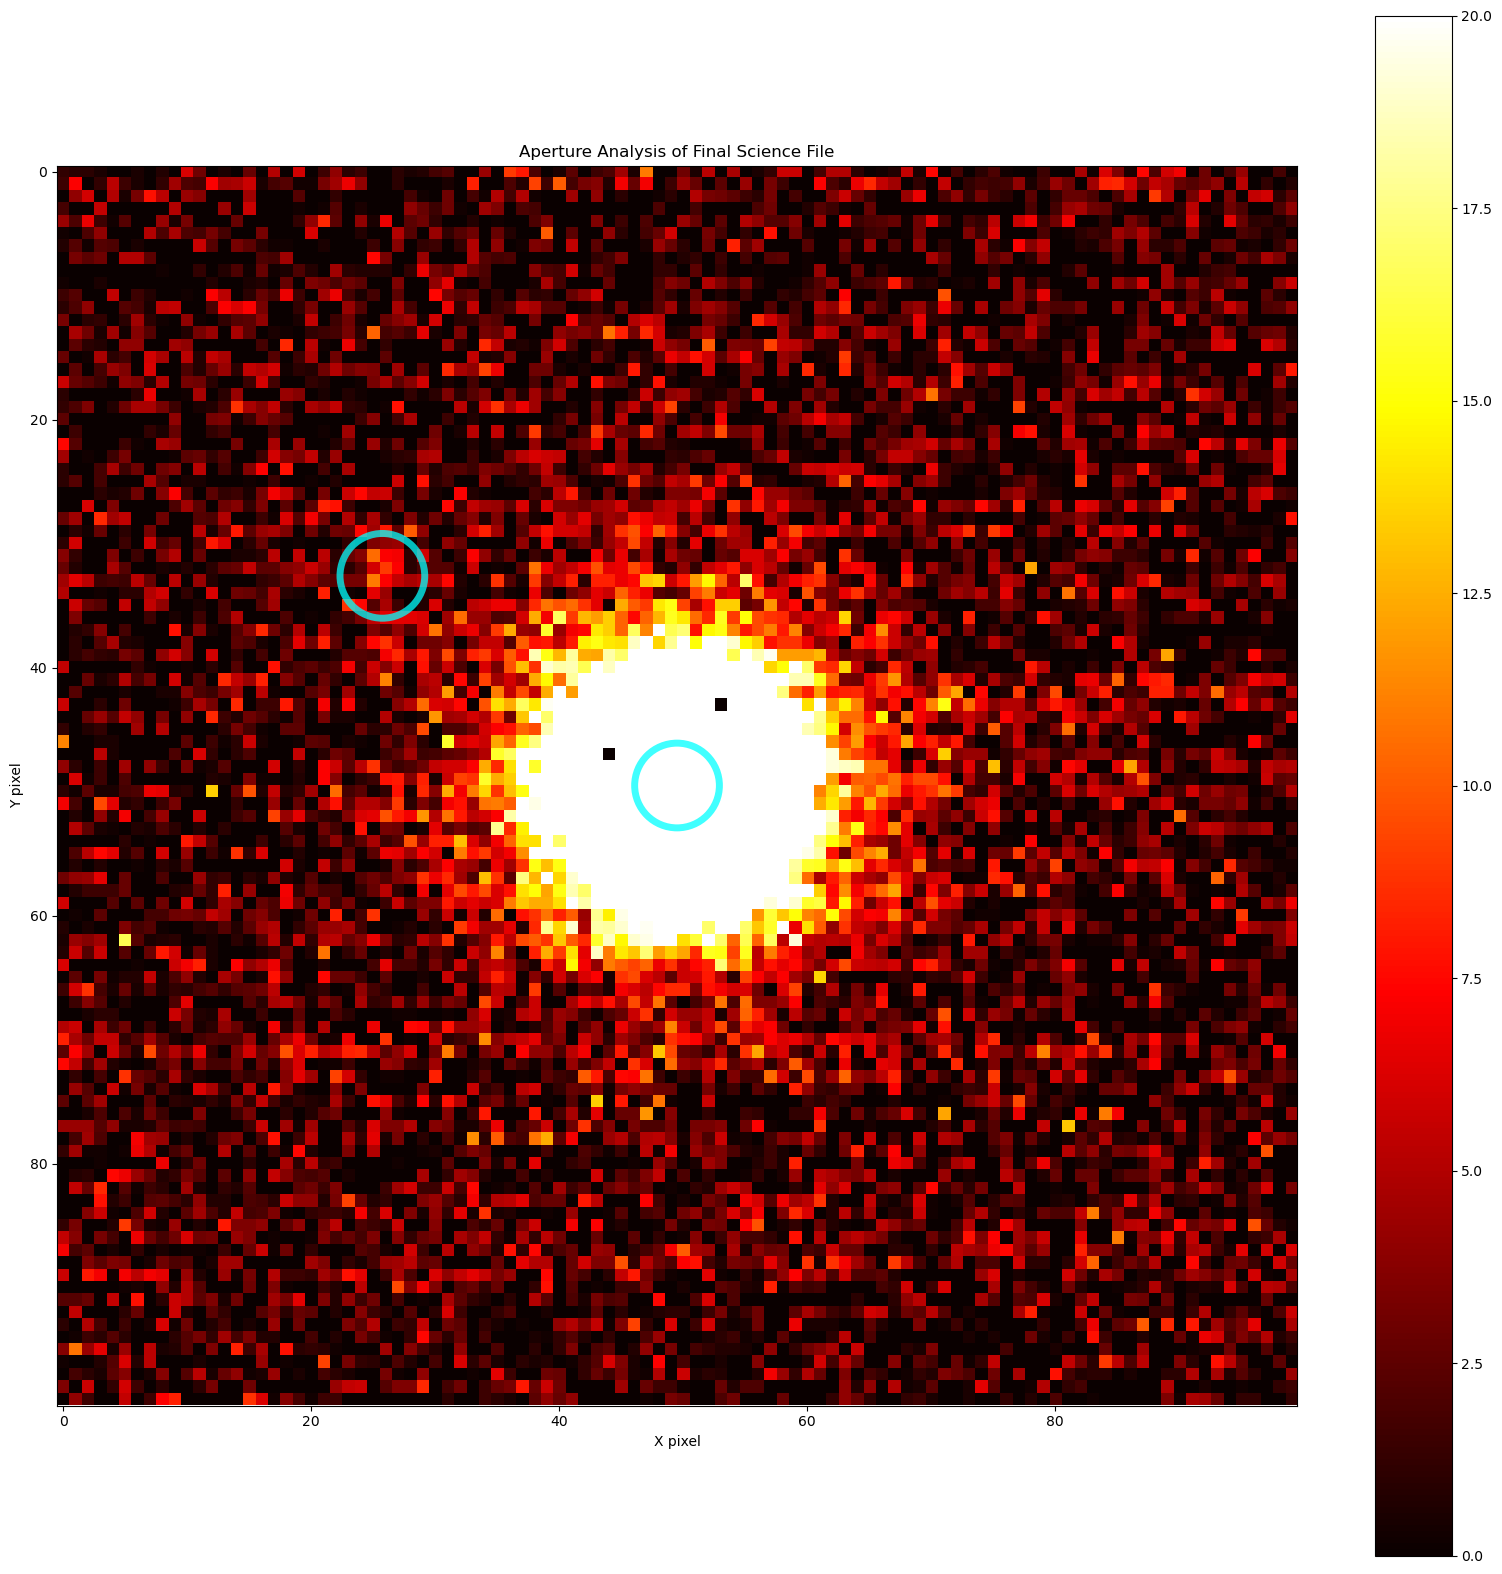

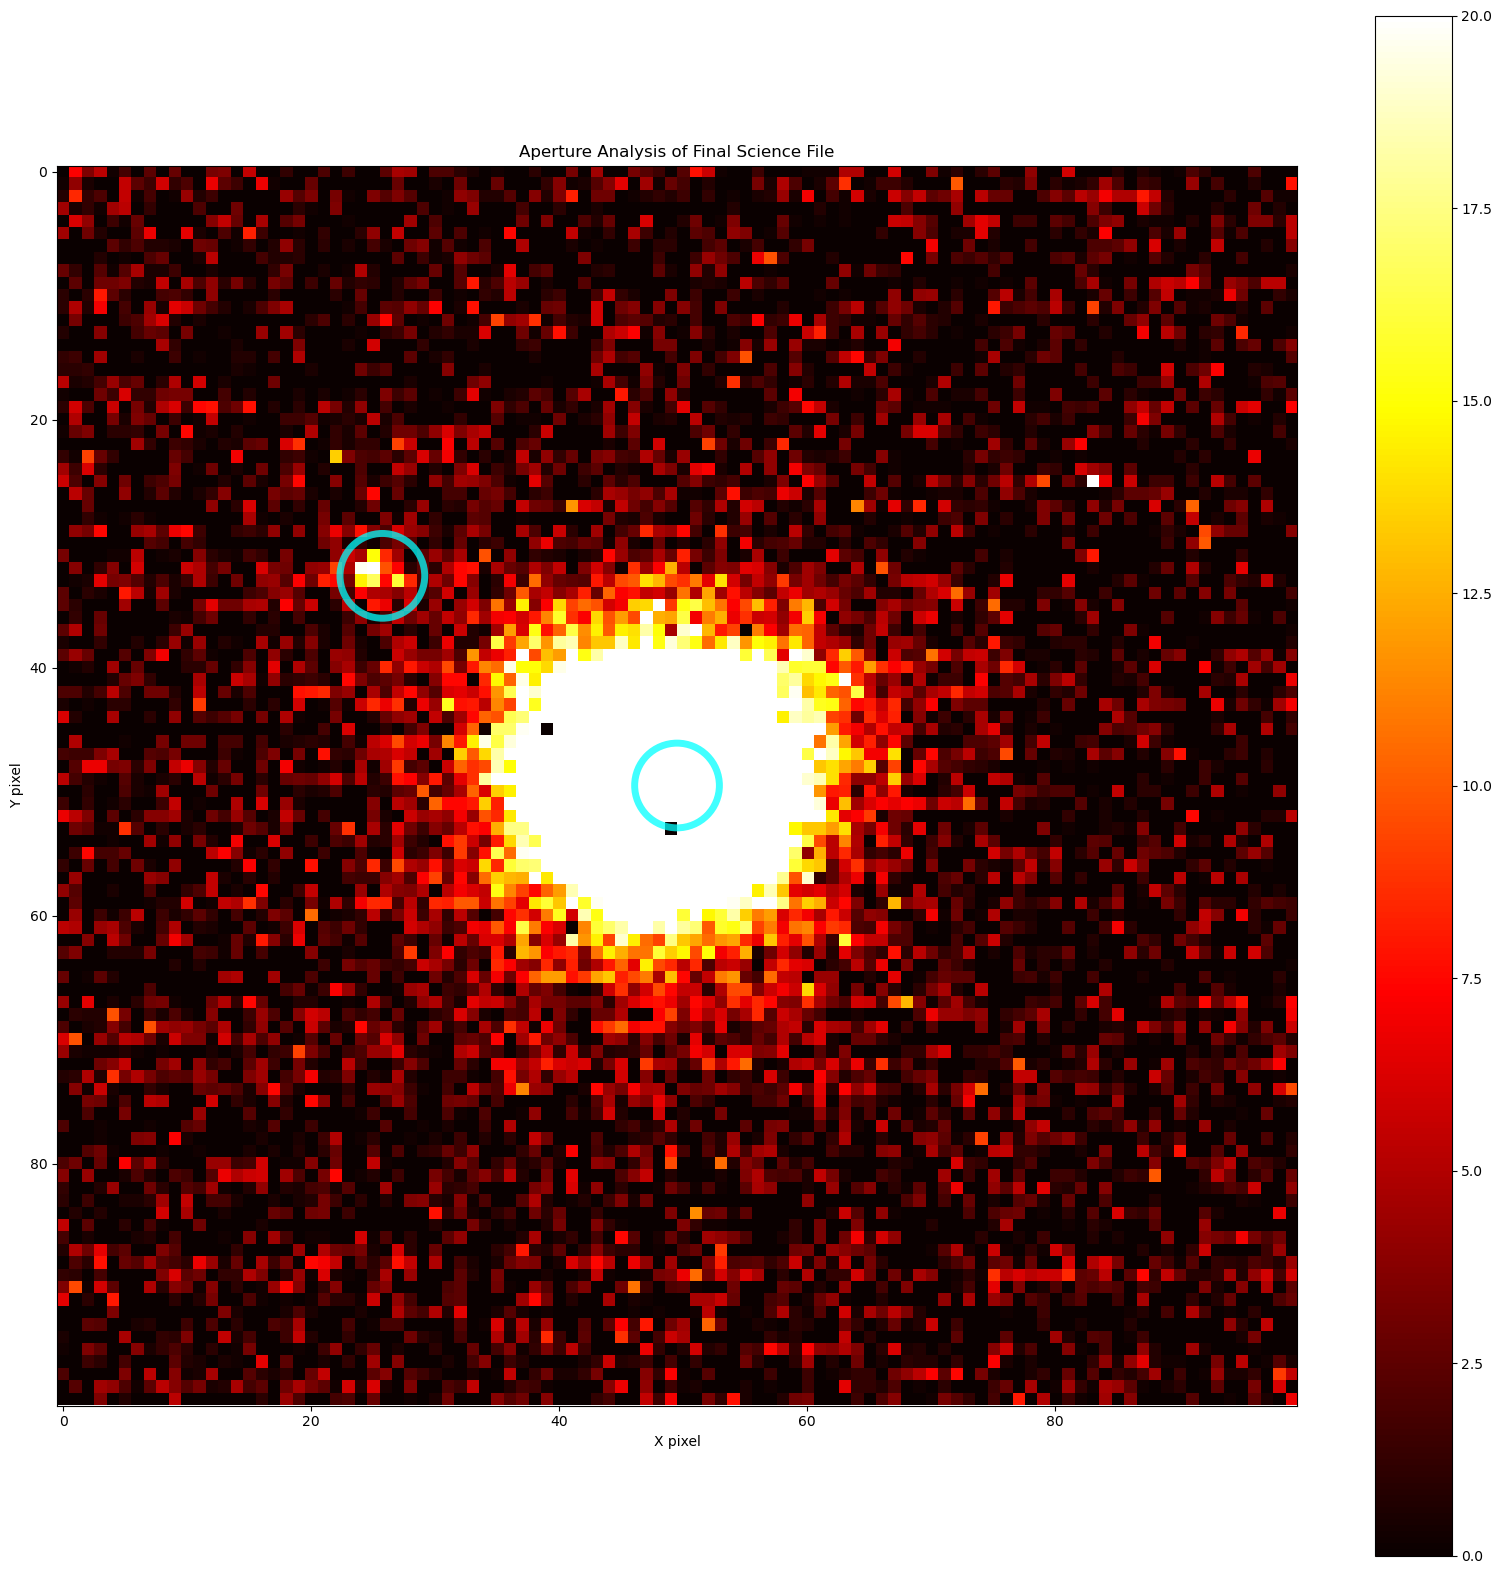

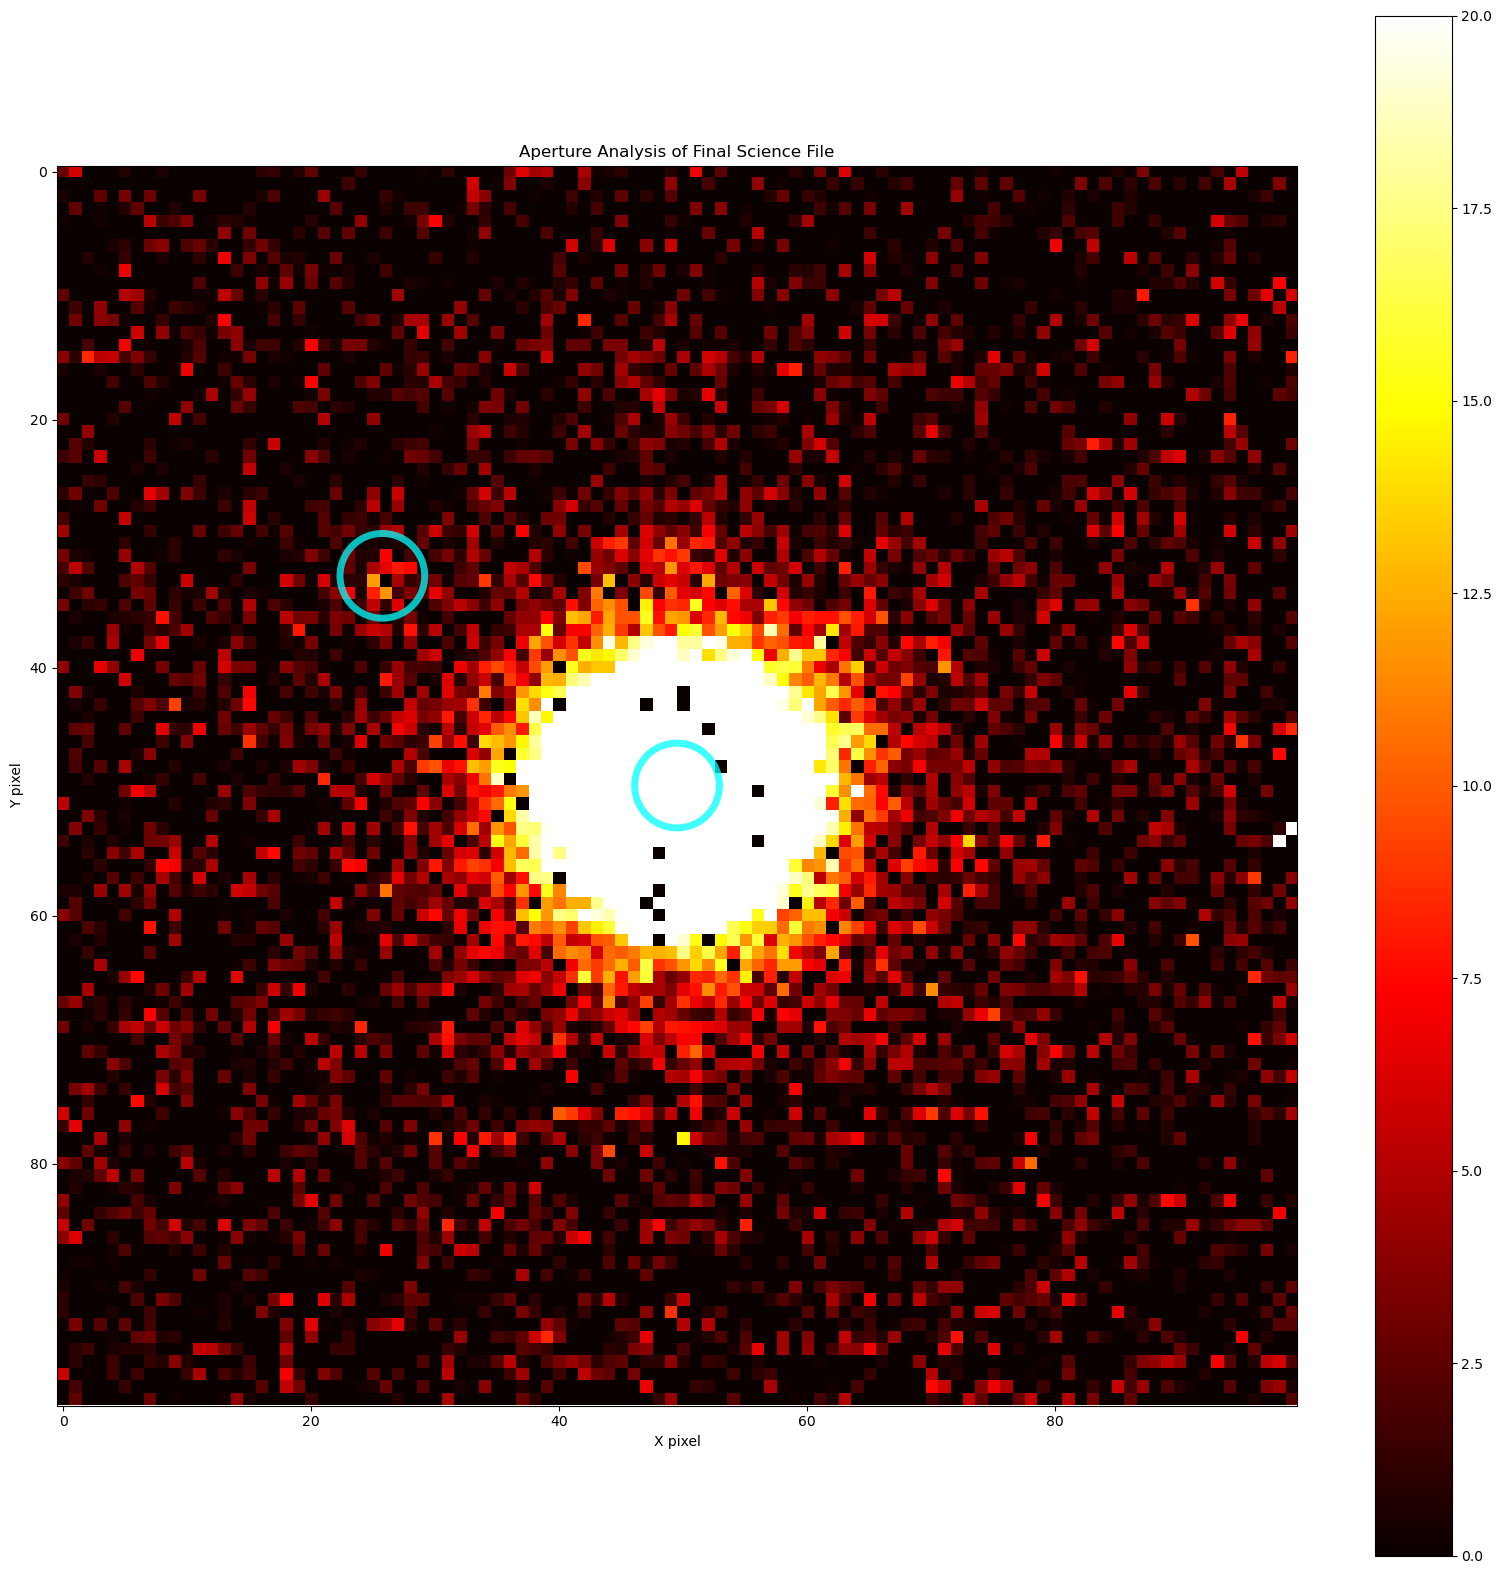

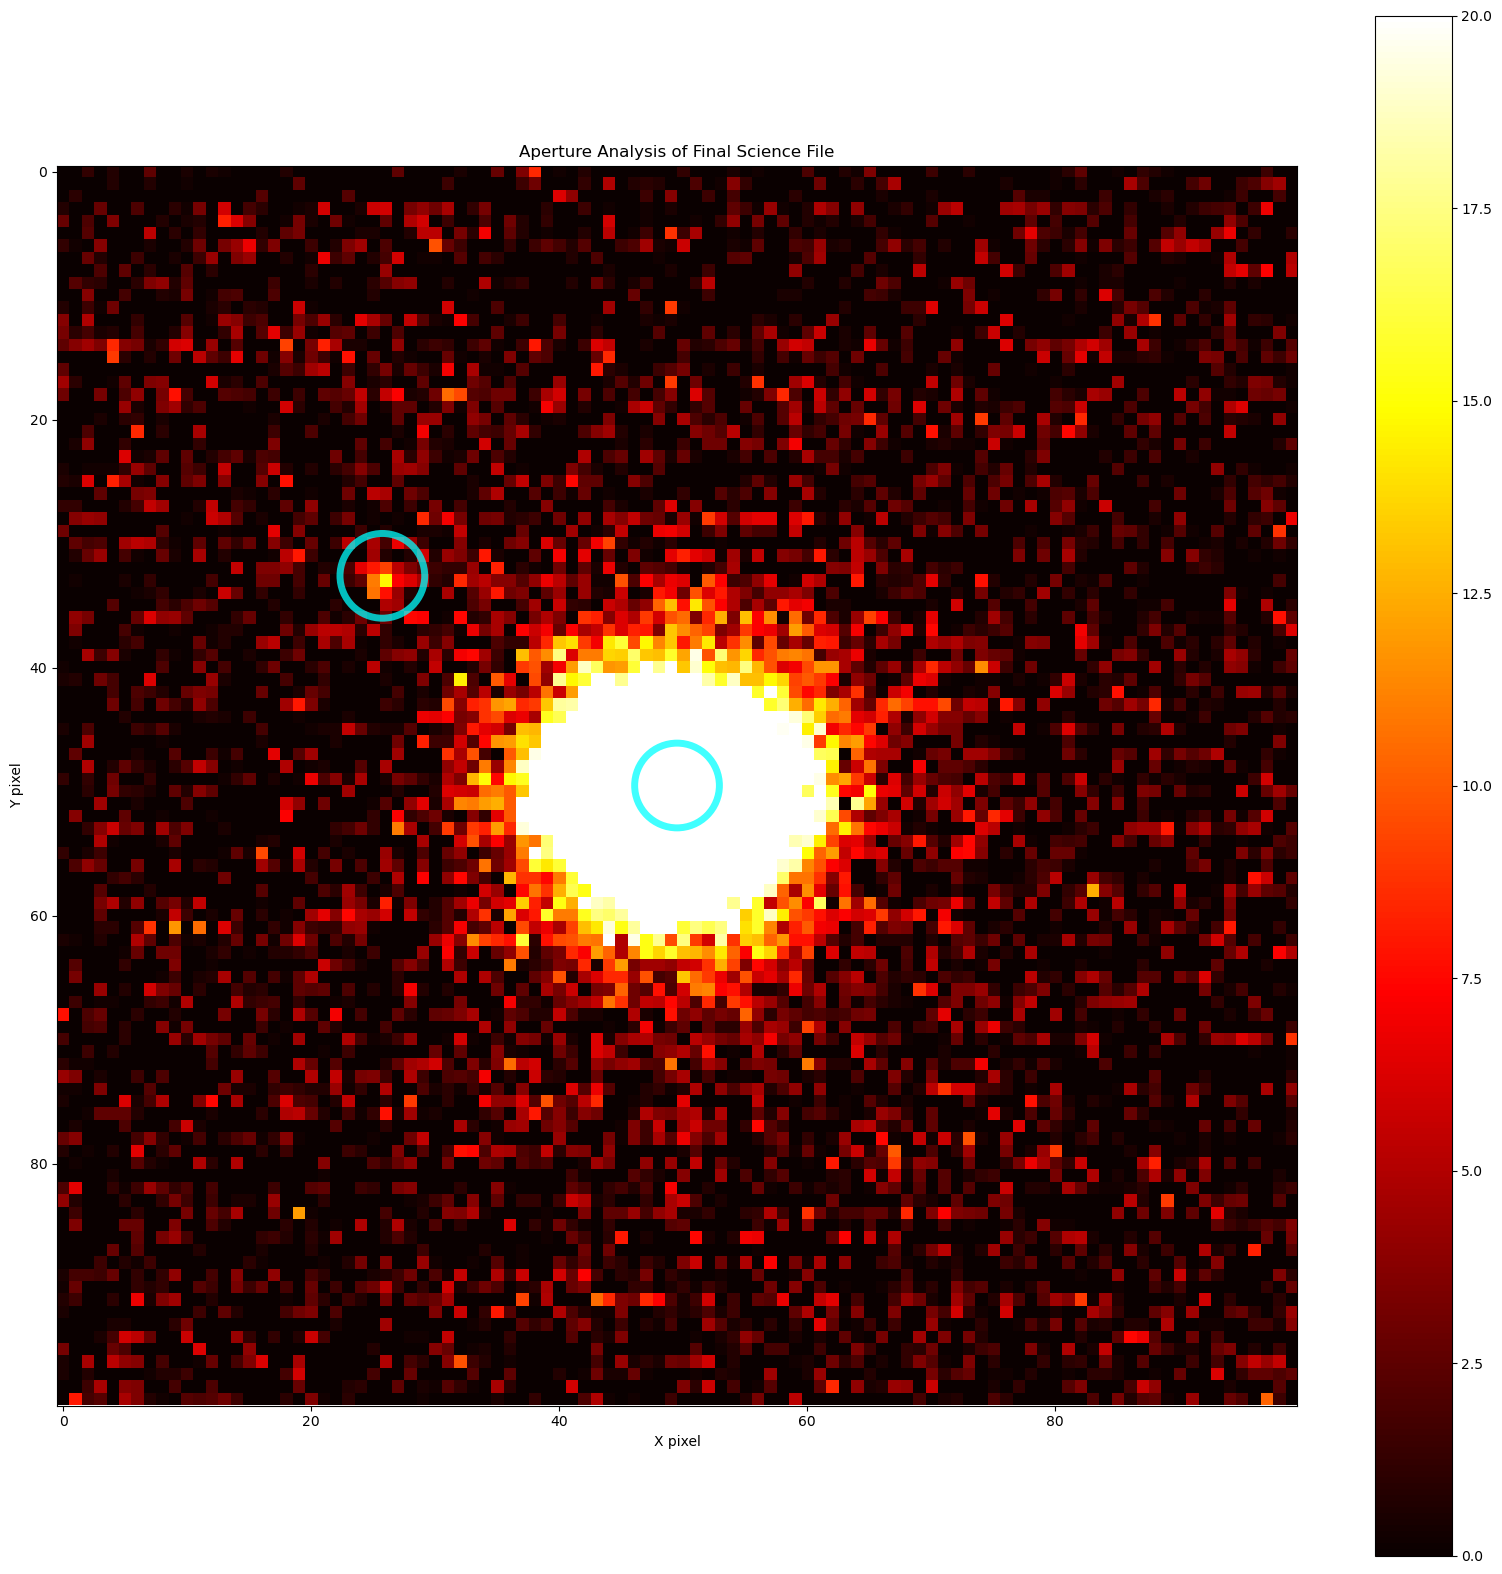

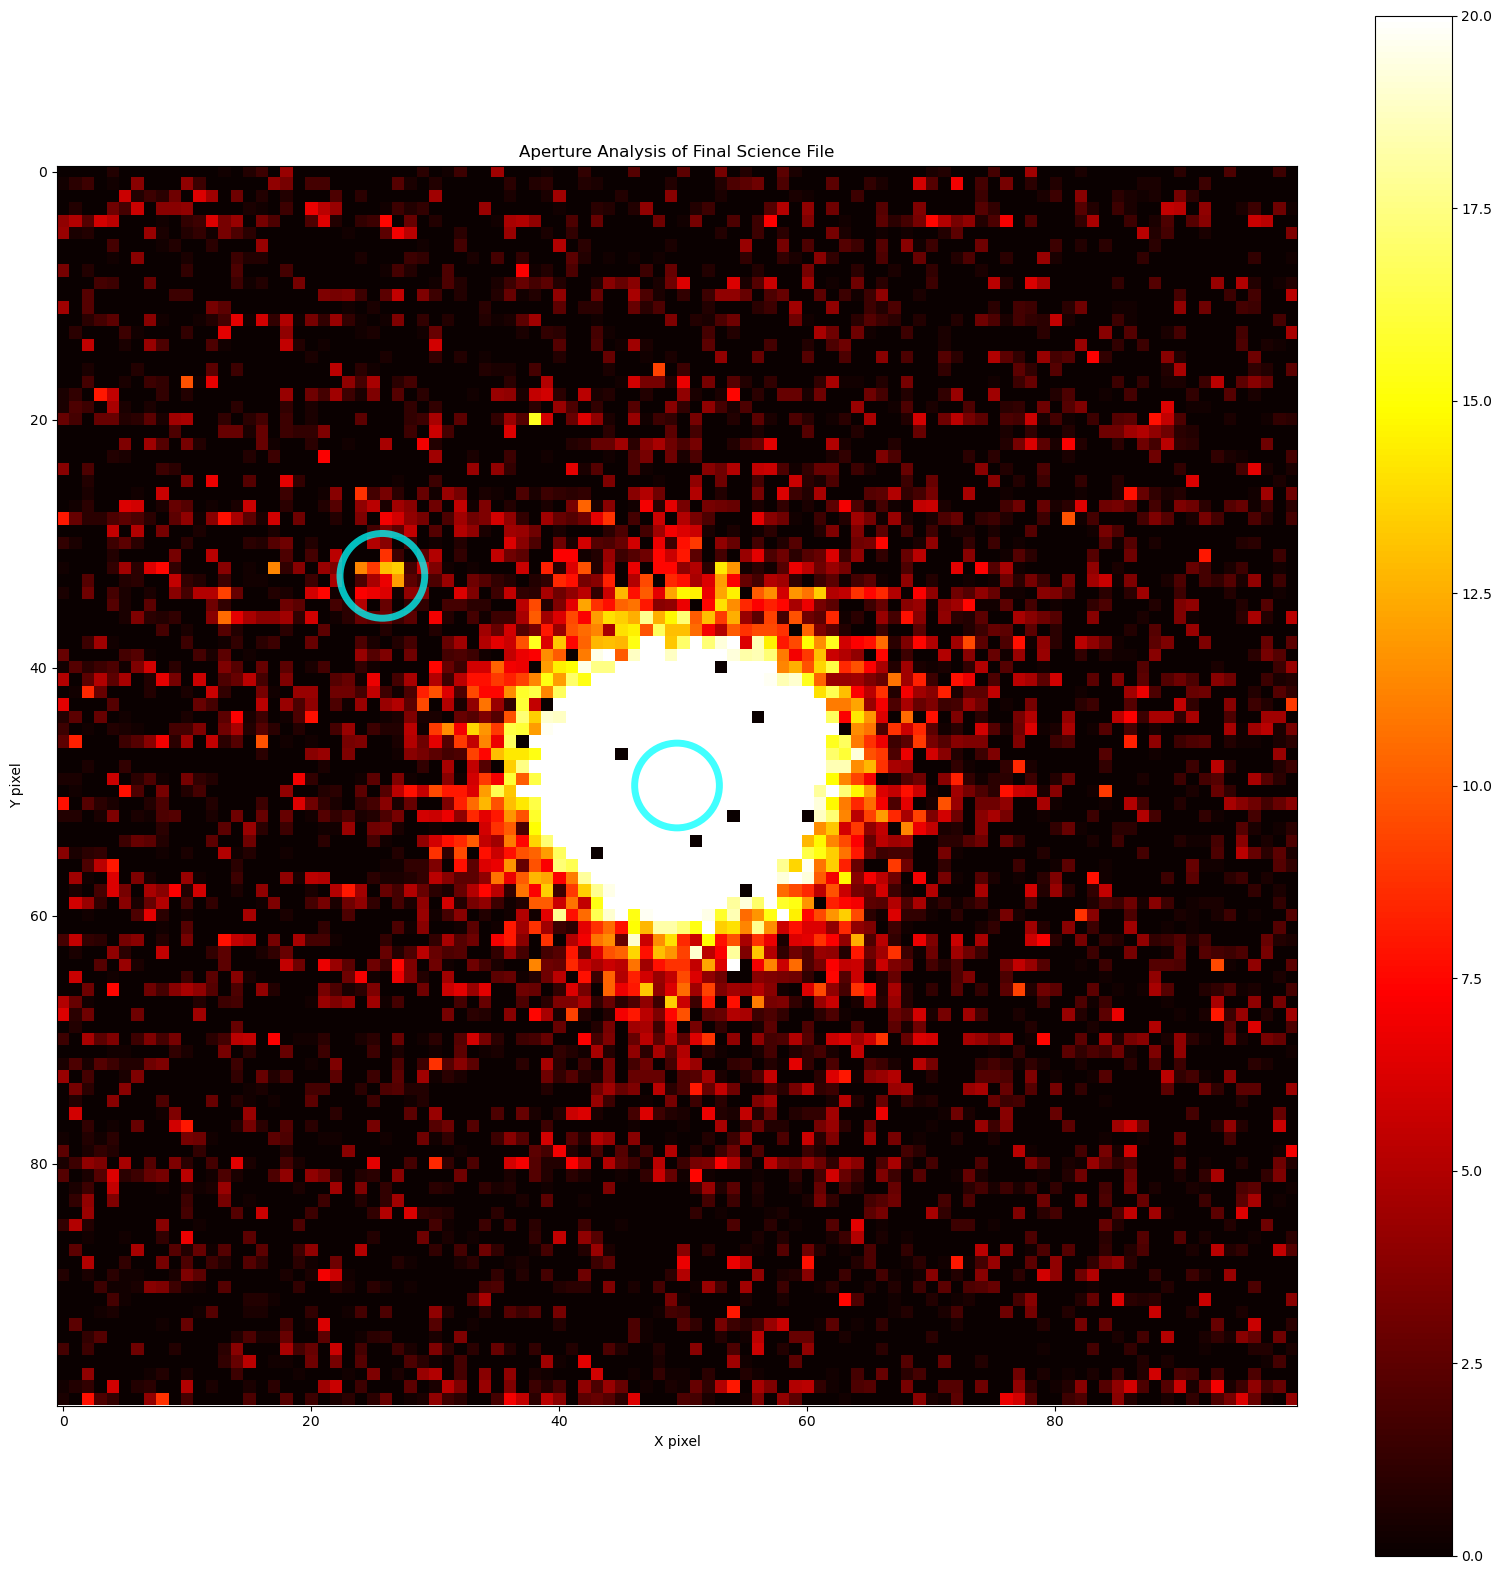

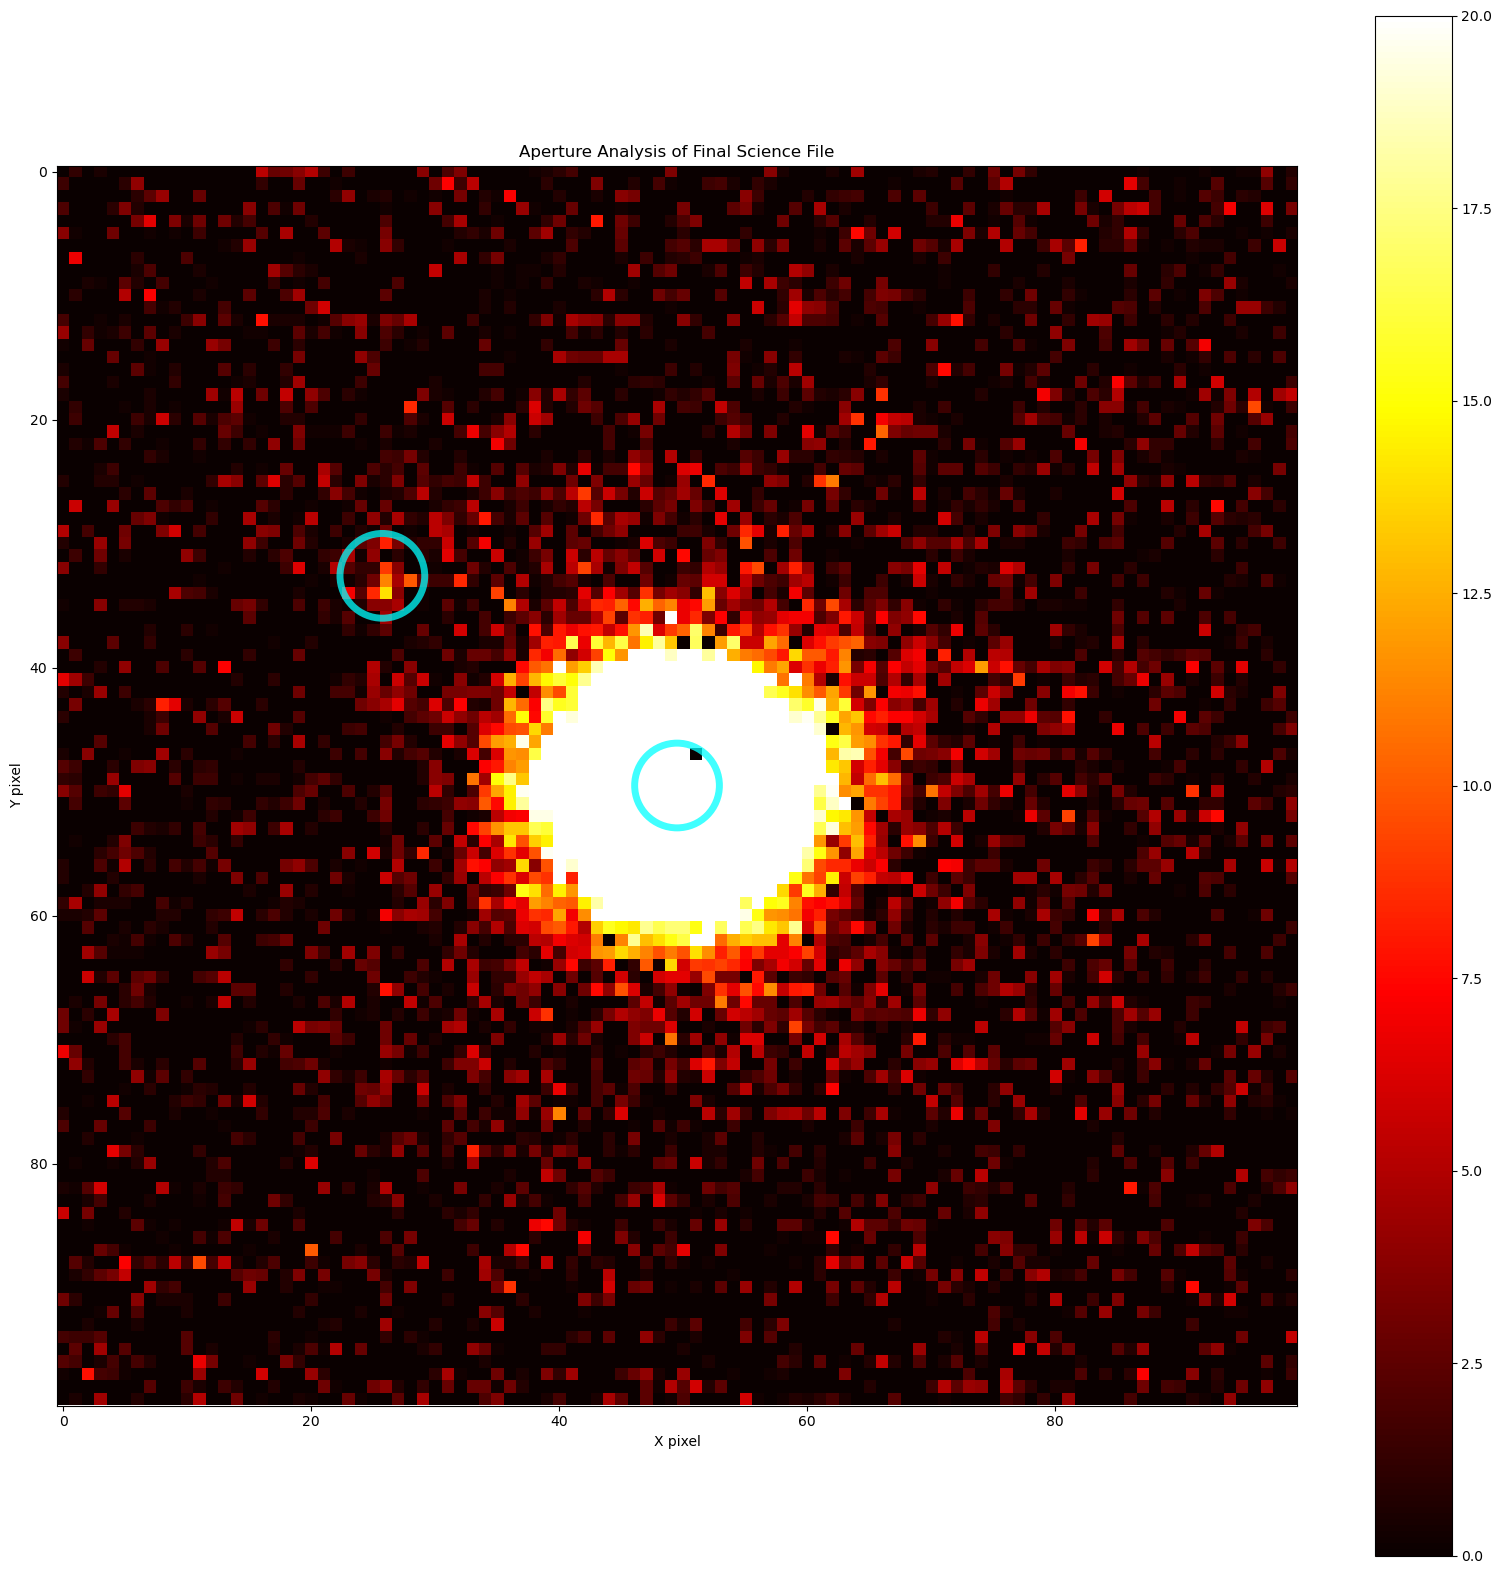

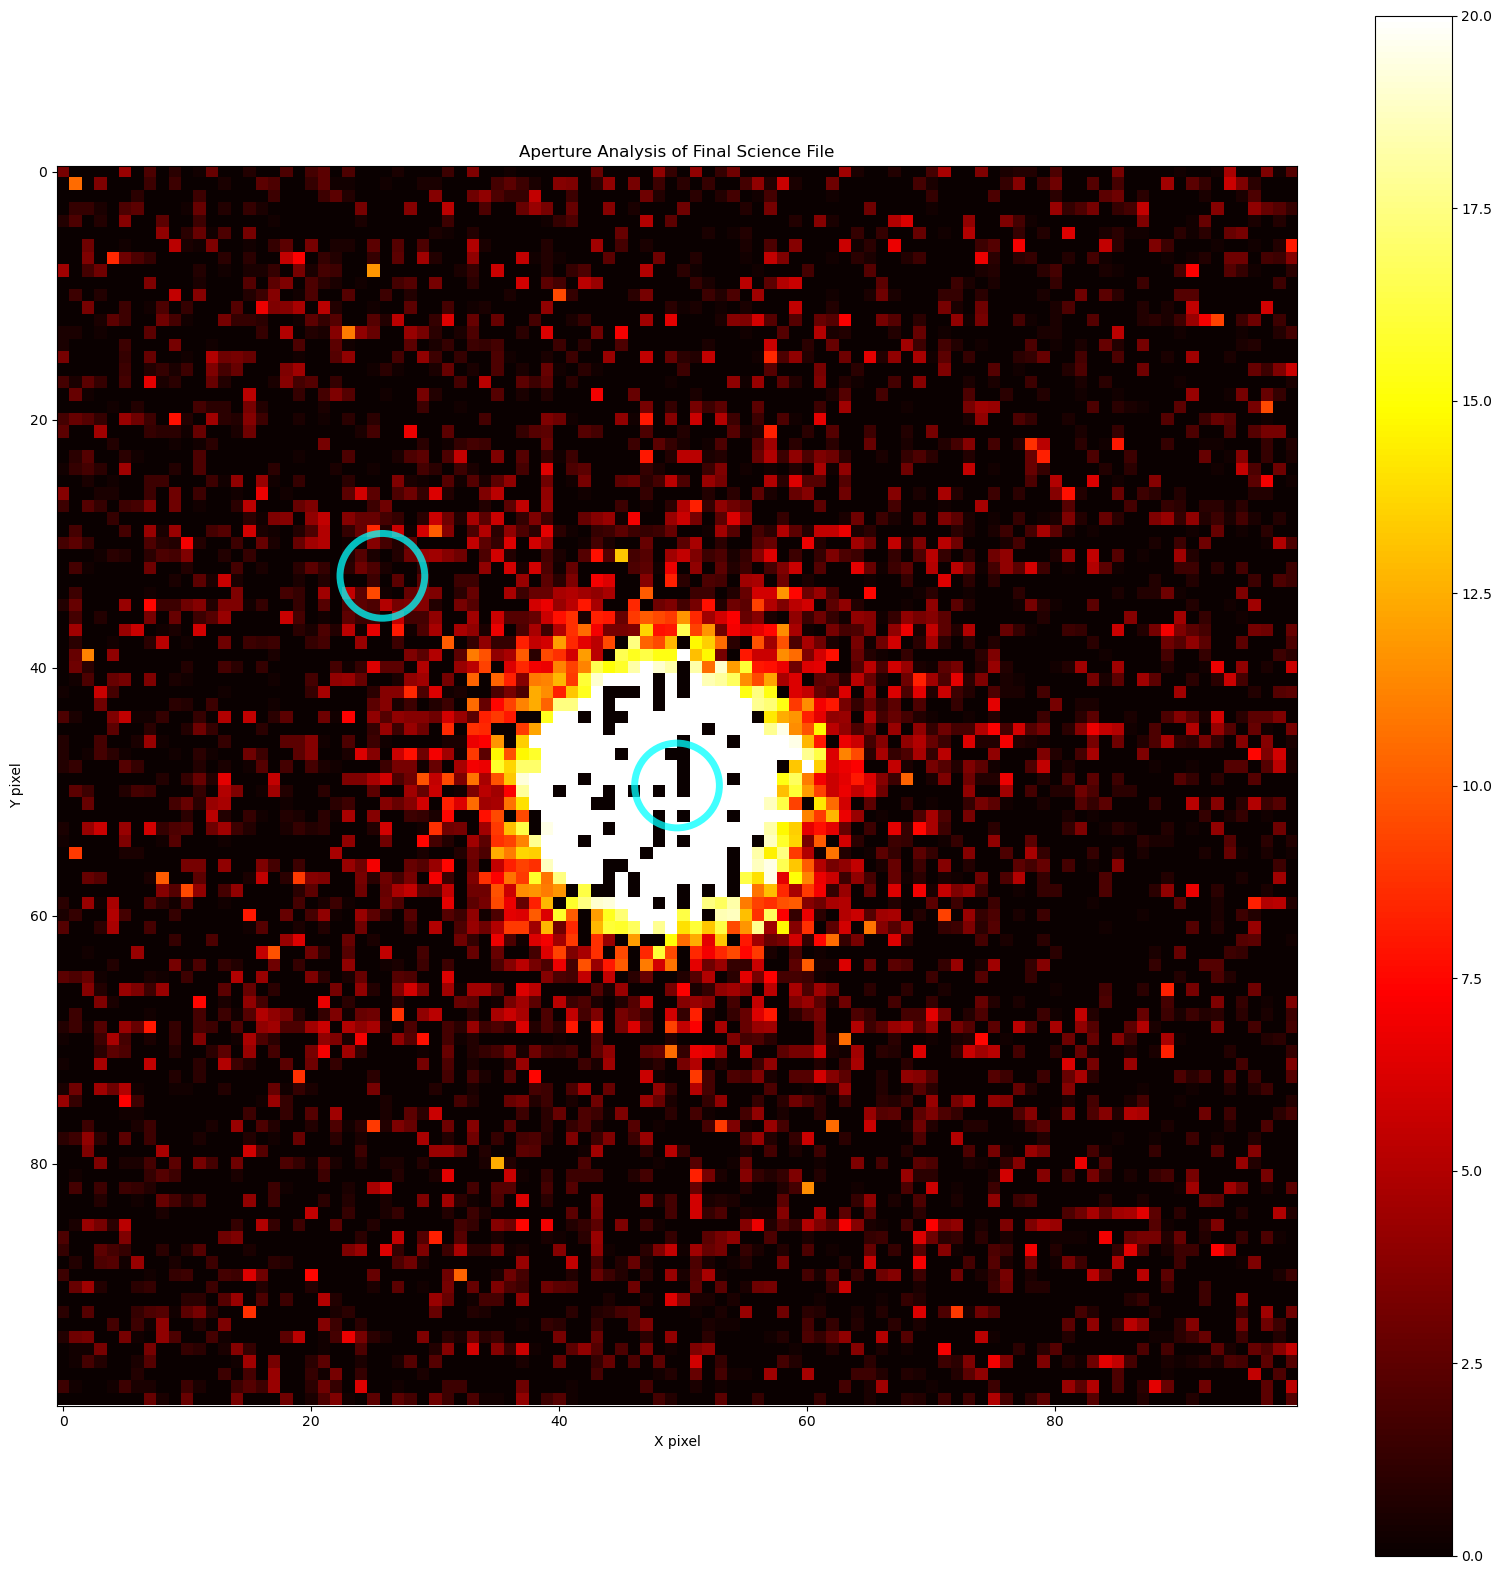

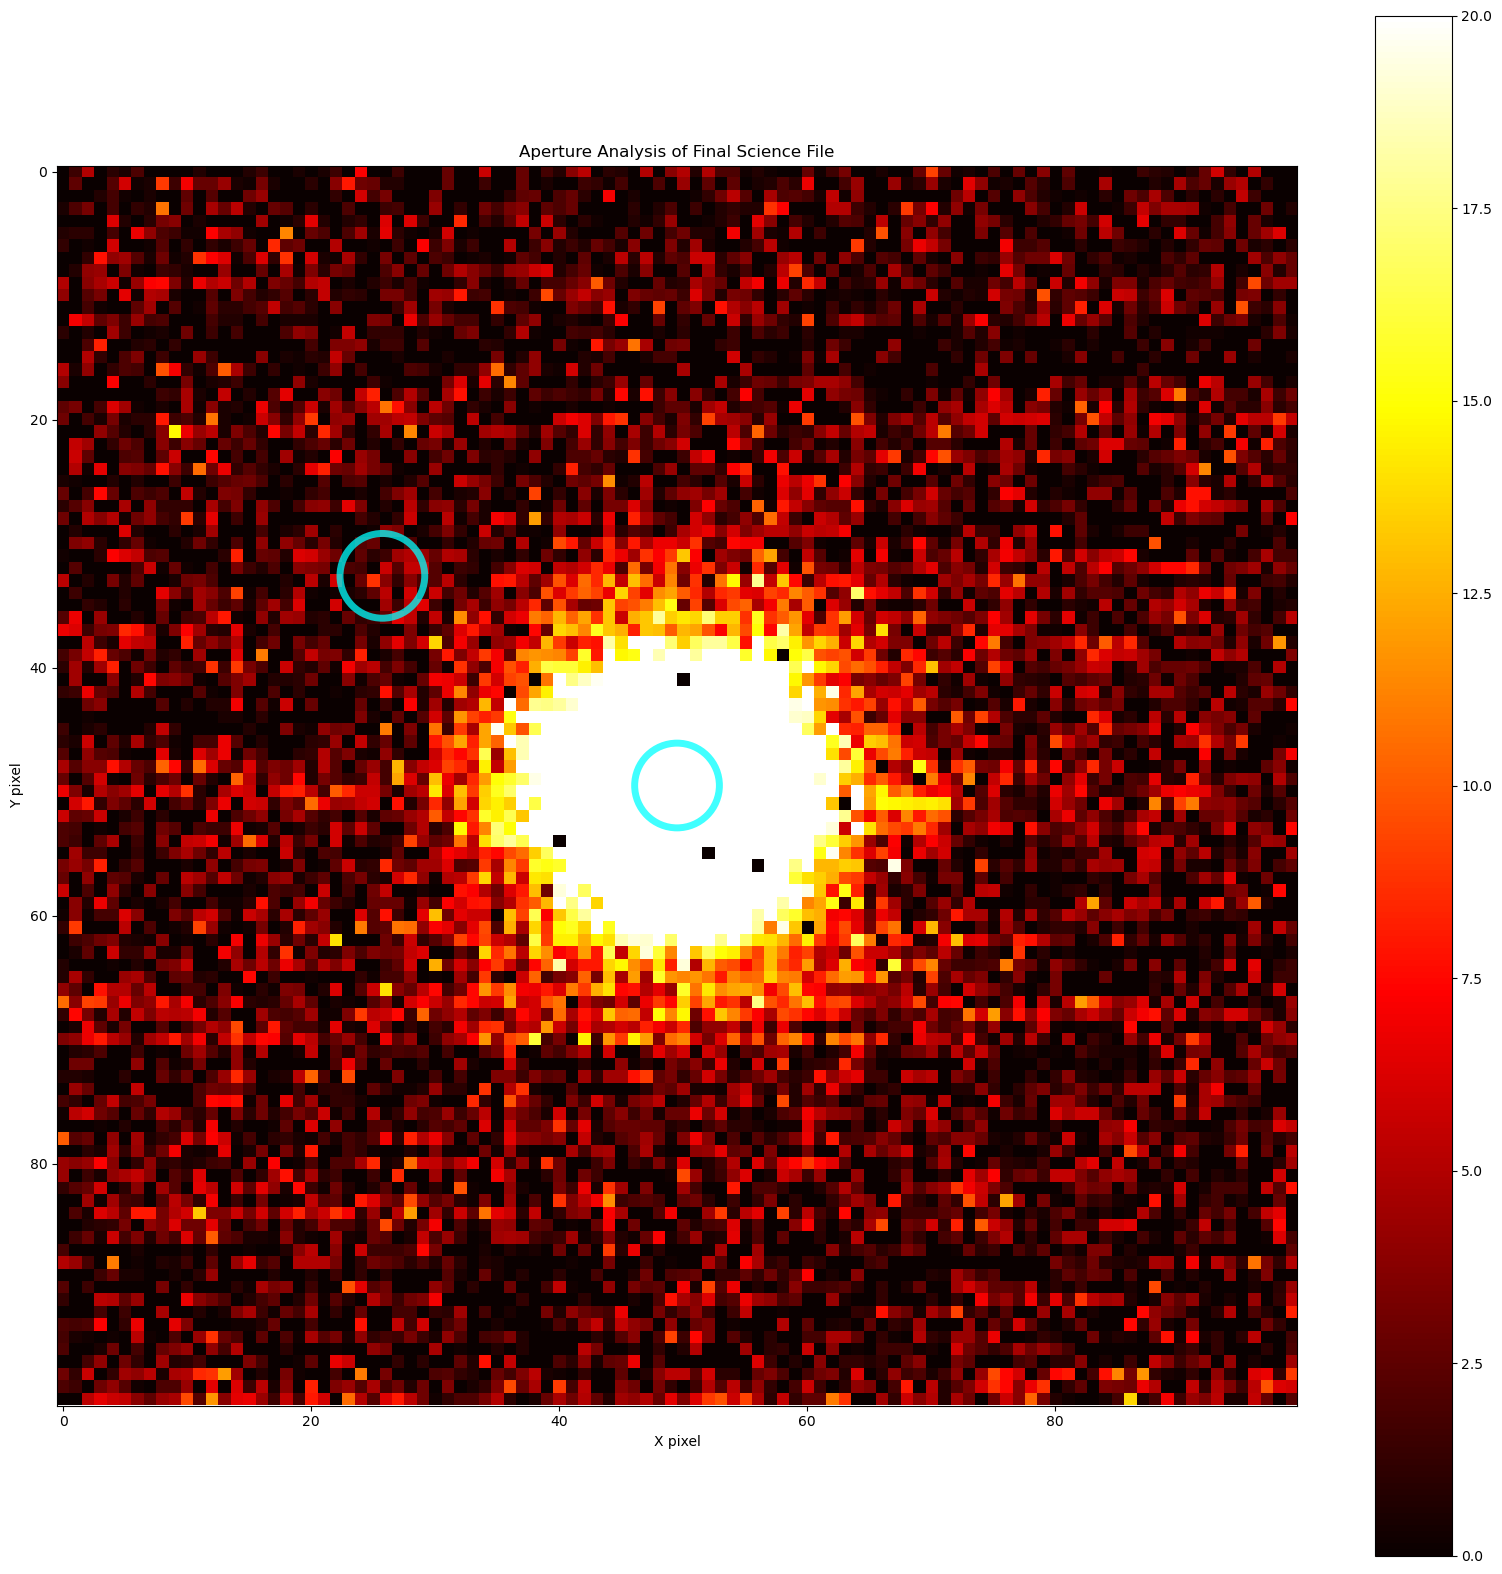

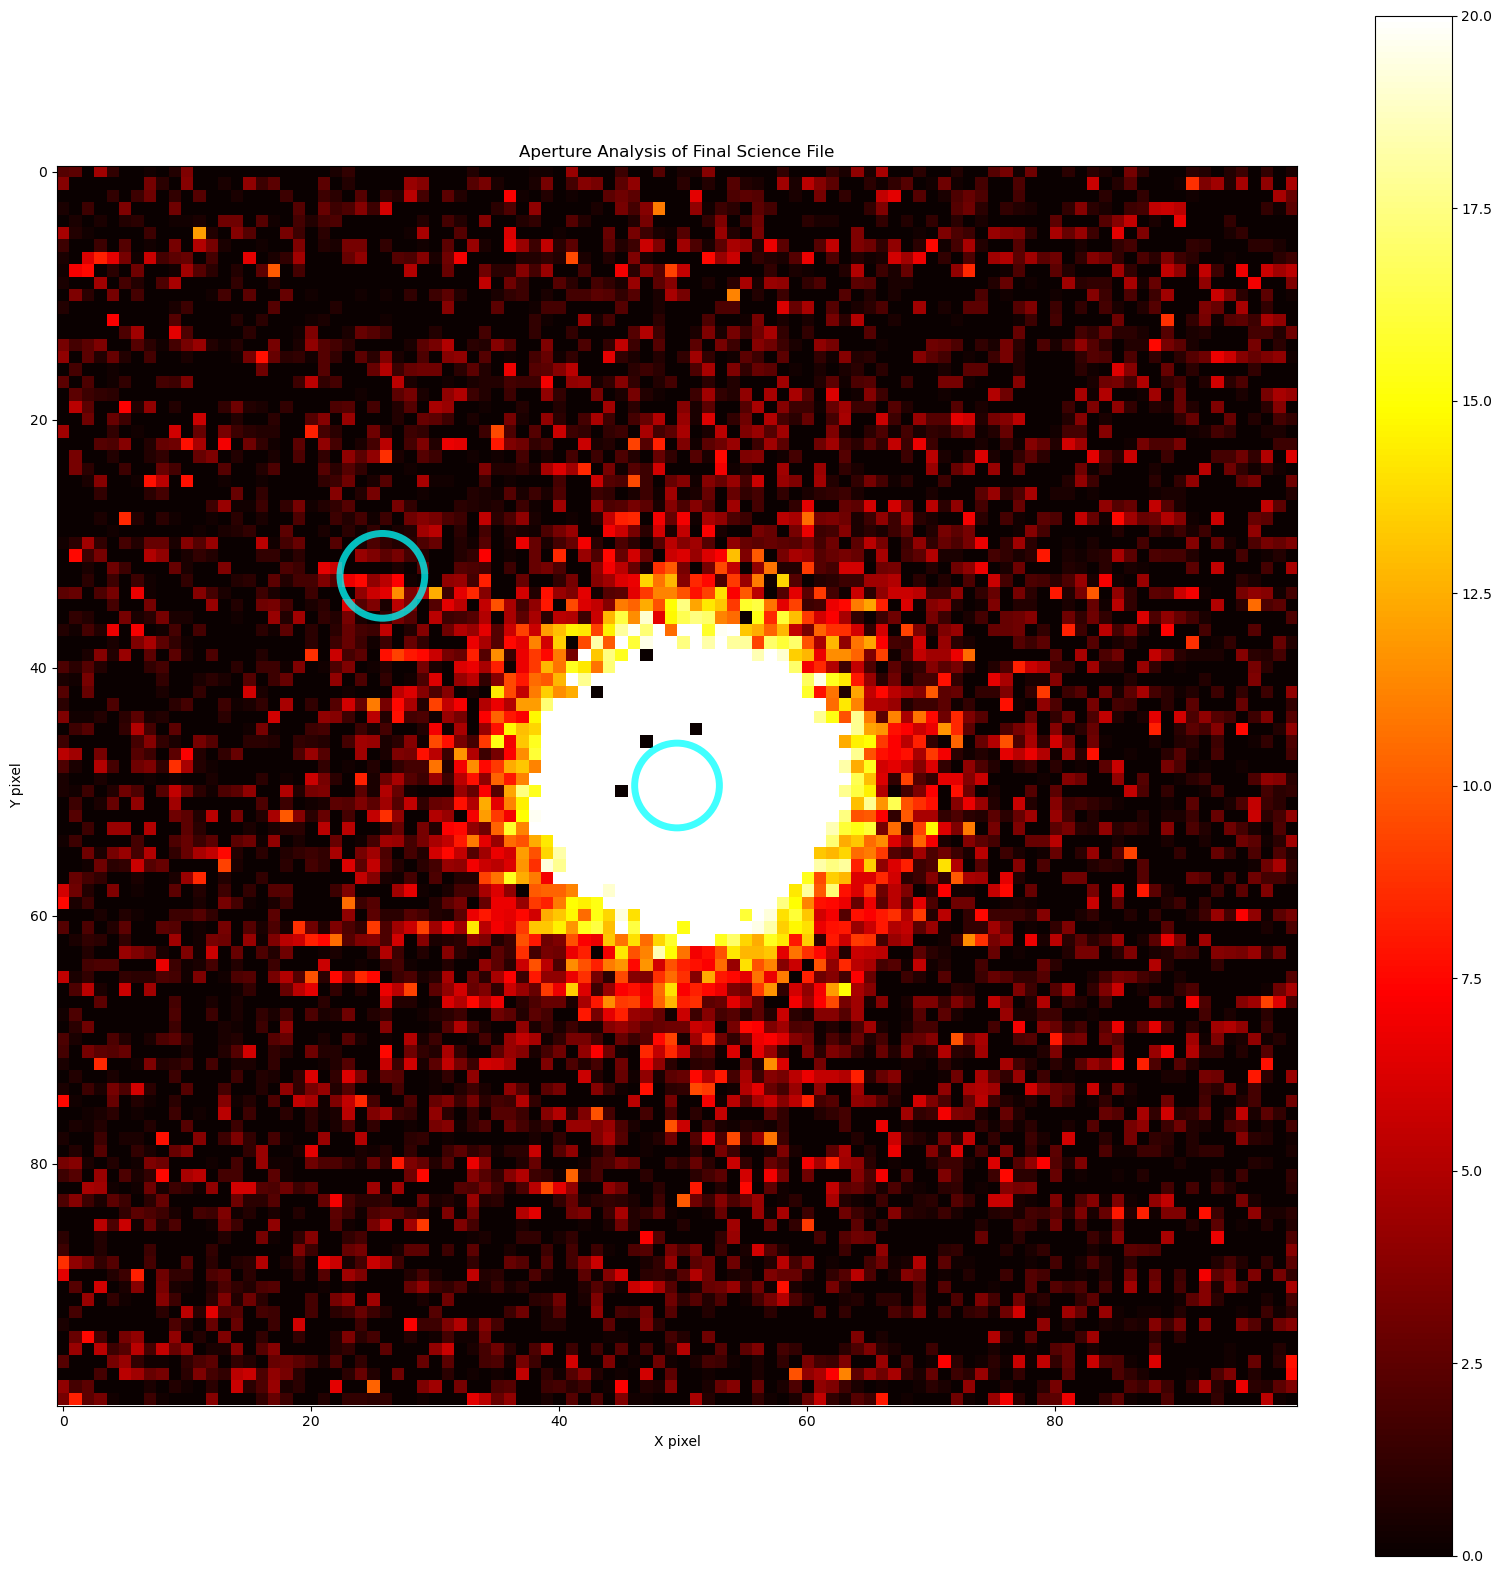

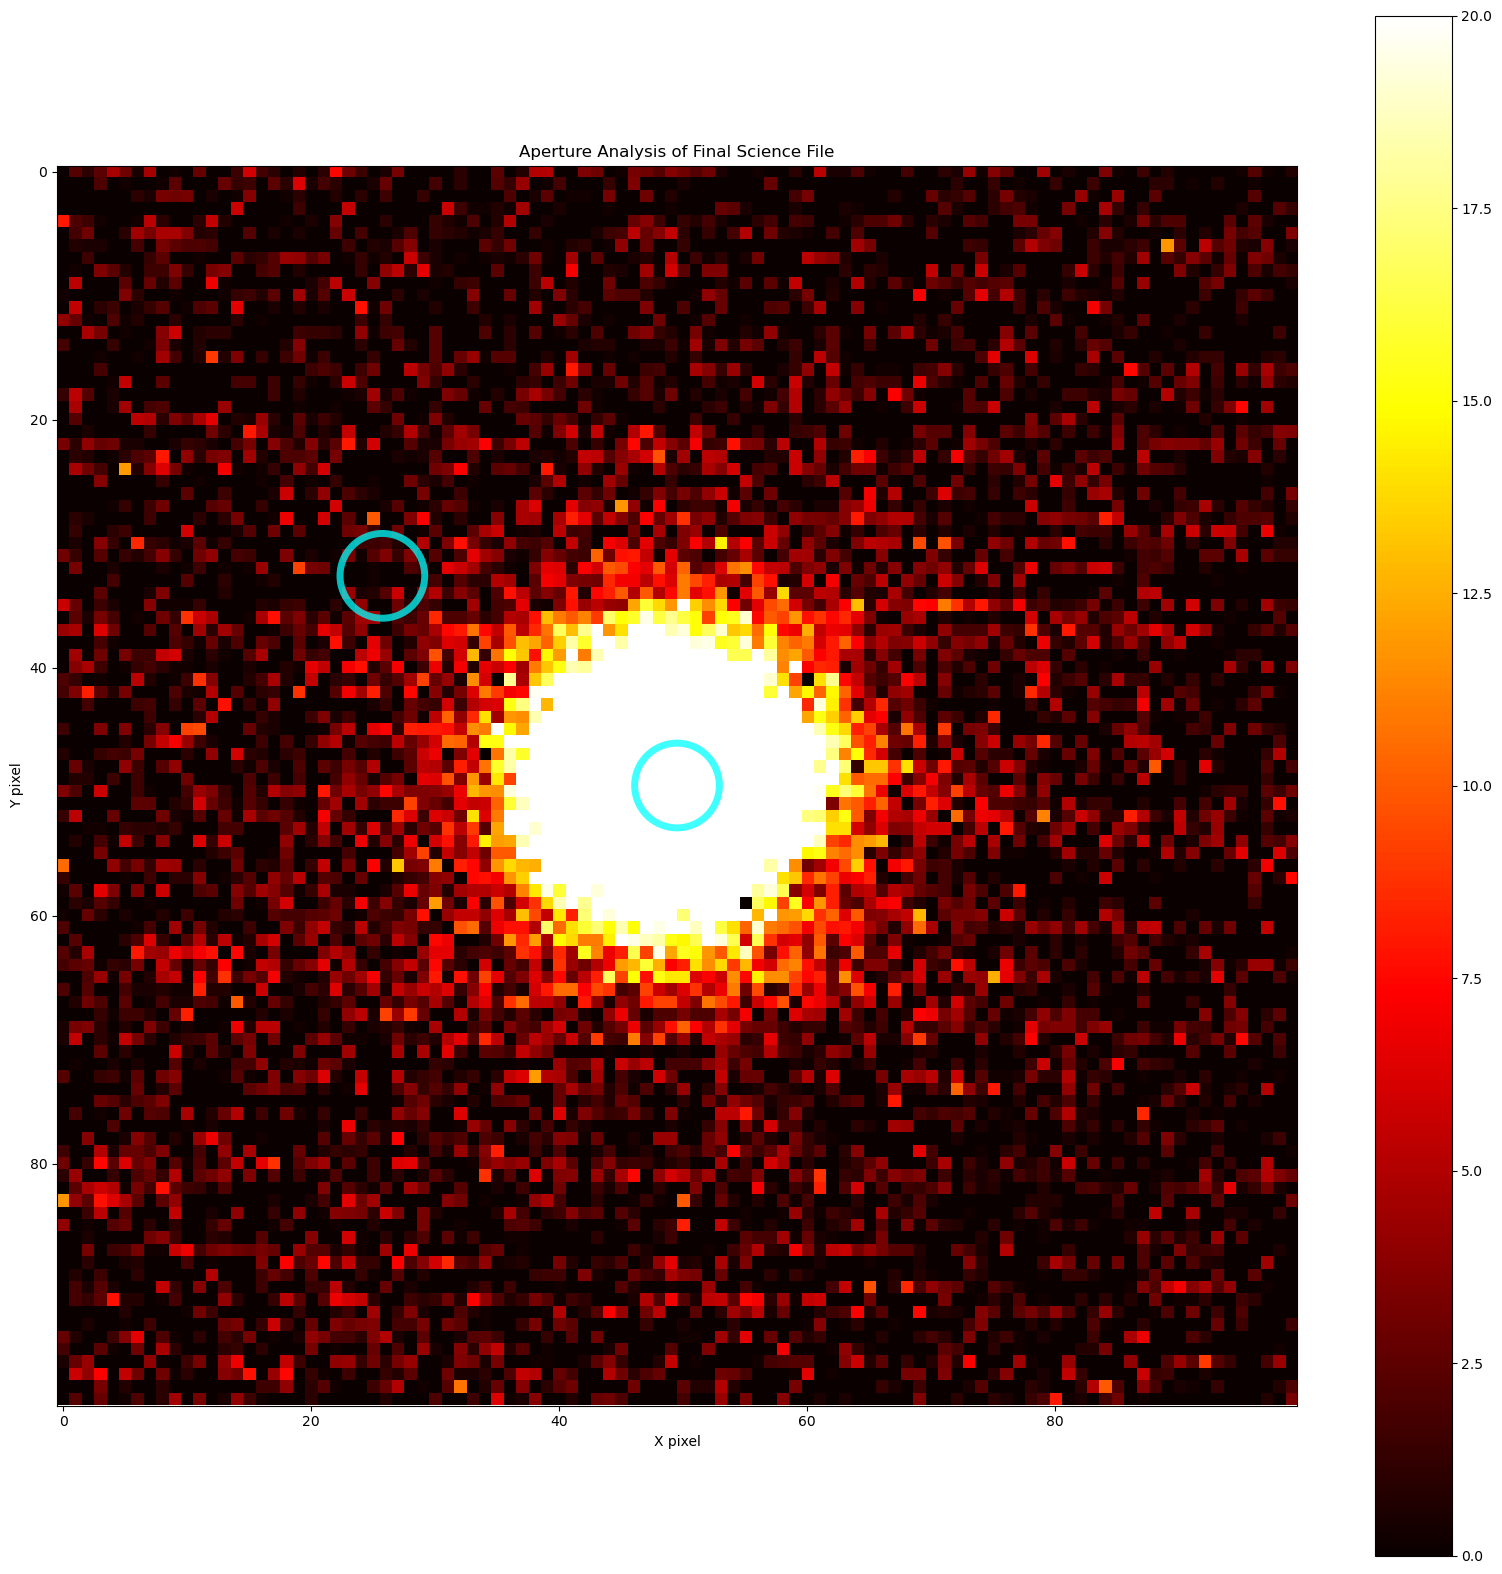

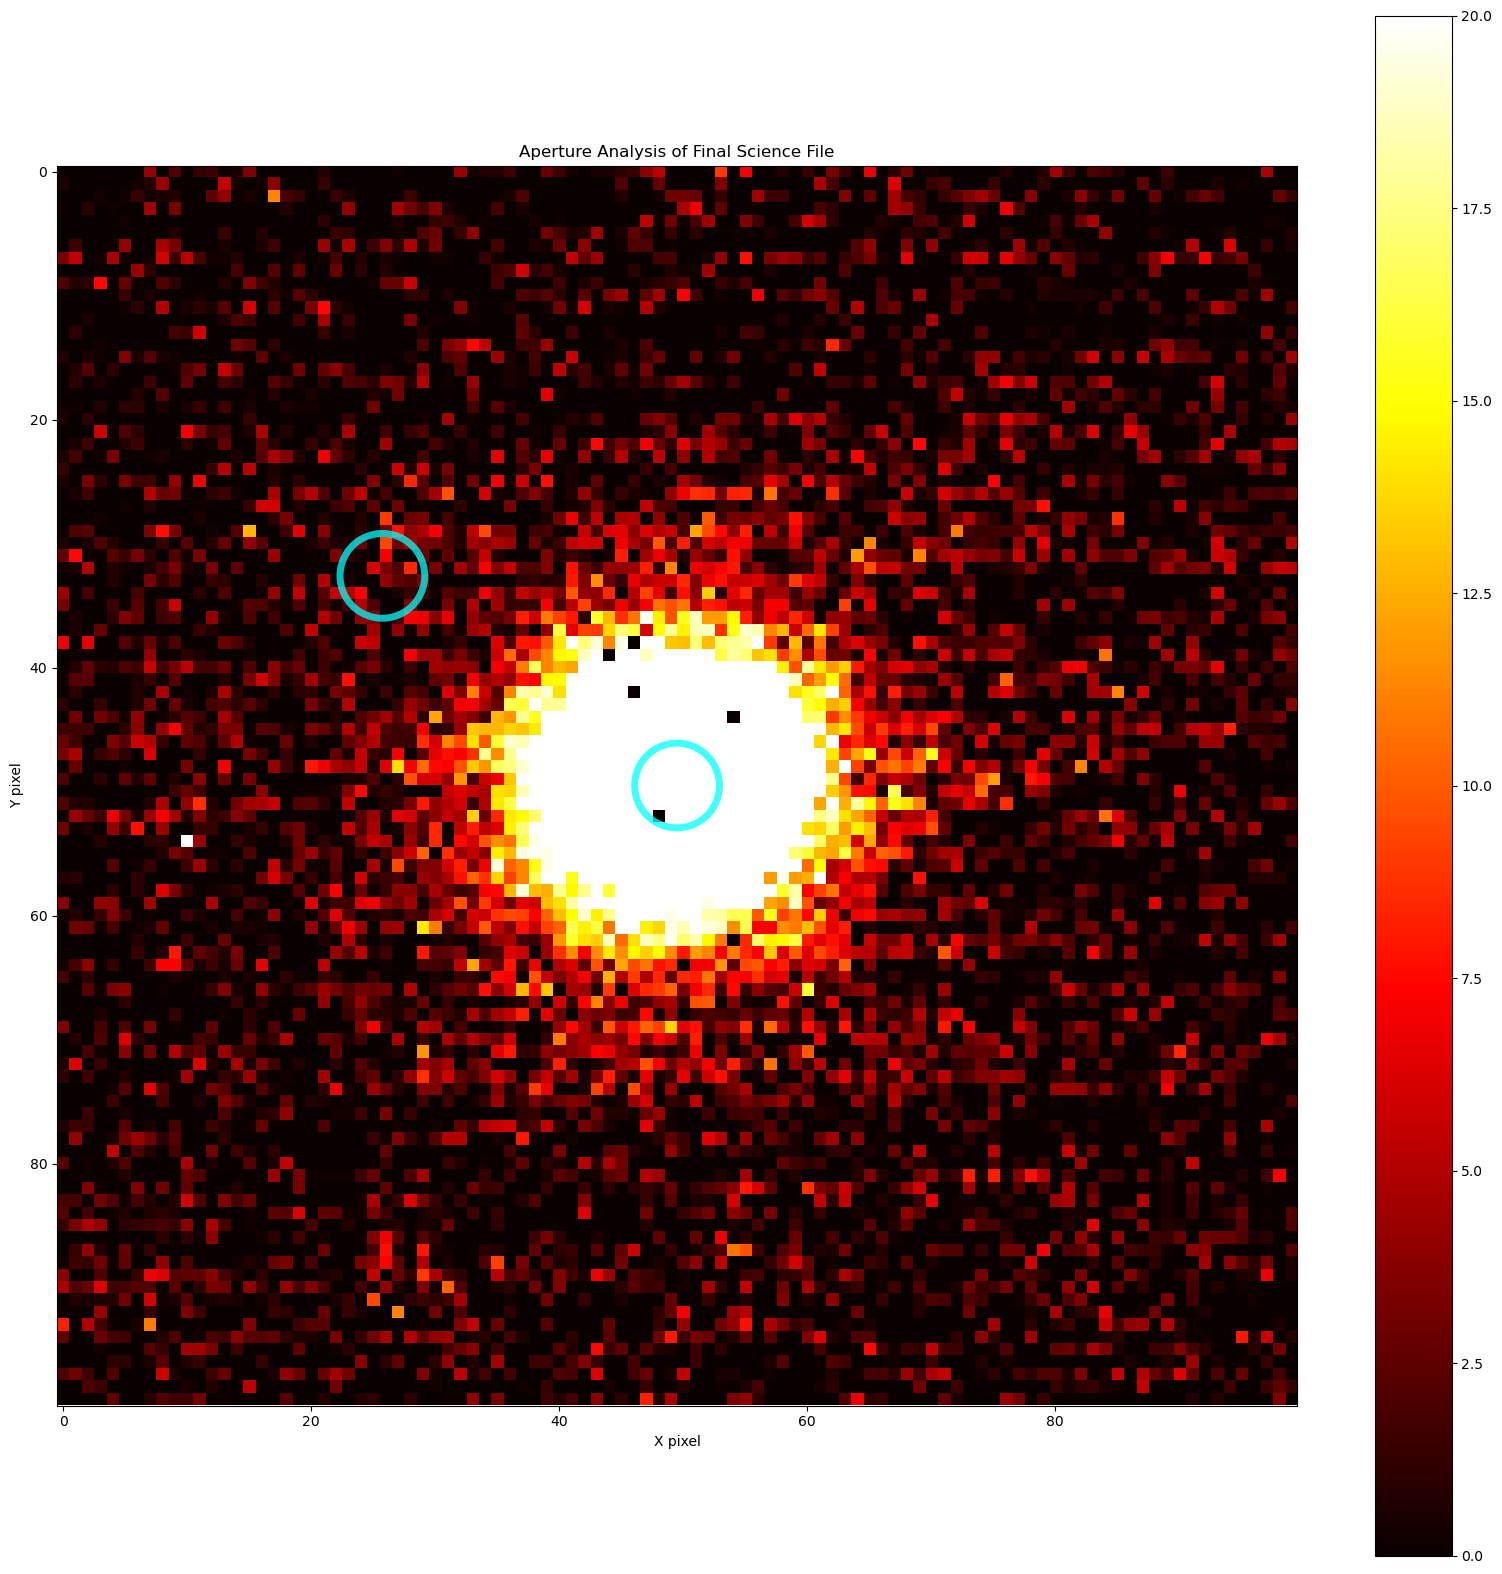

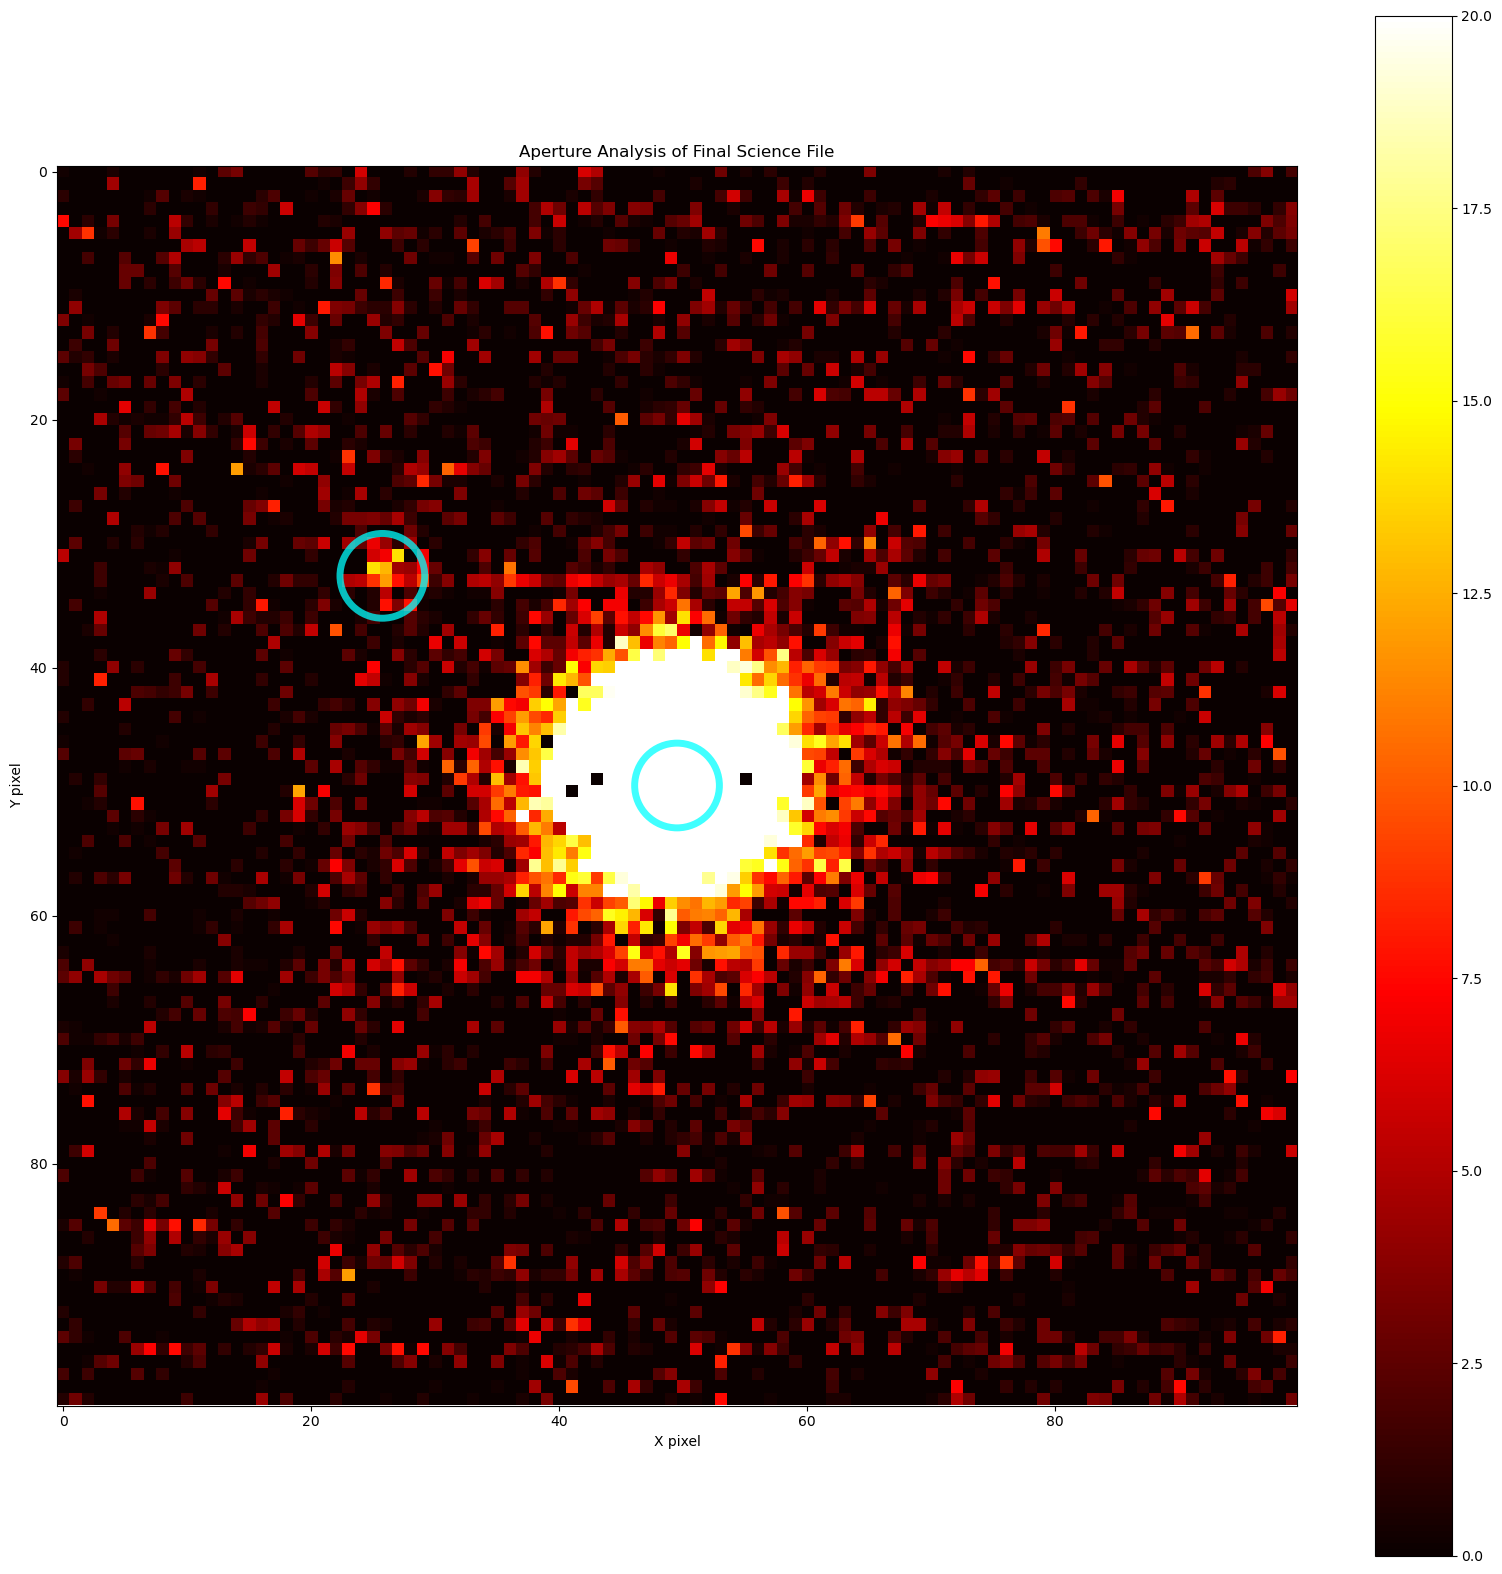

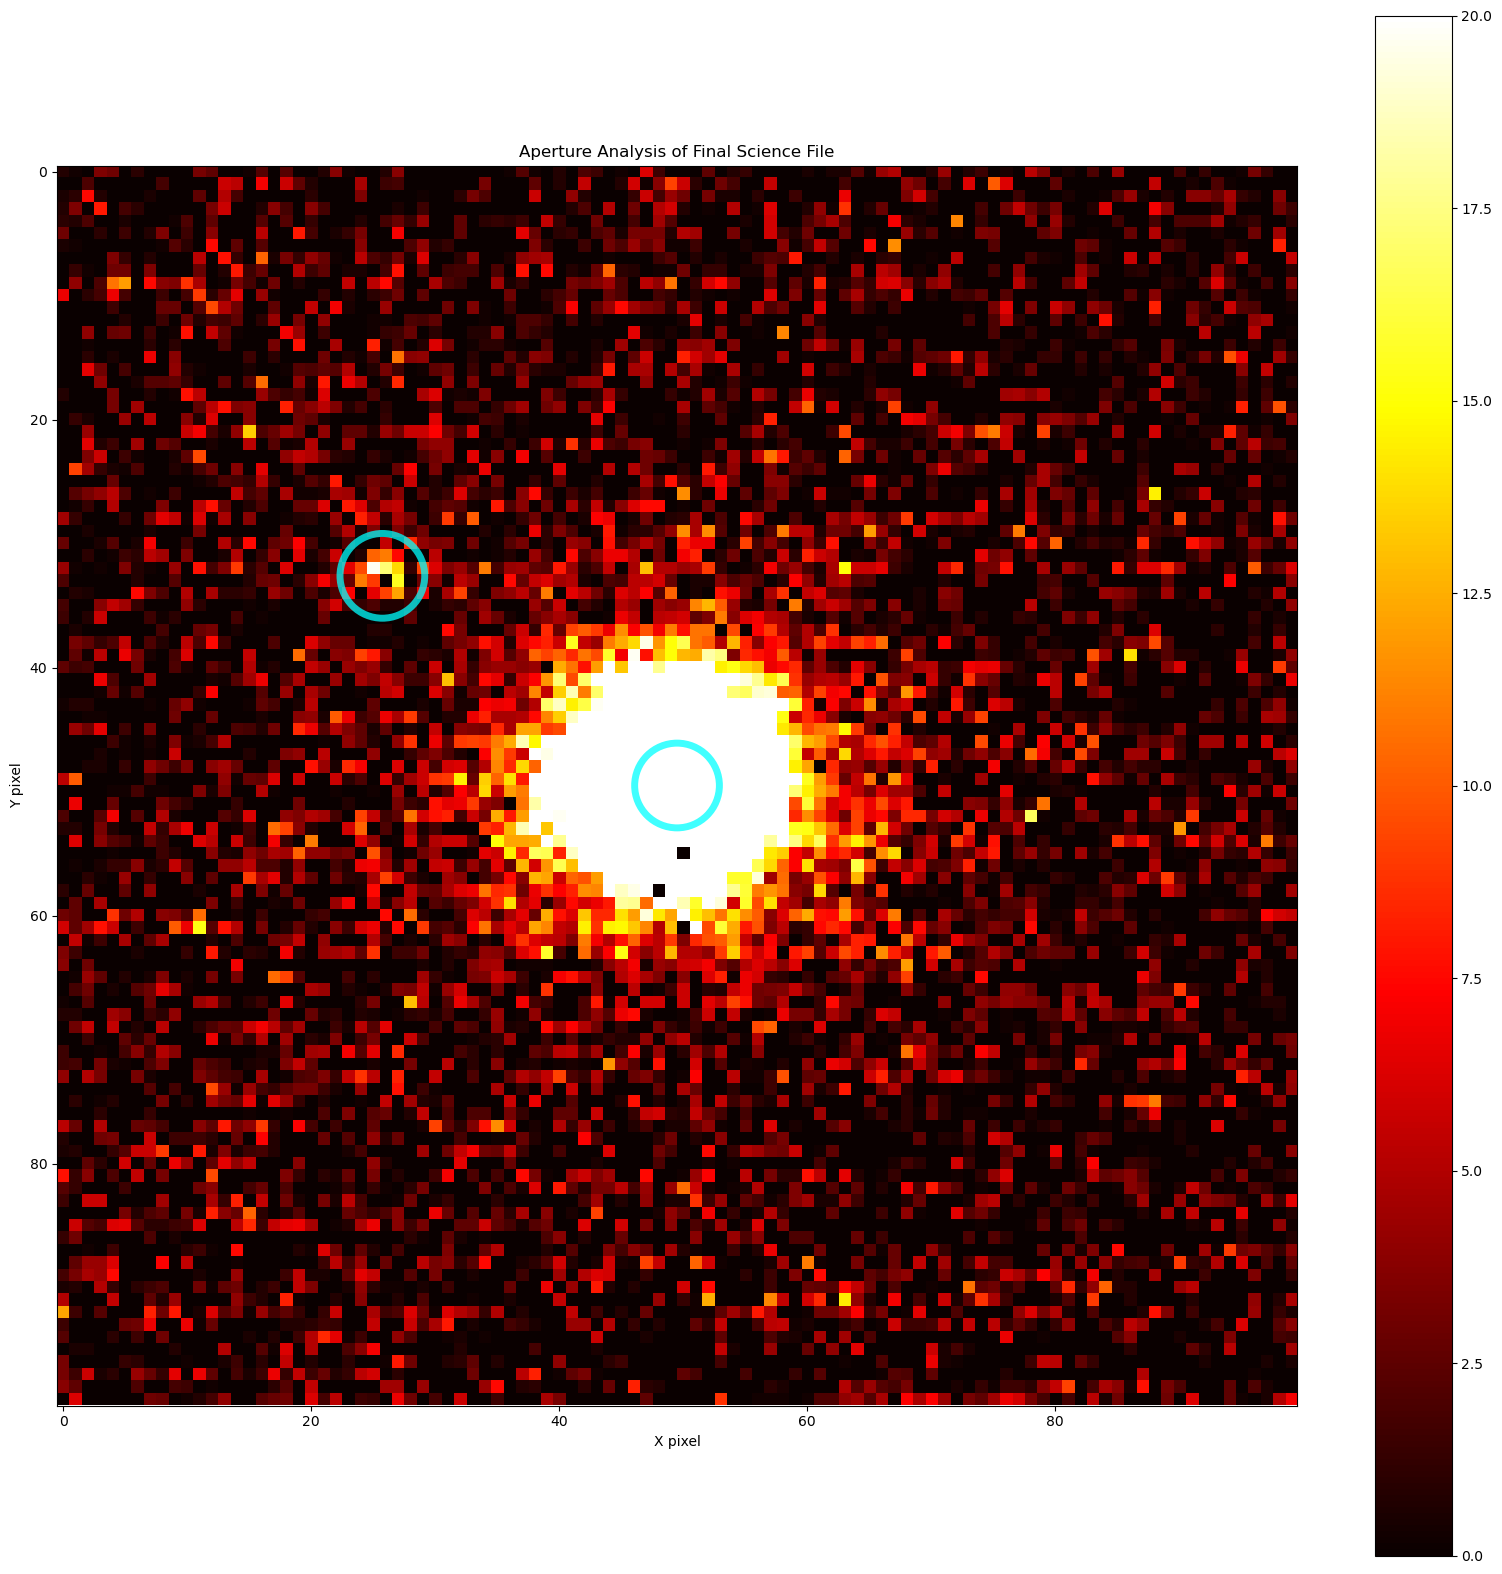

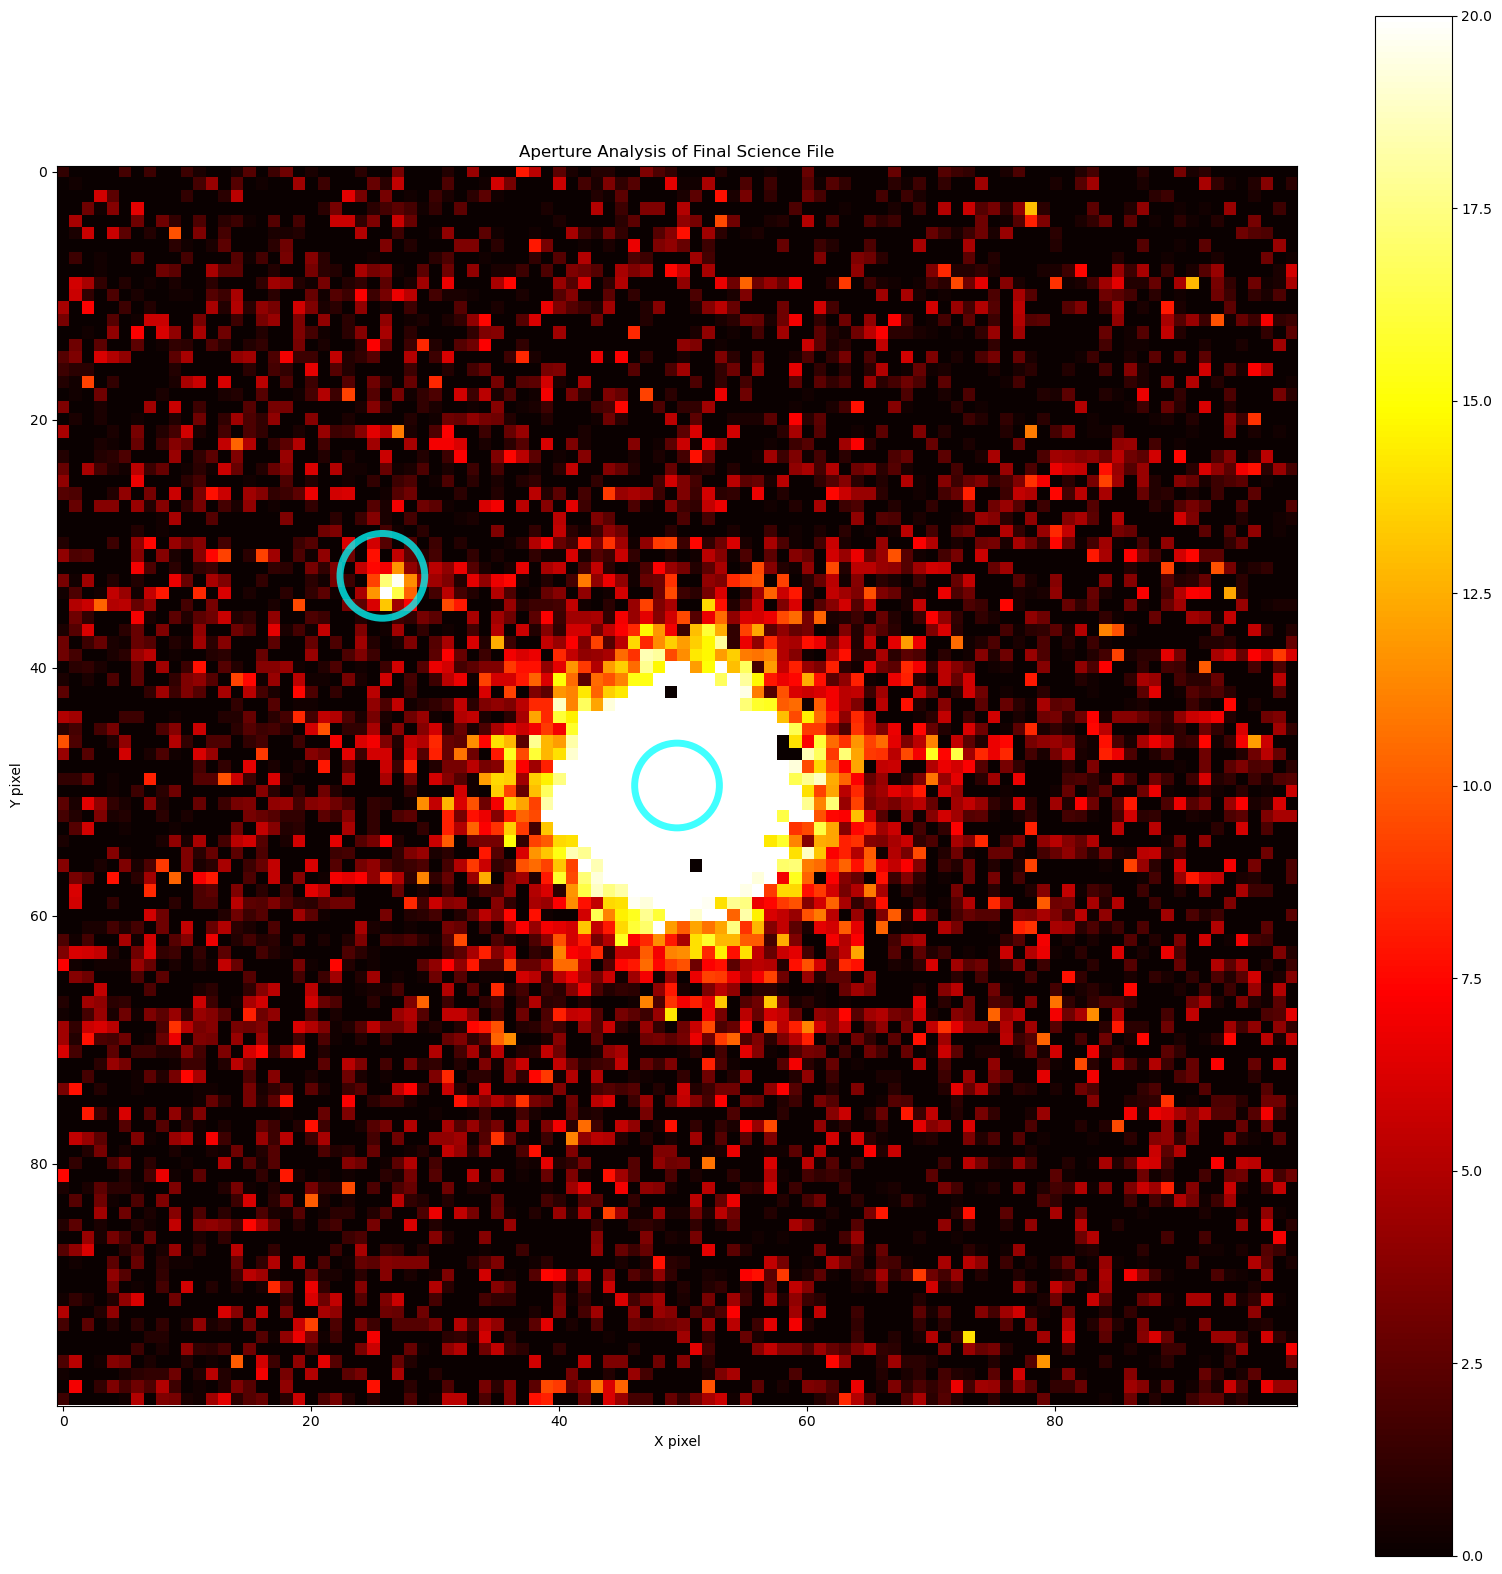

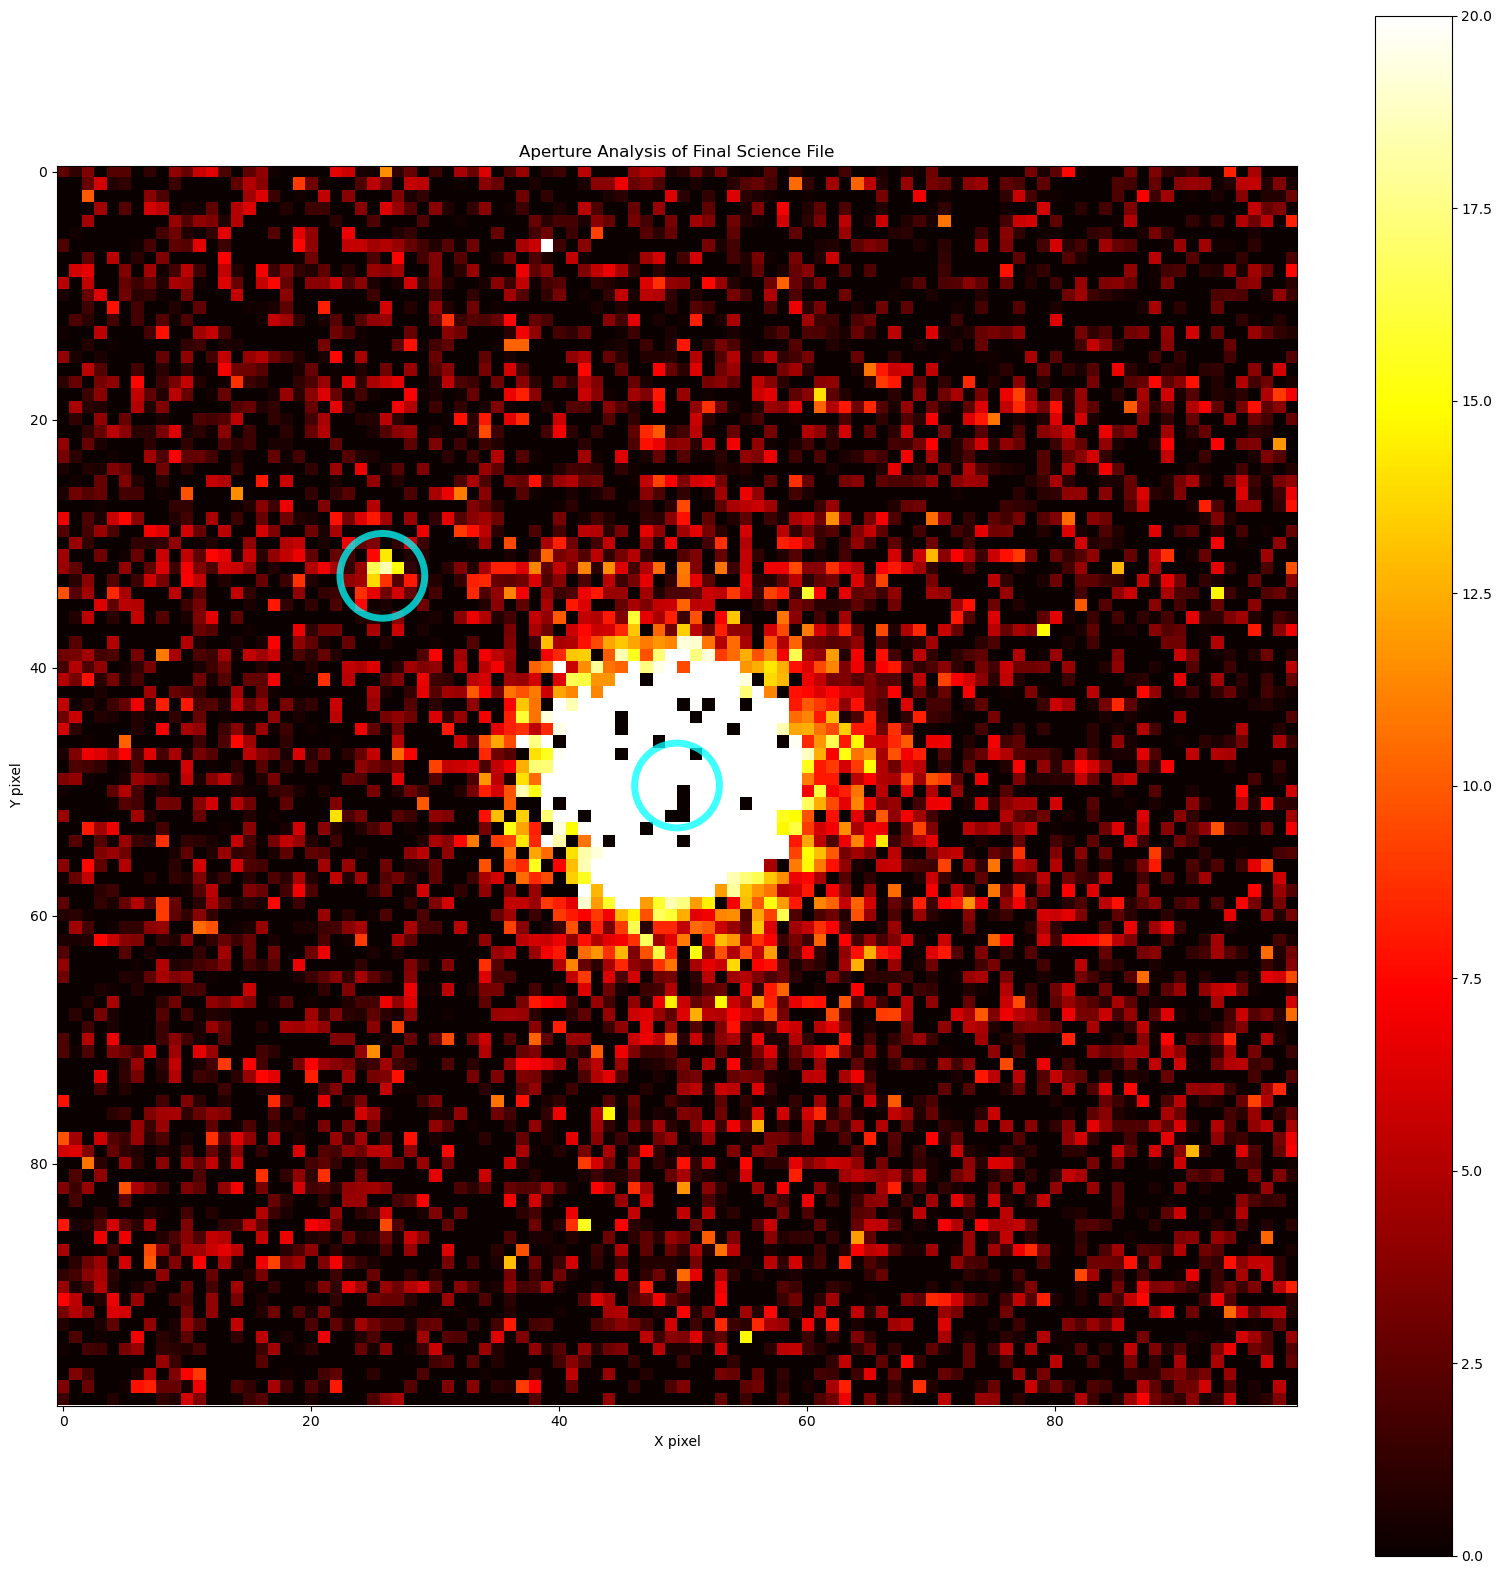

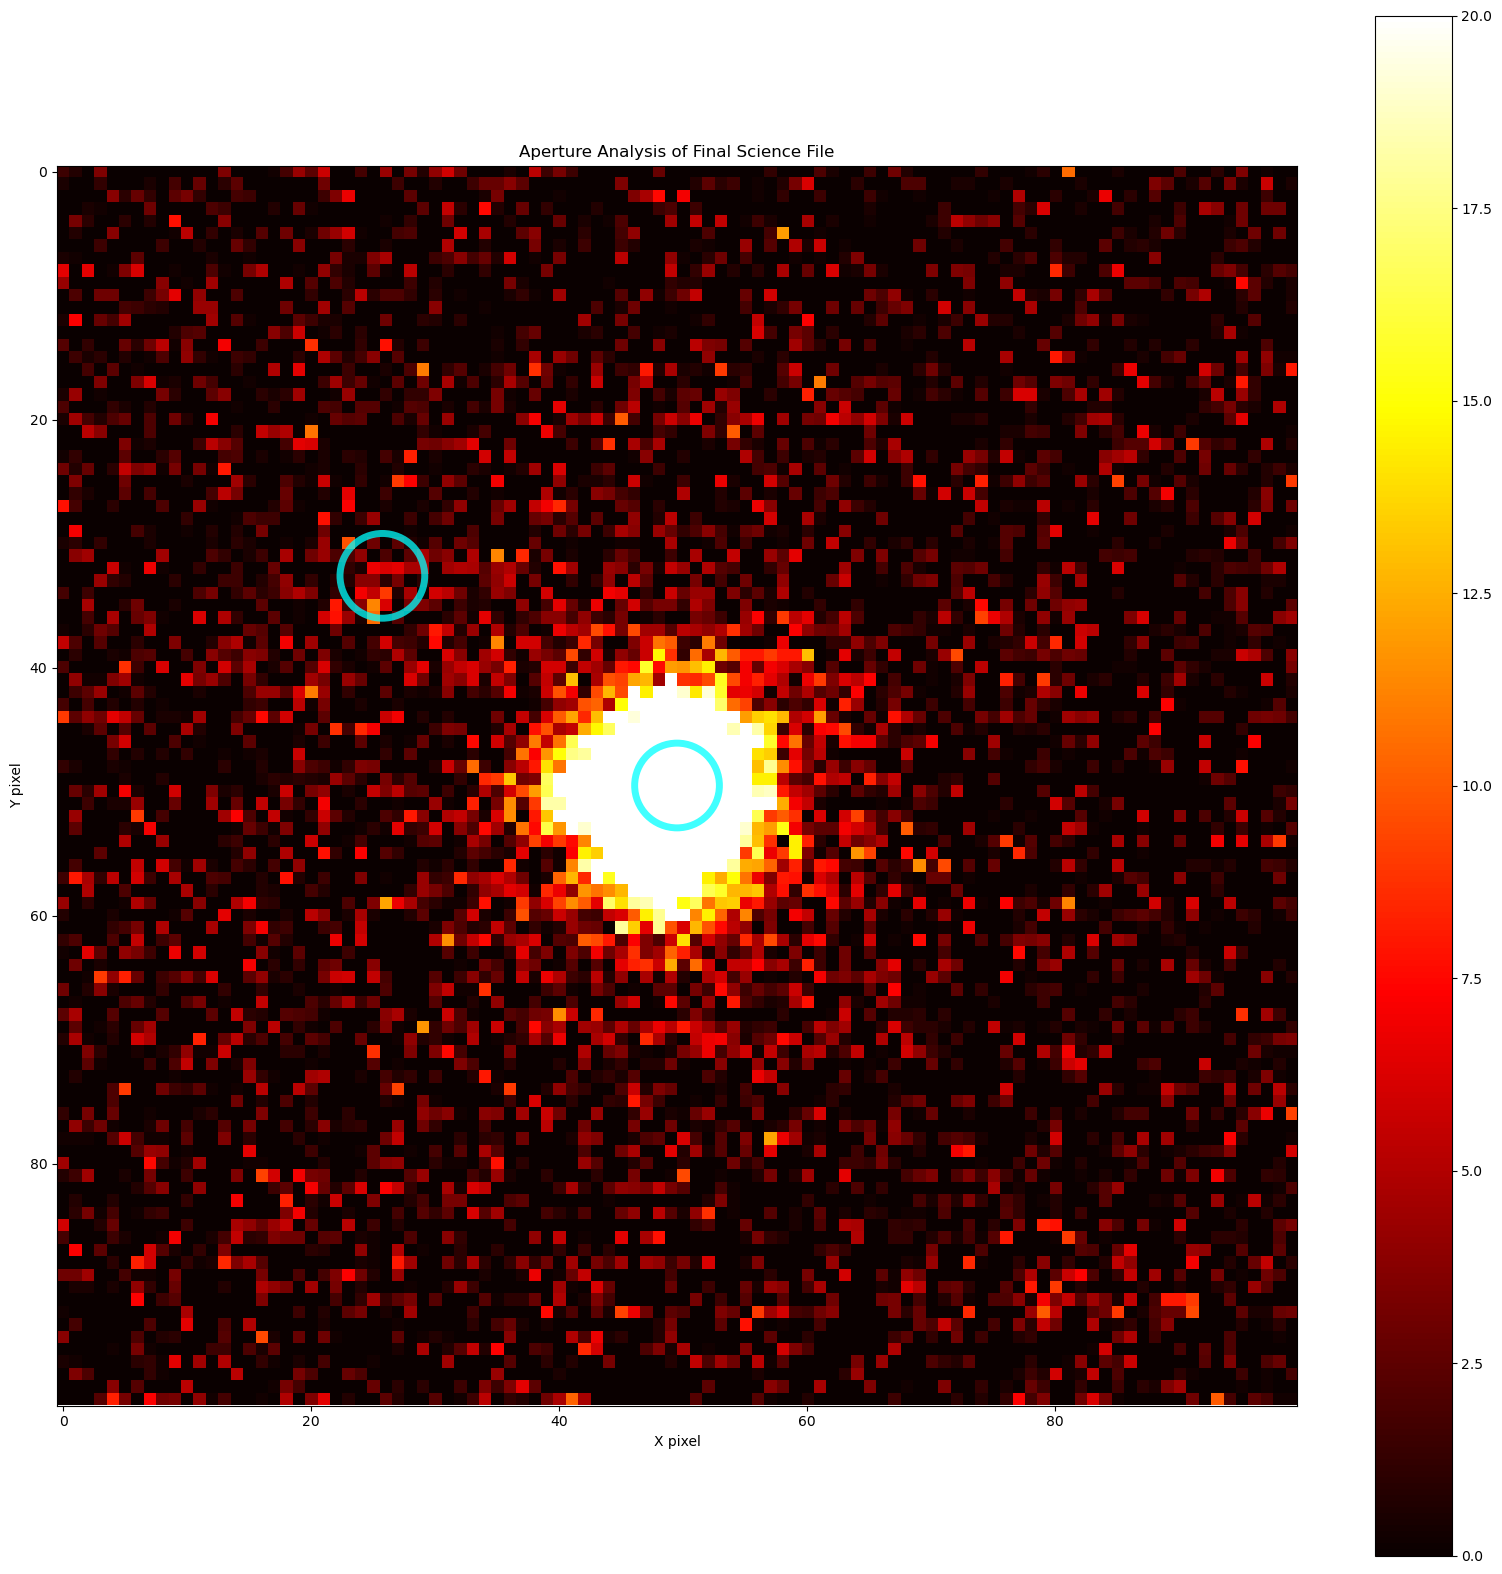

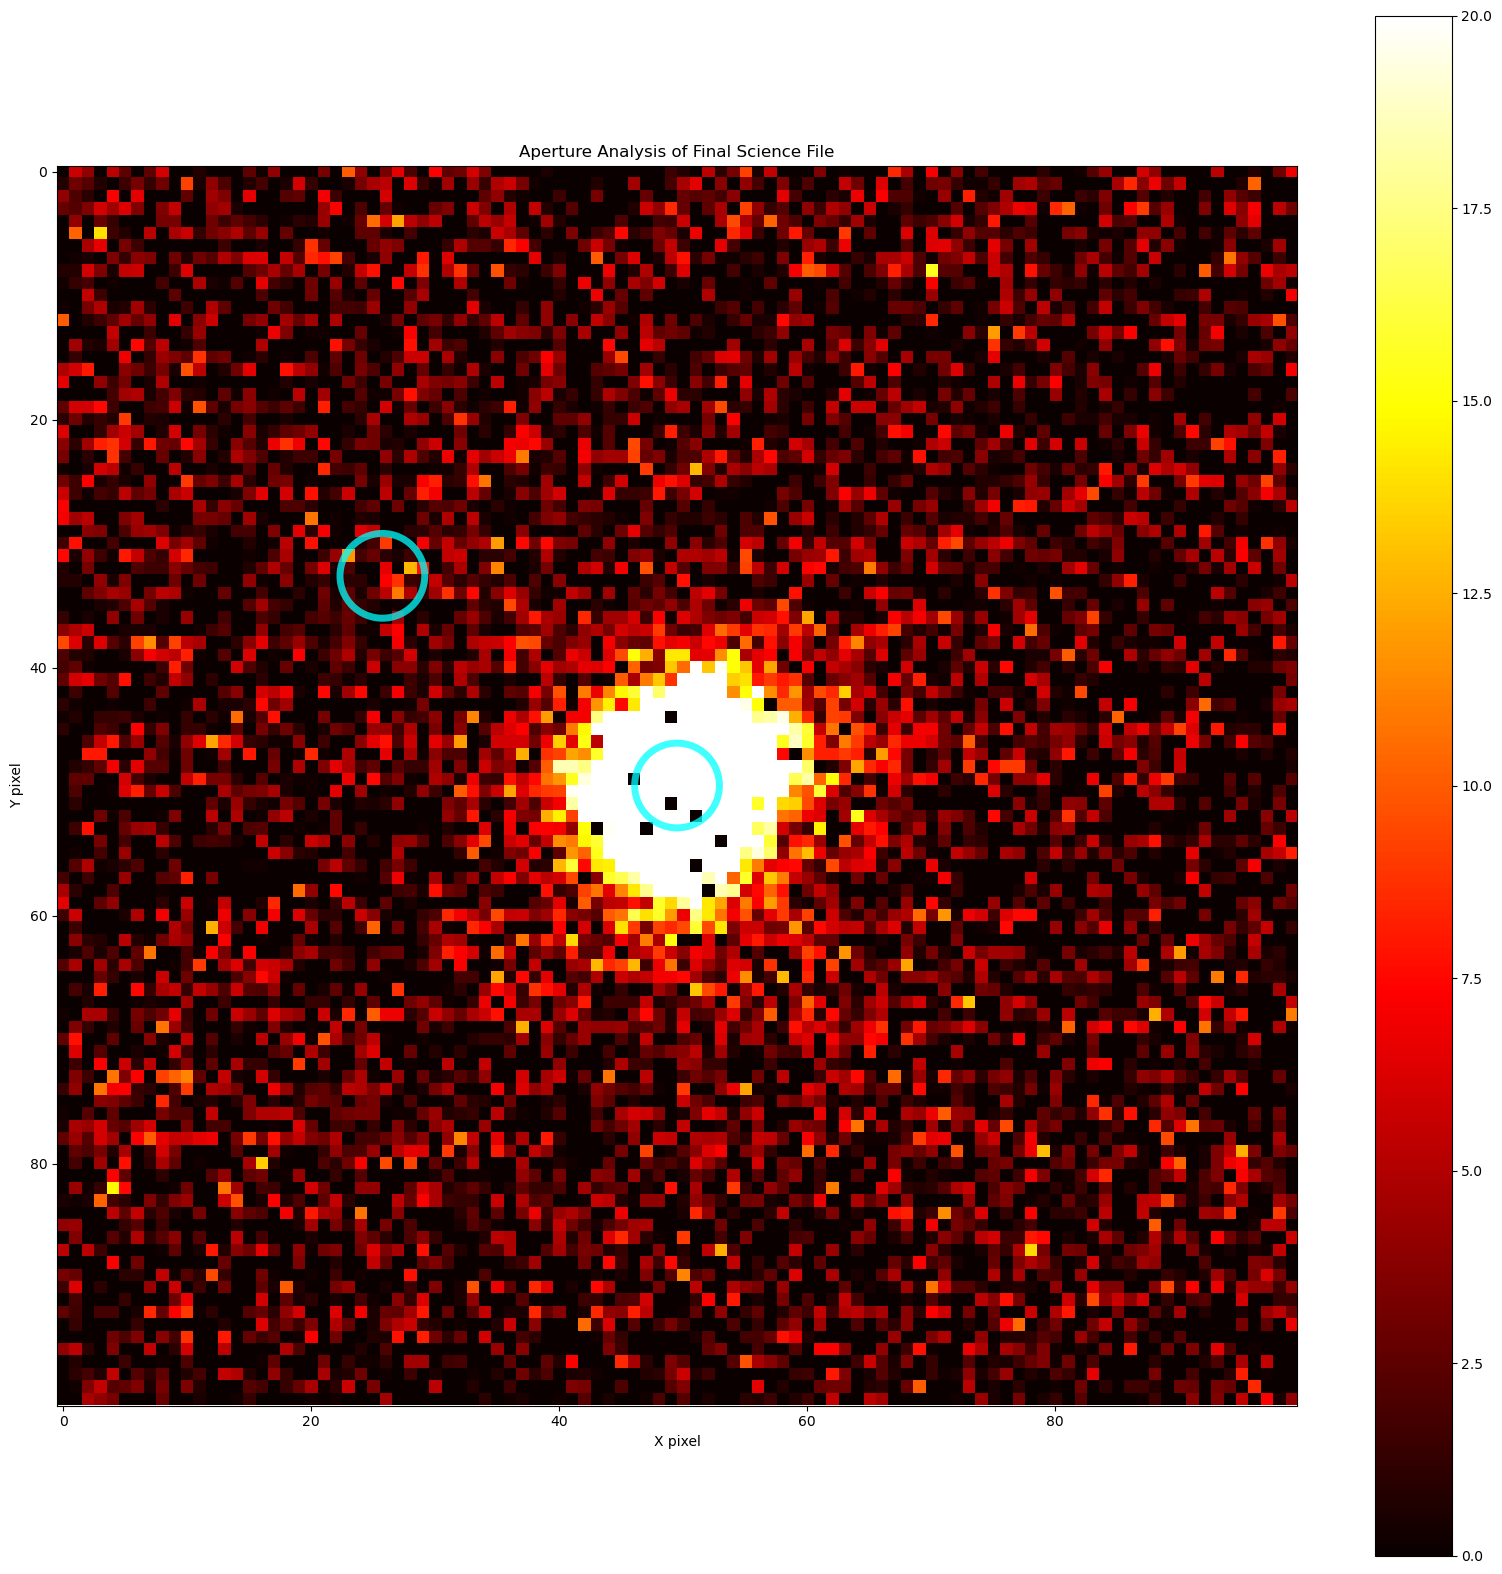

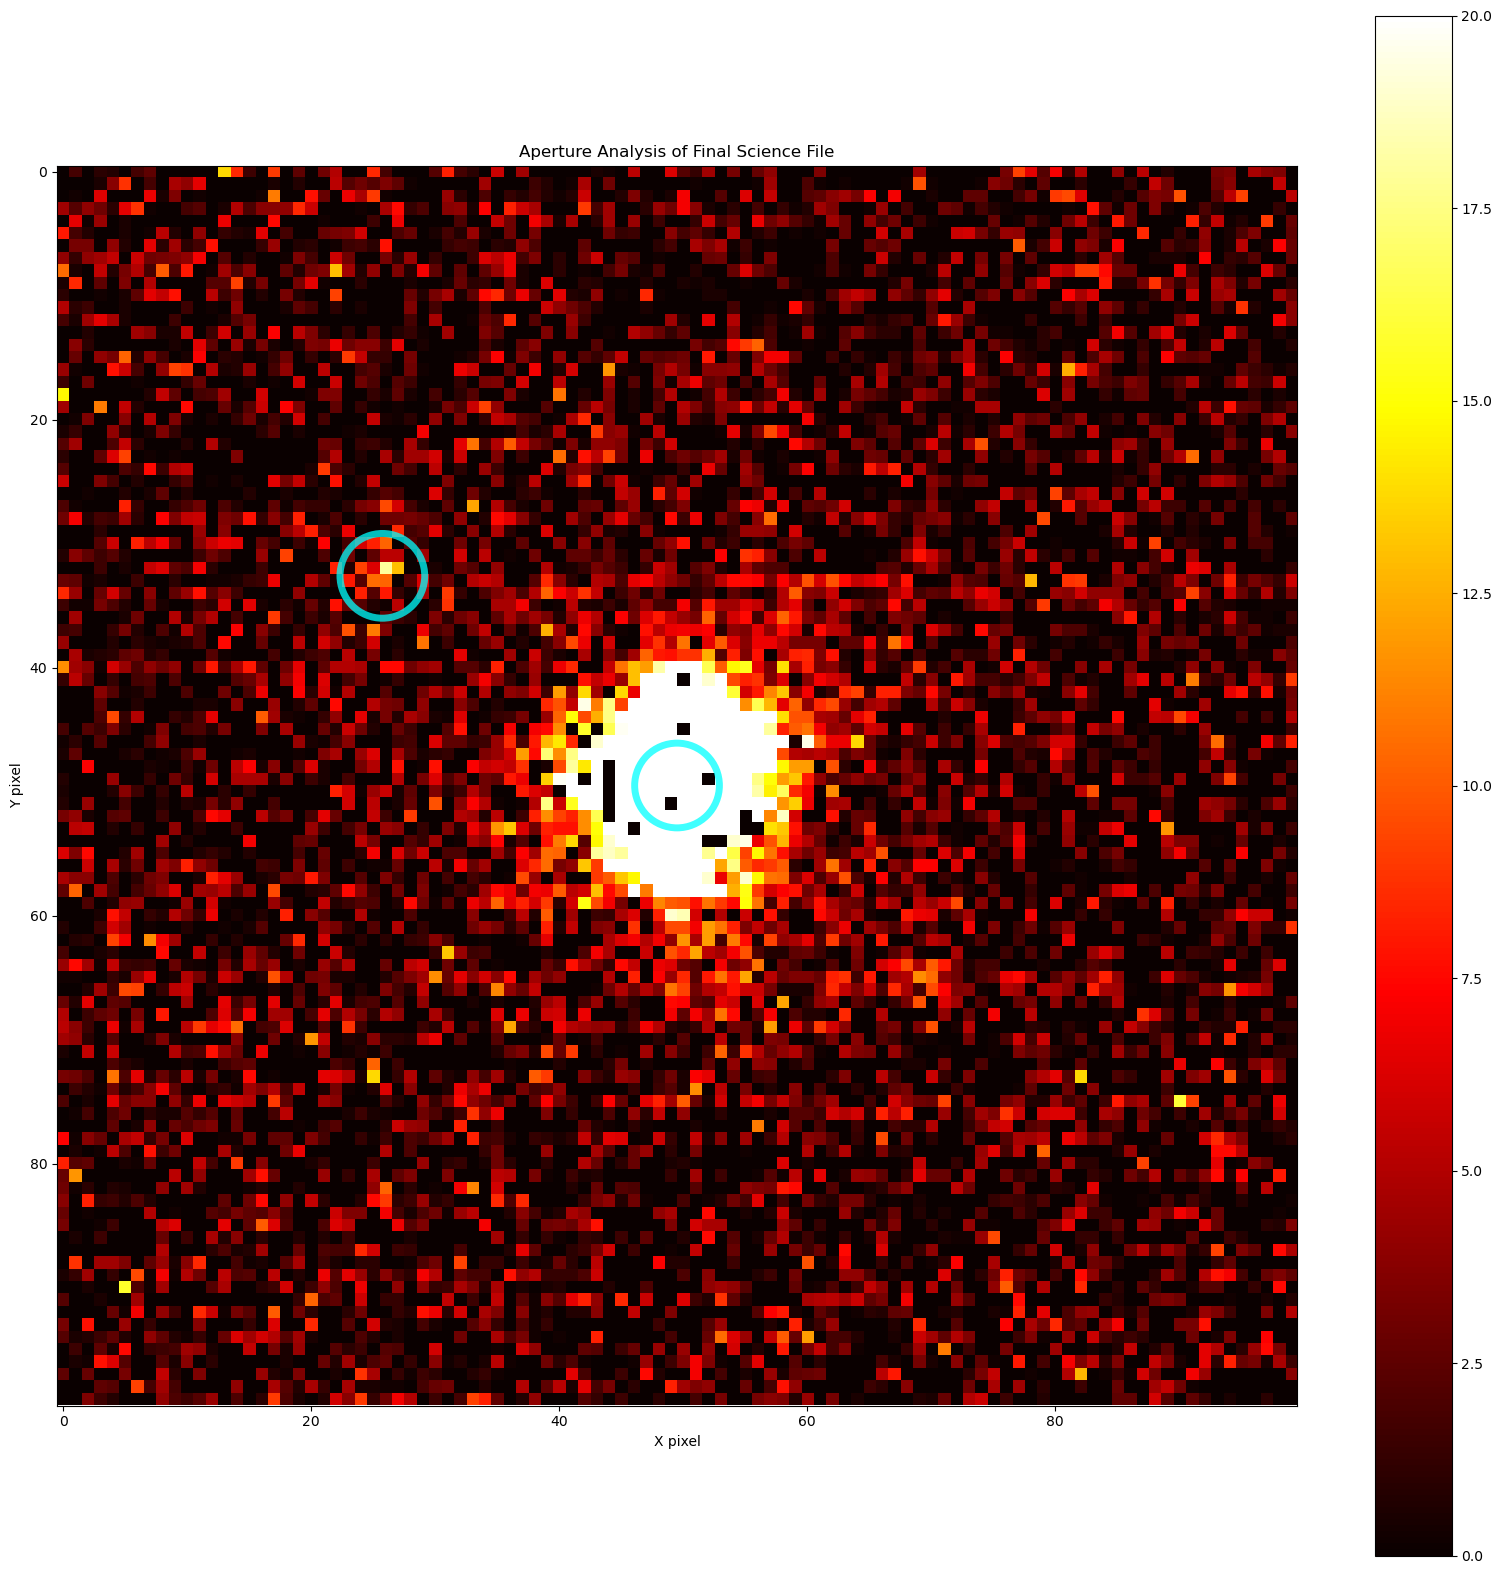

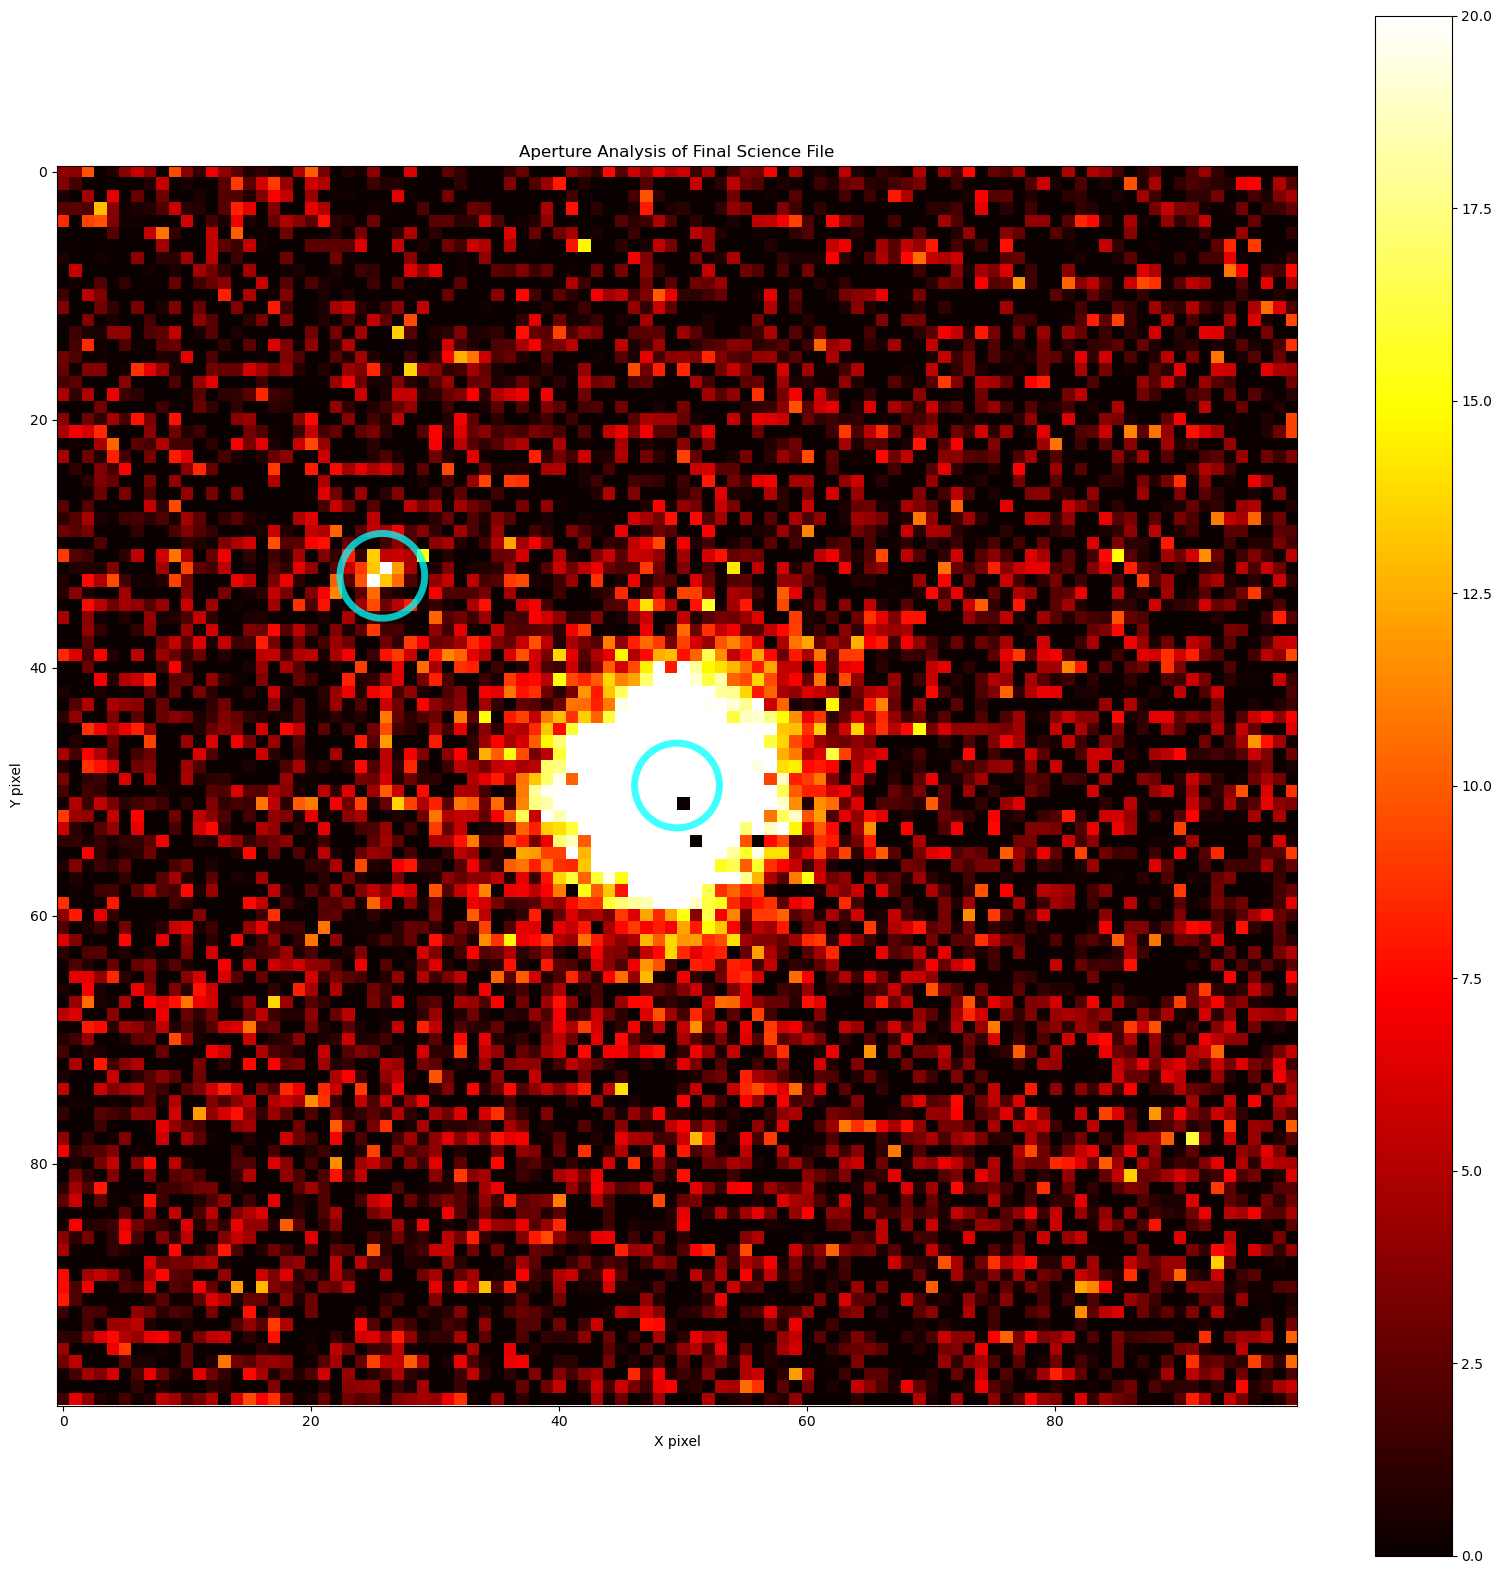

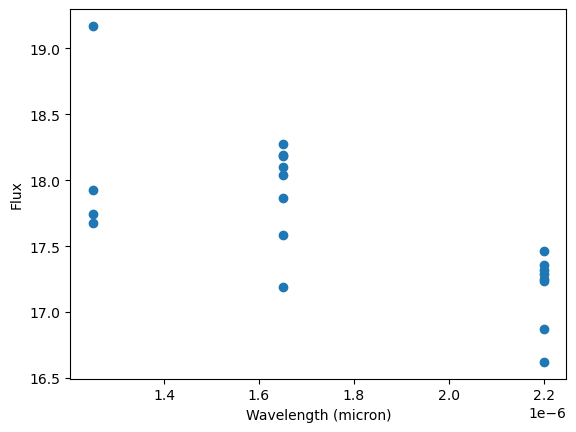

Mean magnitude reported for H: 17.928291010436716
Mean magnitude reported for J: 18.12880946606972
Mean magnitude reported for K: 17.175380527797092


In [107]:
mag_bands = generate_outputs()
for mag in mag_bands:
    print(f"Mean magnitude reported for {mag}: {np.mean(mag_bands[mag])}")

We have mean magnitude values for each of our bands and we can convert these into flux values to define points for our SED. I made use of the online magnitude conversion calculator located at https://www.gemini.edu/observing/resources/magnitudes-and-fluxes/conversions-between-magnitudes-and-flux. Using the known wavelength values for the H and K bands (upon further consideration, we did not consider the J band to have enough contrast to find the exoplanet), we found flux values of 8.069e-17 W/m^2/micron and 5.555e-17 W/m^2/micron respectively for the exoplanet.

Histogram Comparisons (Darks)

H


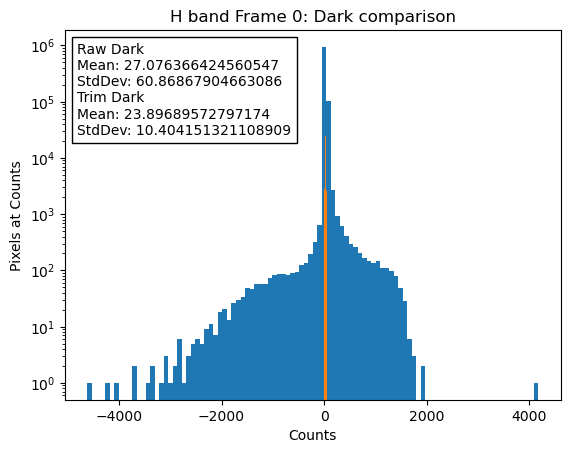

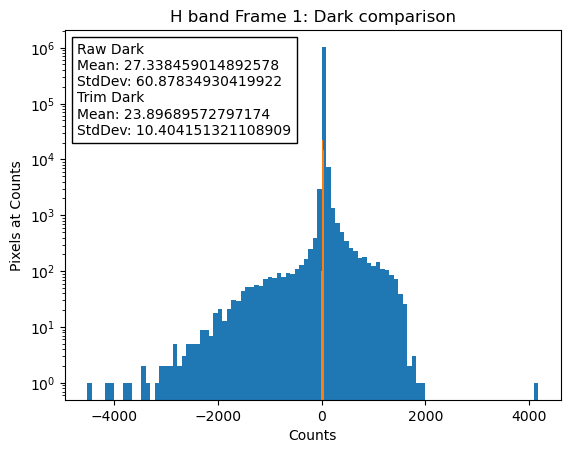

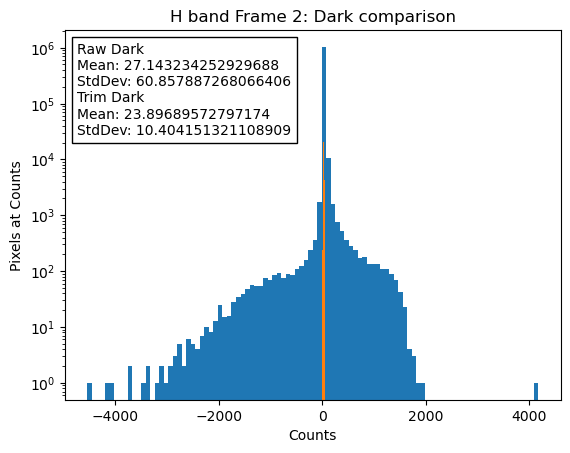

J


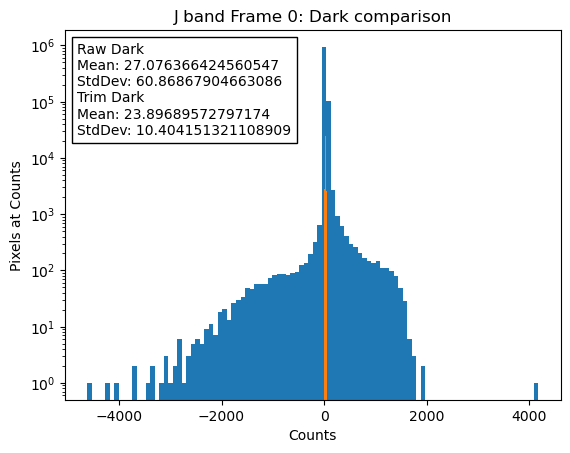

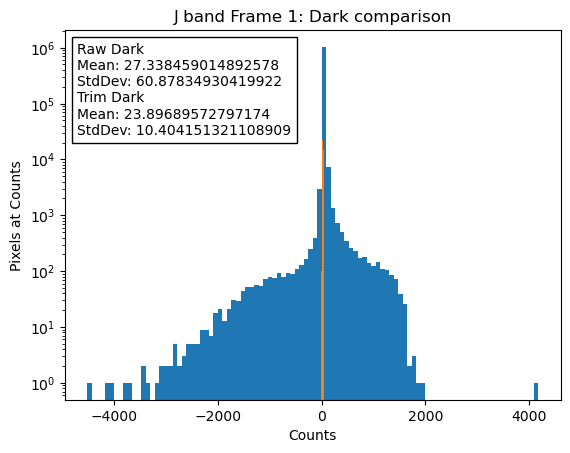

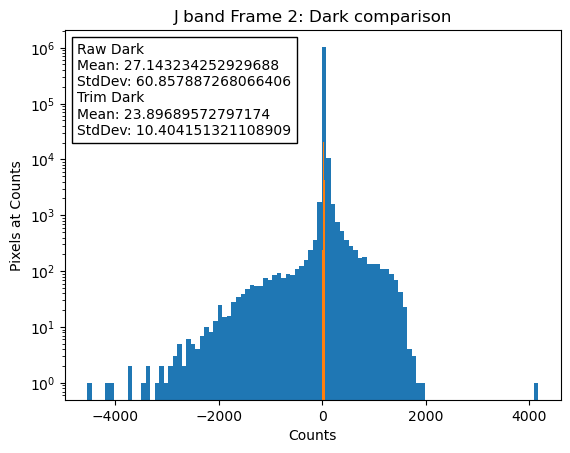

K


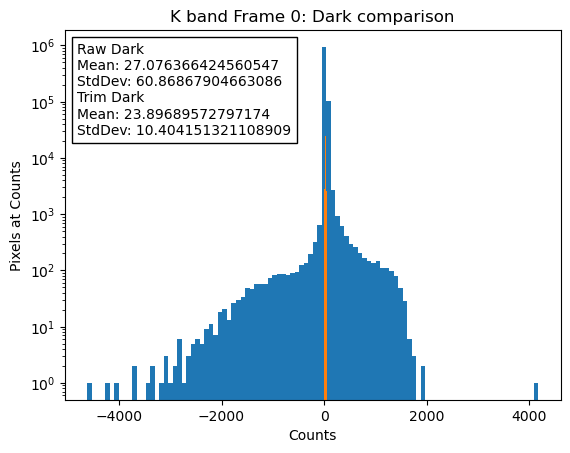

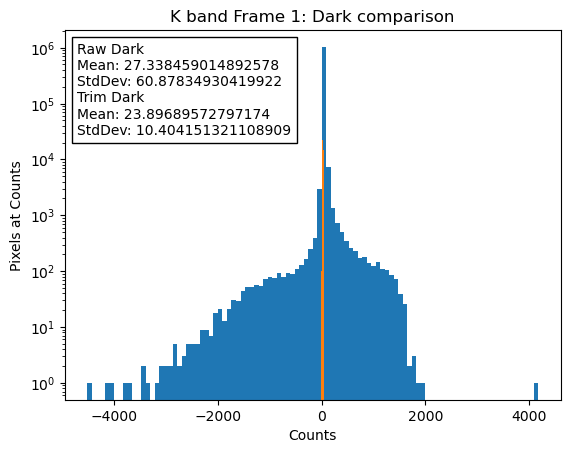

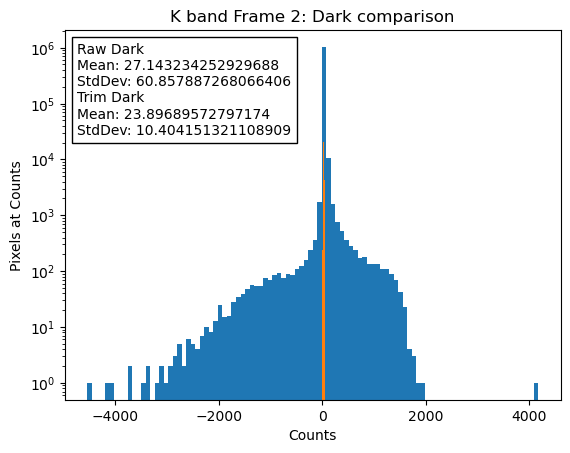

In [112]:
bands = ['H', 'J', 'K']
for band in bands:
    print(band)
    for index, file in enumerate(filedict[band]["darks"]):
        fig, ax = plt.subplots()
        raw_dark = open_fits(file)
        trim_dark = sigma_mask(masterdict[band]["darks"][1])[3]
        ax.hist(np.ndarray.flatten(raw_dark), bins=100)
        ax.hist(np.ndarray.flatten(trim_dark), bins=100)
        text_string = f"Raw Dark\nMean: {np.mean(np.ndarray.flatten(raw_dark))}\nStdDev: {np.std(np.ndarray.flatten(raw_dark))}\n"
        text_string += f"Trim Dark\nMean: {np.mean(np.ndarray.flatten(trim_dark))}\nStdDev: {np.std(np.ndarray.flatten(trim_dark))}"
        anchored_text = AnchoredText(text_string, loc=2)
        ax.add_artist(anchored_text)
        ax.set_yscale("log")
        ax.set_xlabel("Counts")
        ax.set_ylabel("Pixels at Counts")
        ax.set_title(f"{band} band Frame {index}: Dark comparison")
        plt.show()

Upon initial inspection, I found these histograms to be quite odd. However, being reminded that this plot is in log scale puts this into perspective. The mean following the rejection of bad pixels is not changed much across of our frames, but the standard deviation is significantly improved following the image reduction that was performed on these frames. This is to be expected, all of the dark histograms were centered at a pixel value of 0 so its not as if there was any reason for the peak to shift off of the center in the first place, but the clear benefit of sigma cutting for the dark frames is that it eliminates any pixels with extreme values, allowing us to generate a bad pixel map. Pixels that were eliminated were those that were 3 sigma away from the mean.

Histogram Comparisons (Flats)

H


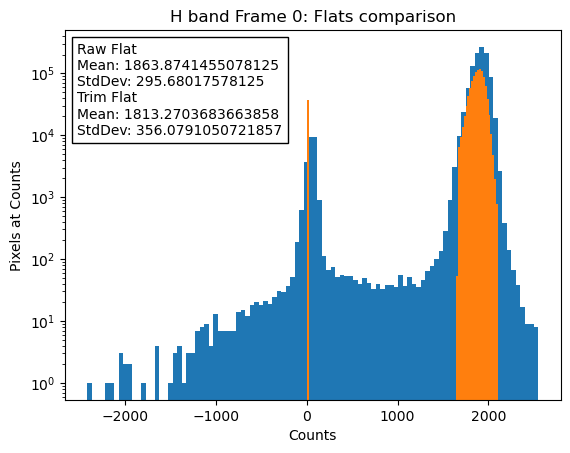

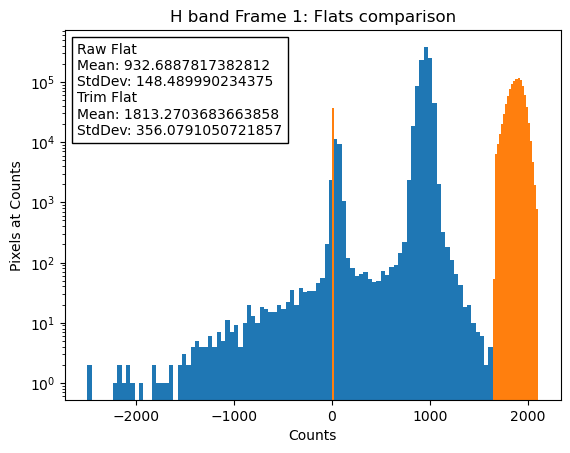

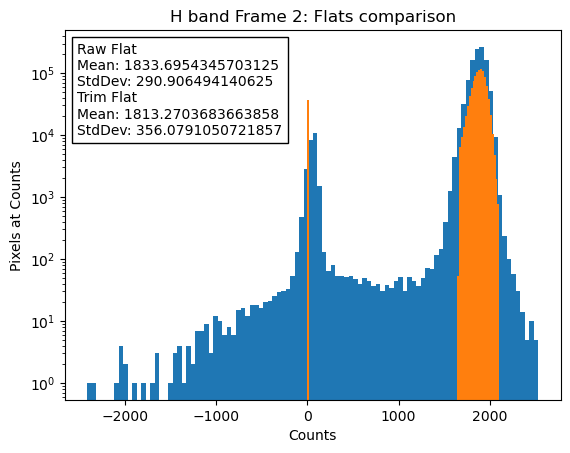

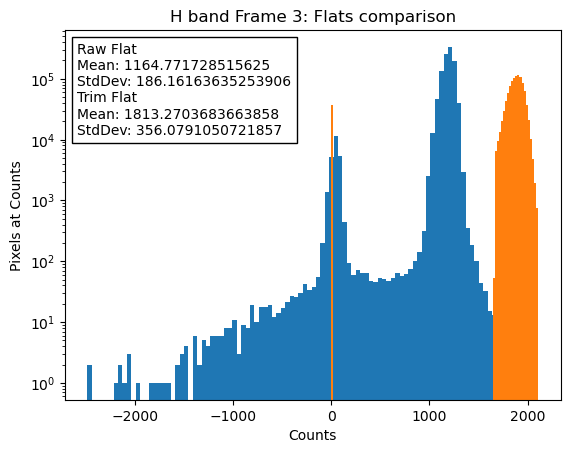

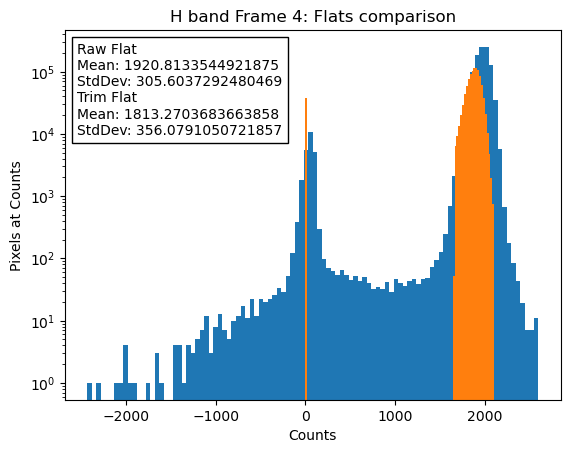

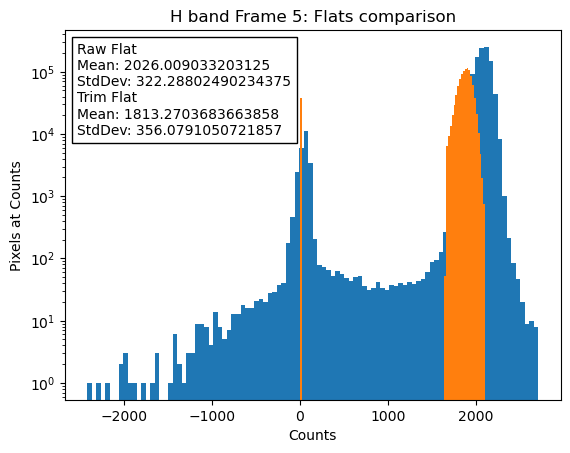

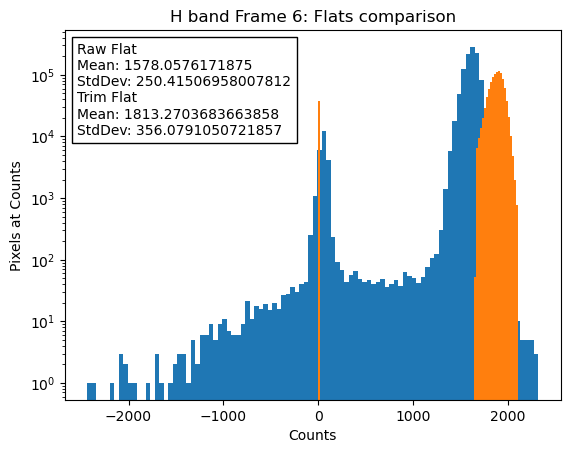

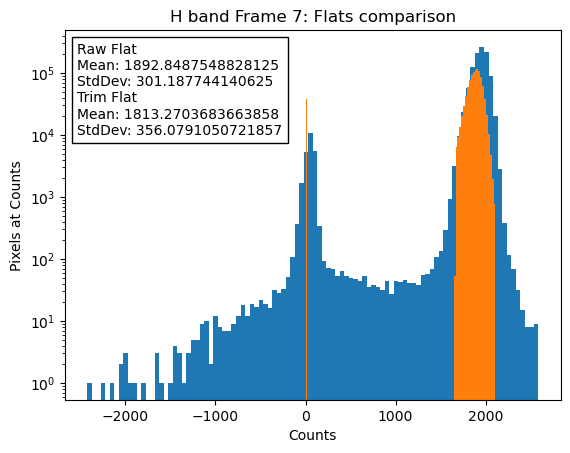

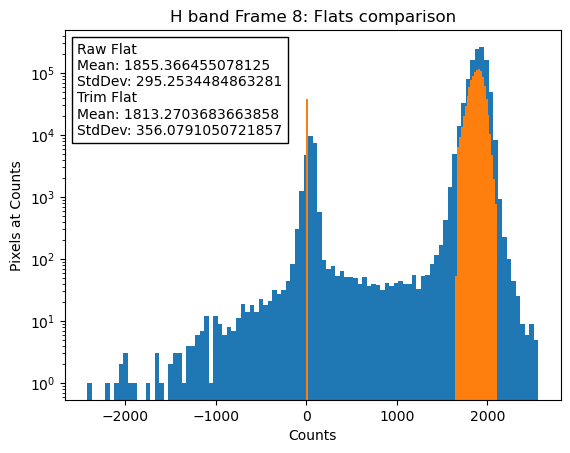

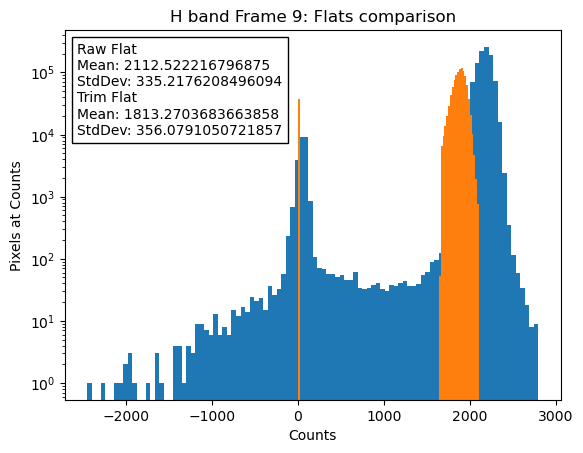

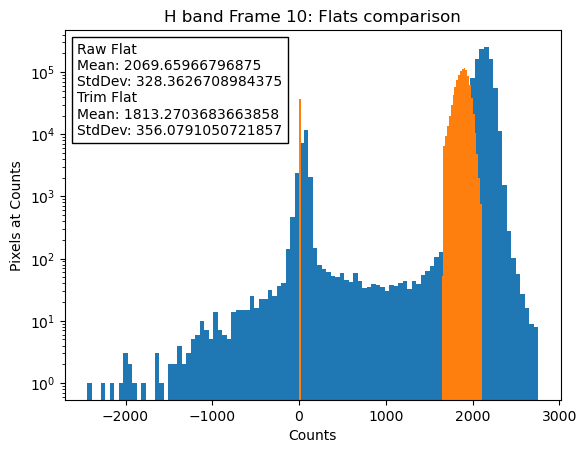

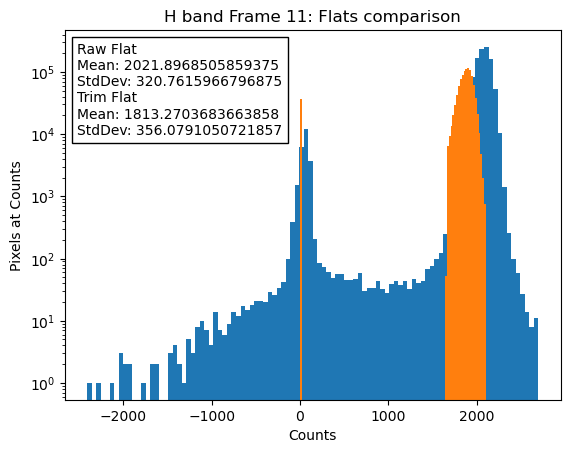

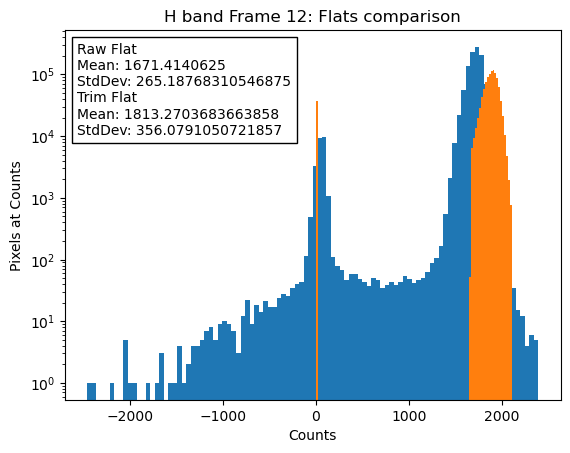

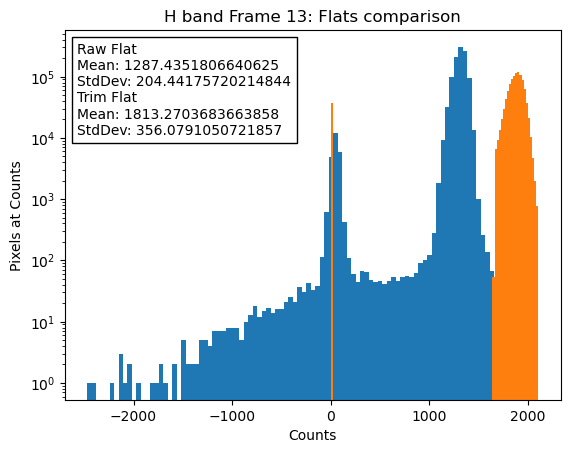

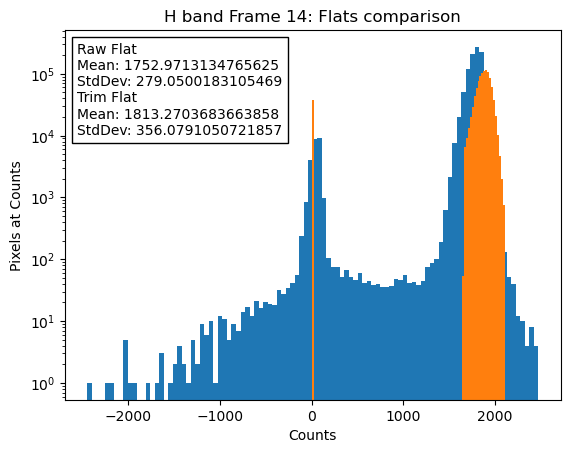

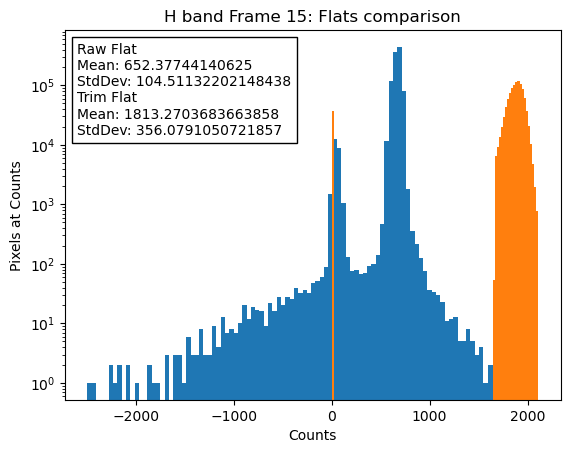

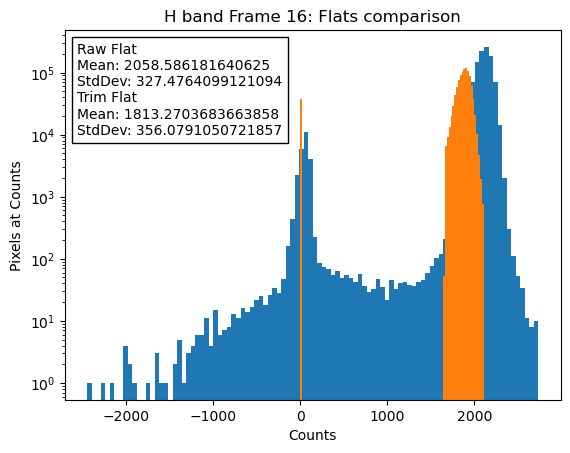

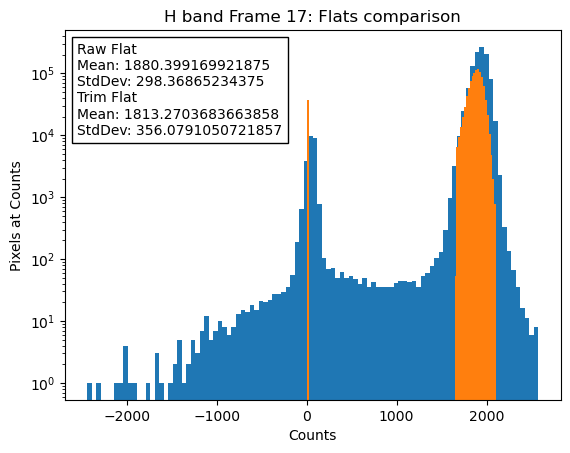

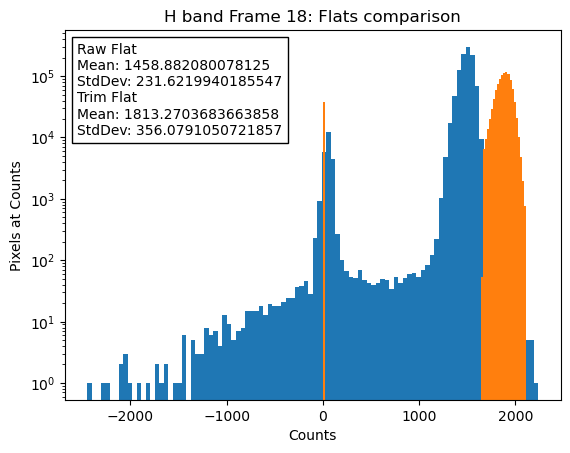

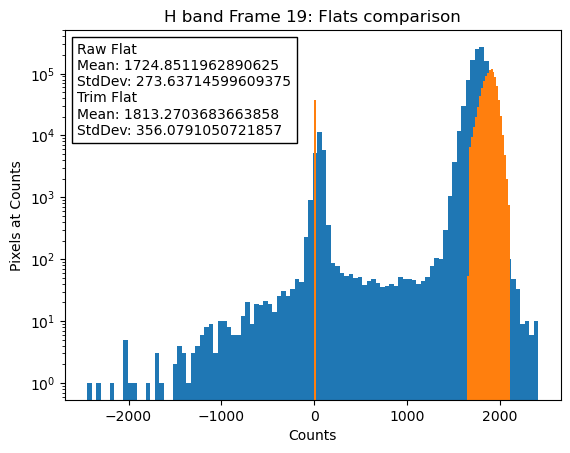

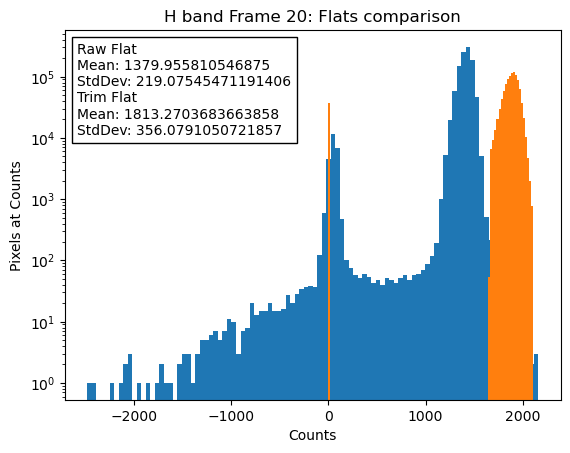

J


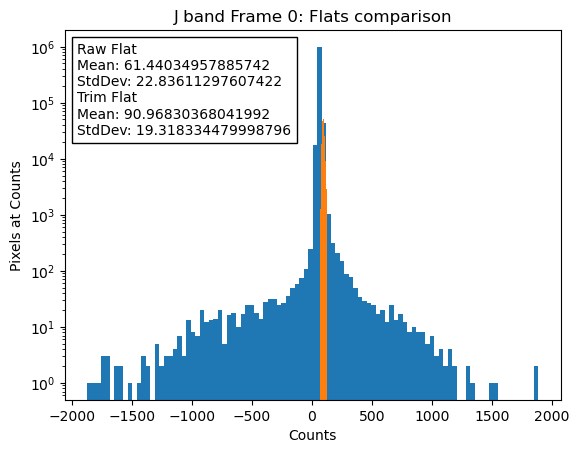

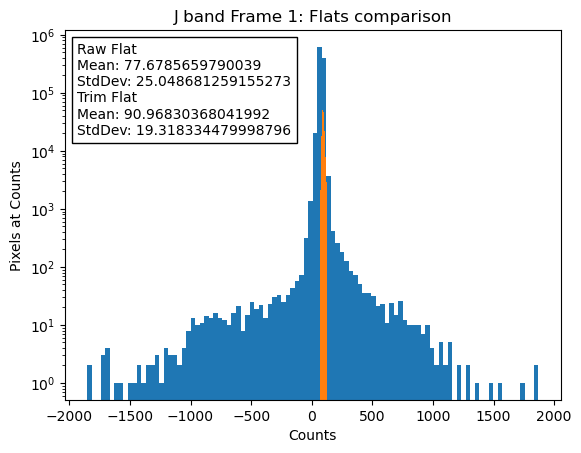

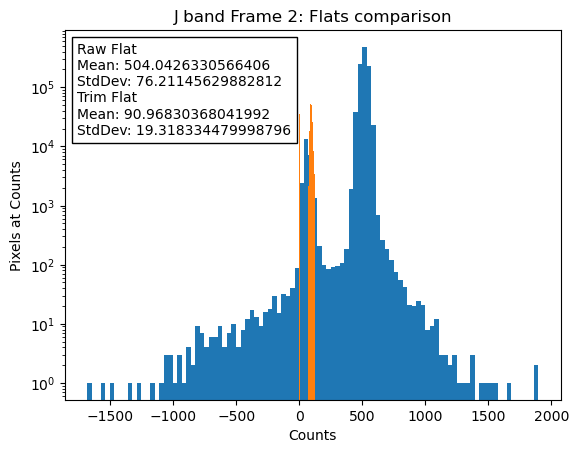

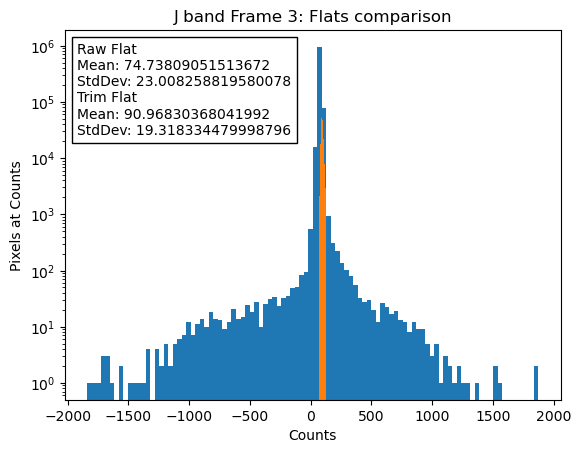

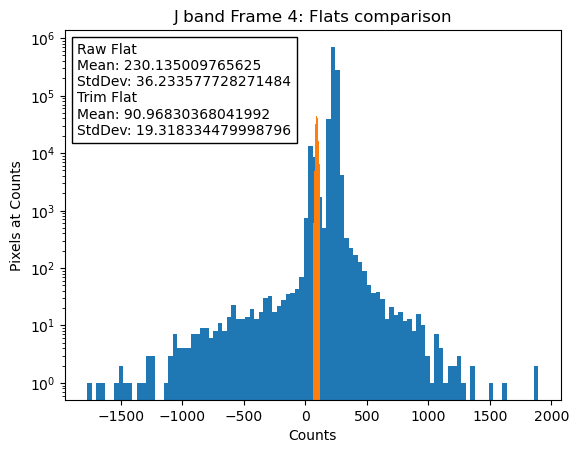

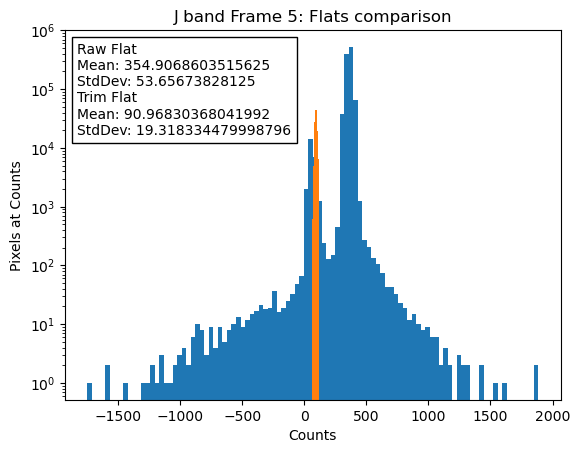

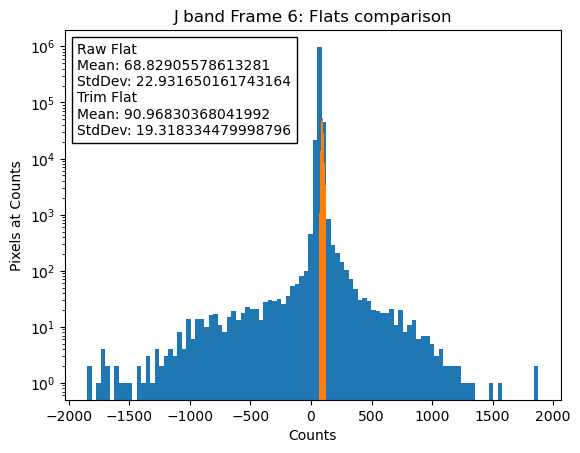

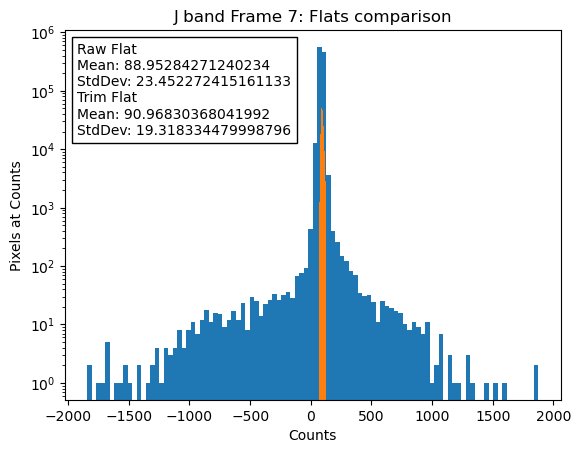

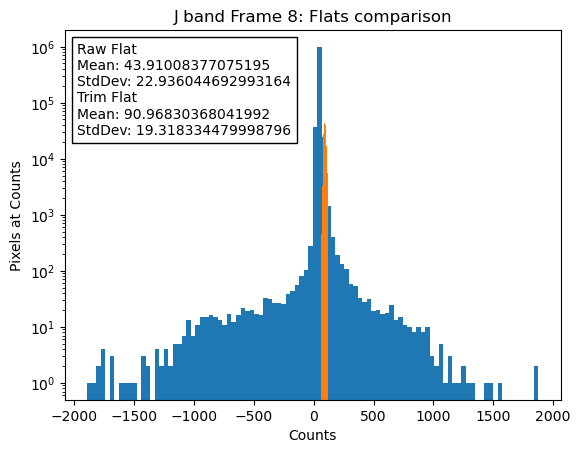

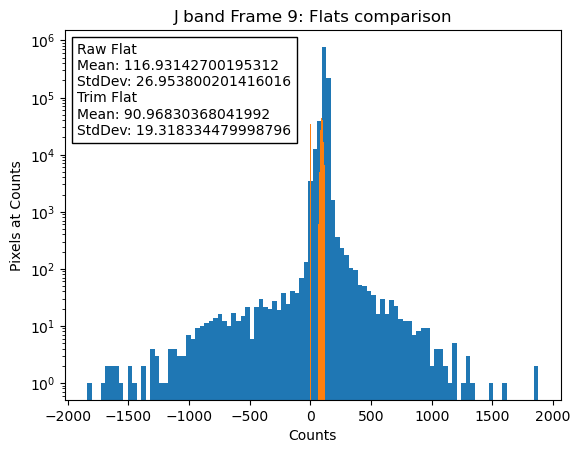

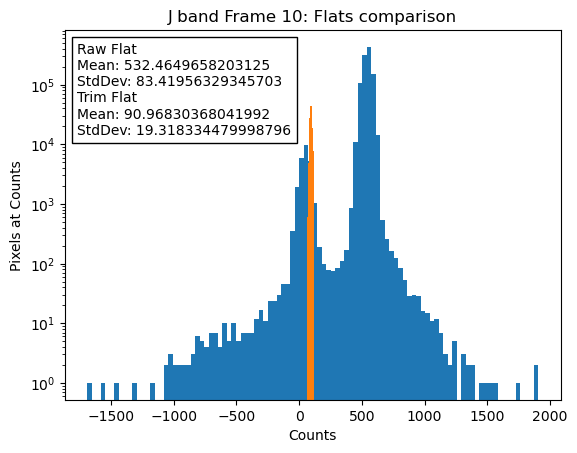

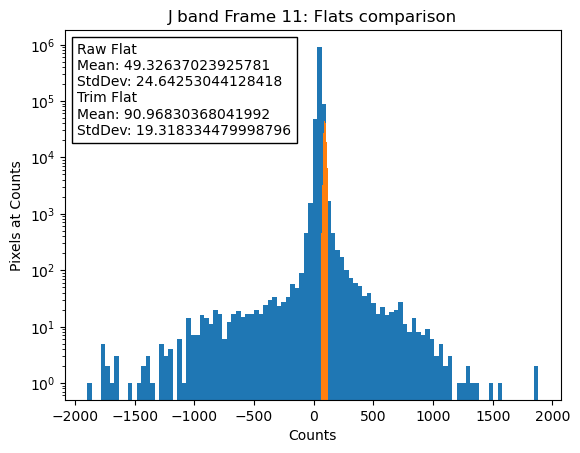

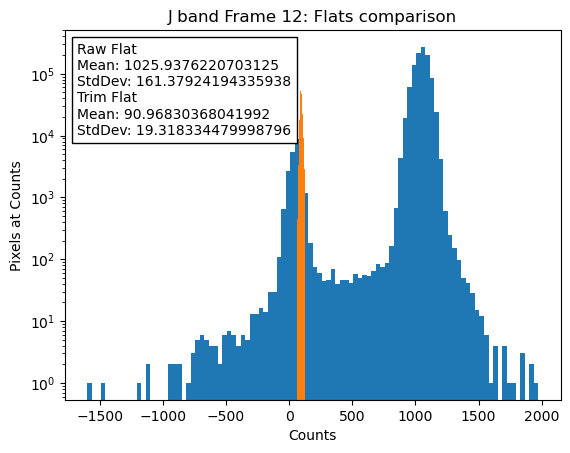

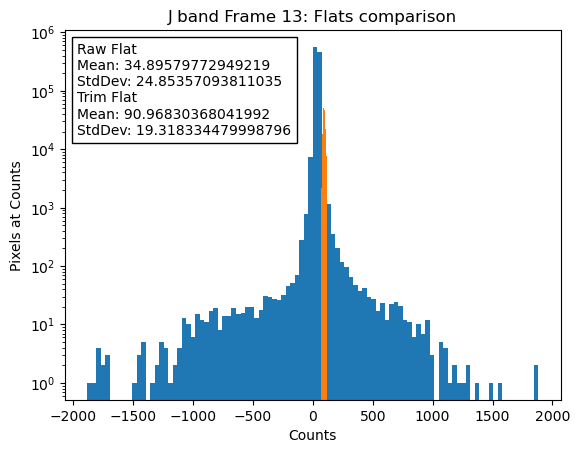

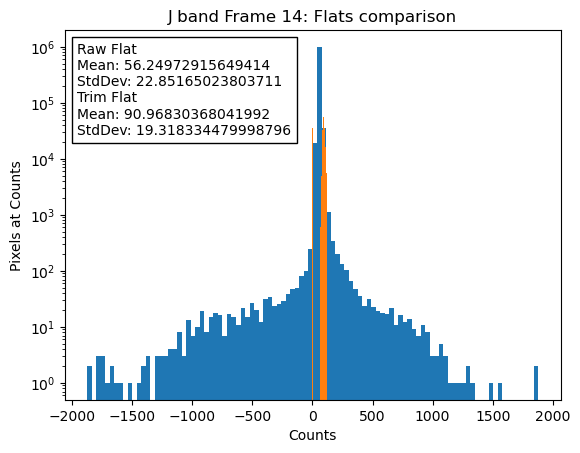

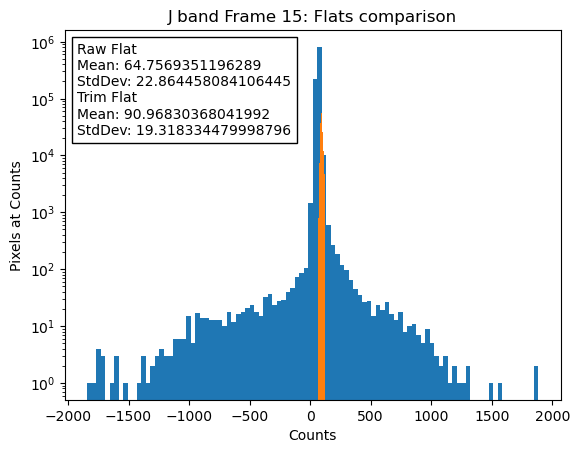

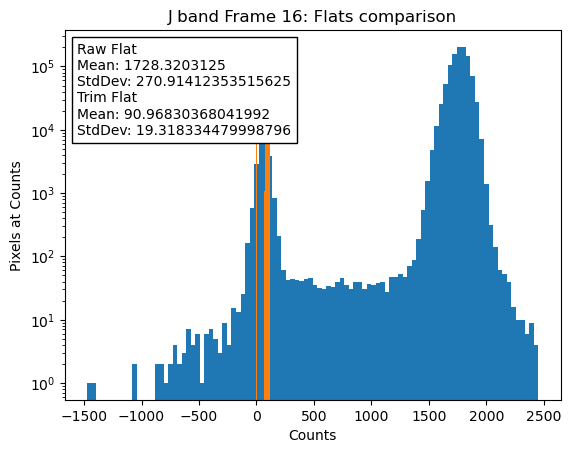

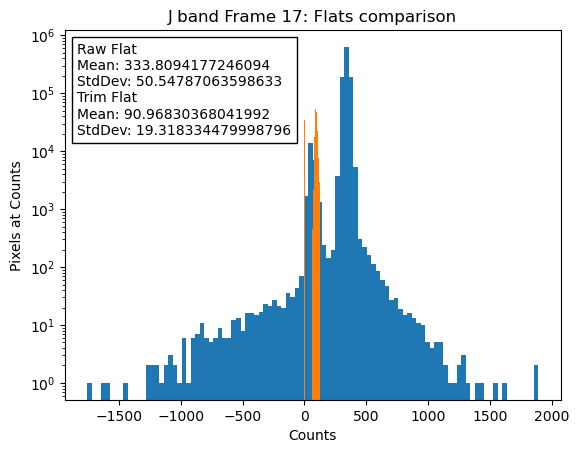

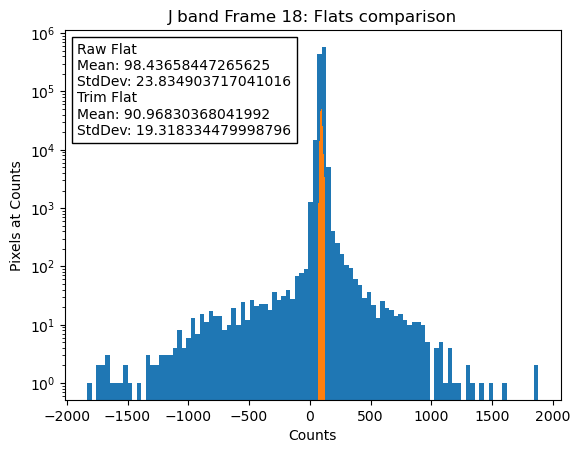

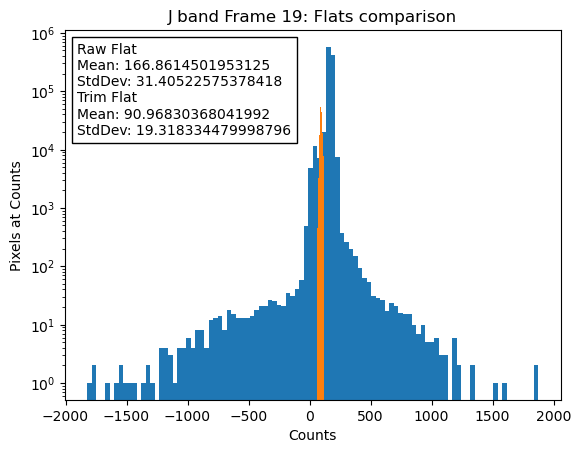

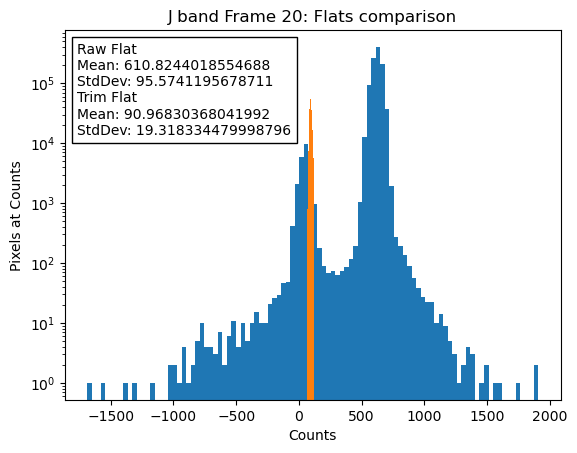

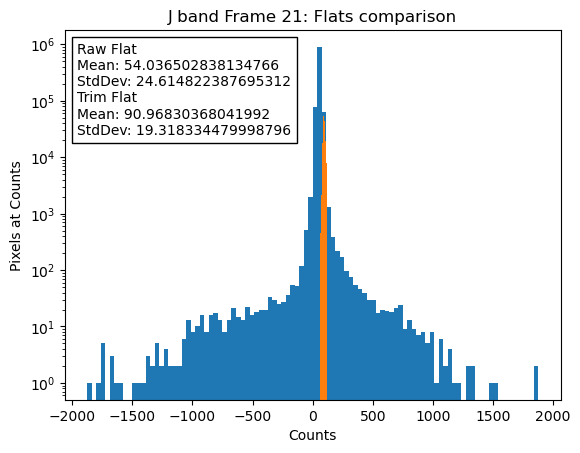

K


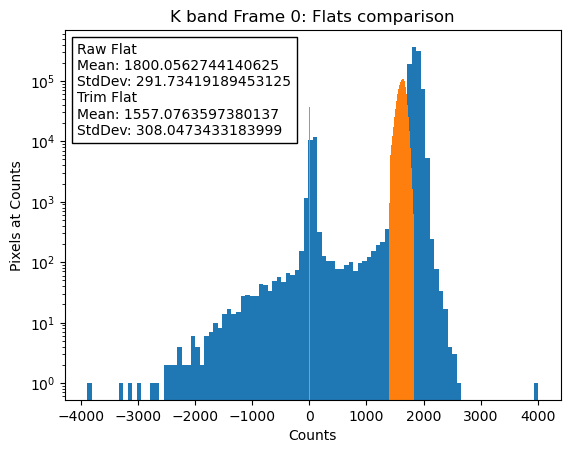

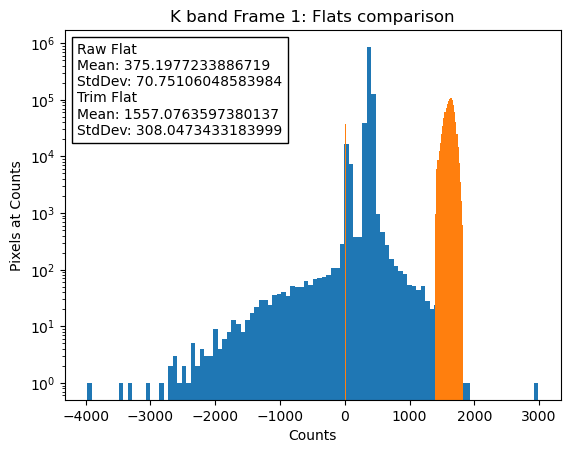

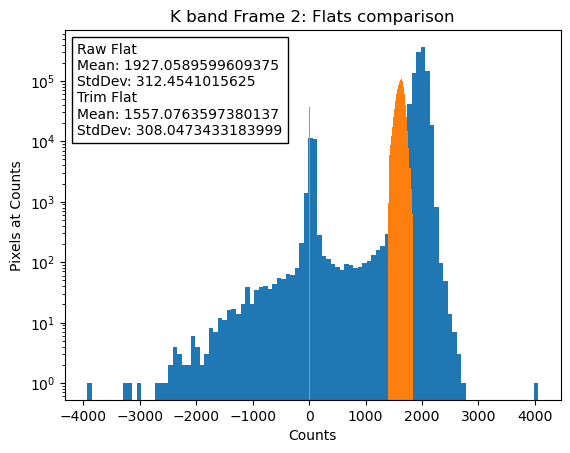

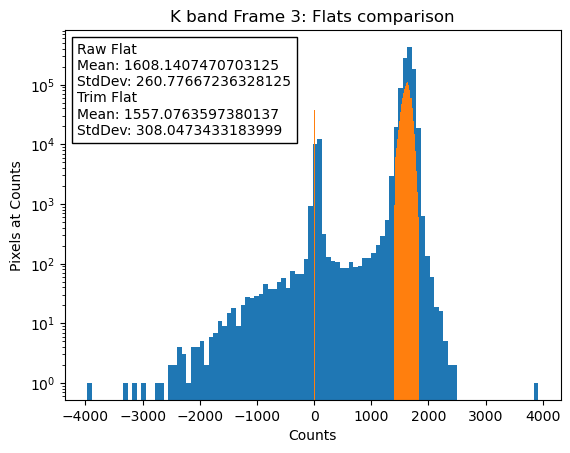

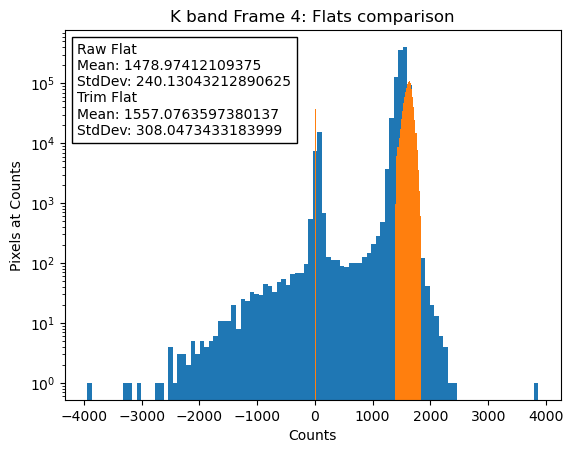

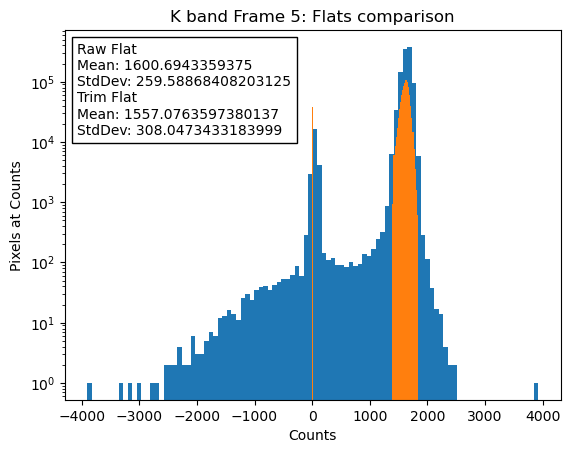

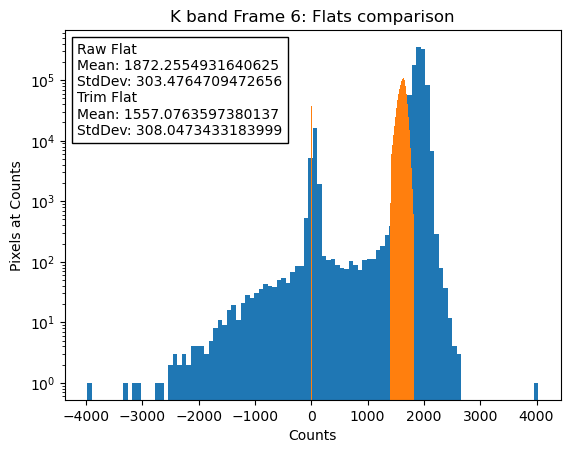

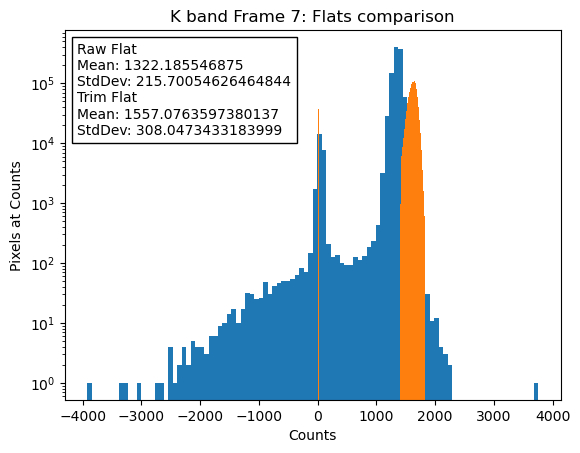

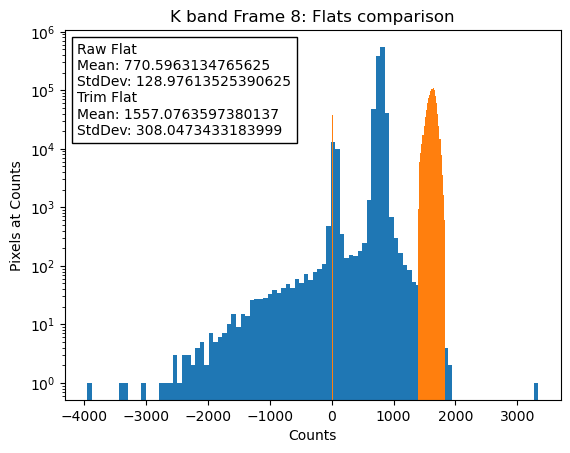

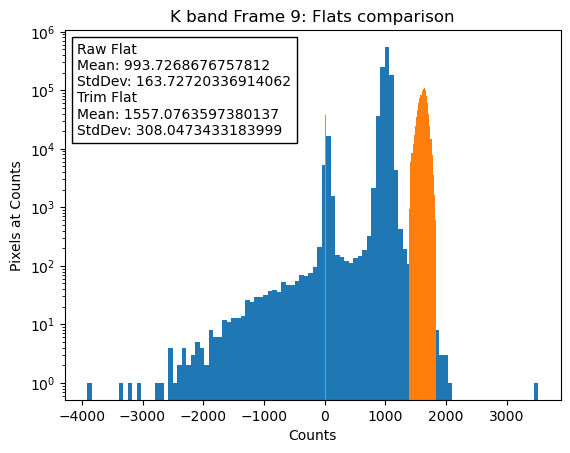

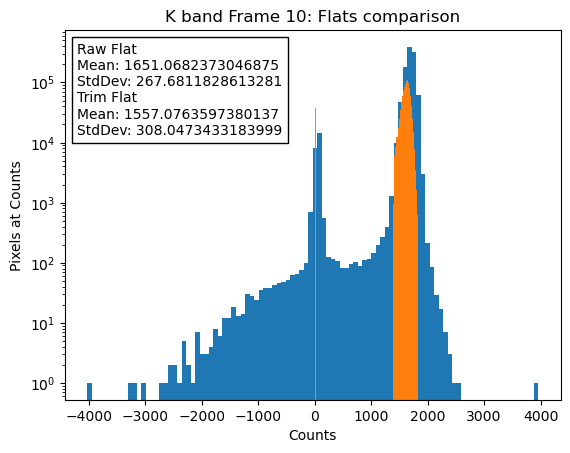

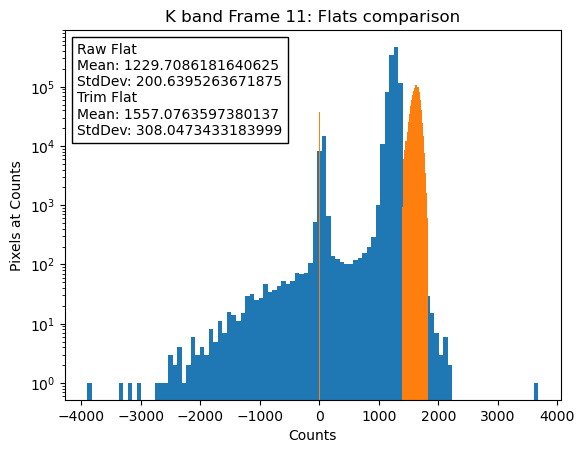

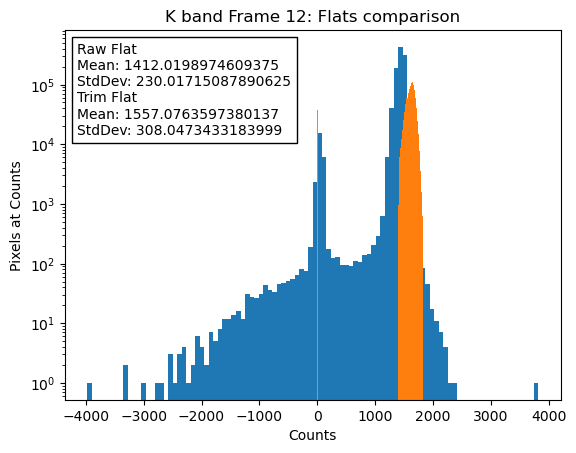

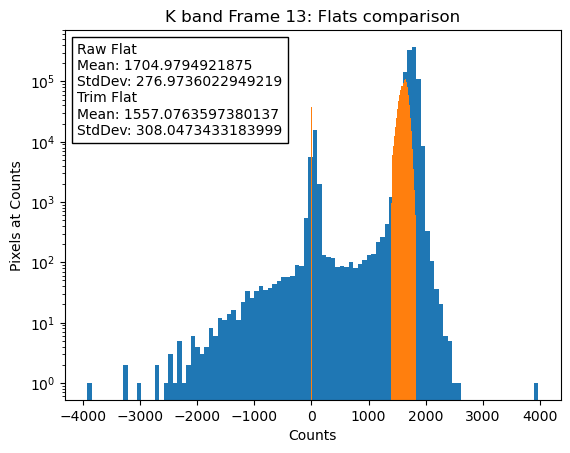

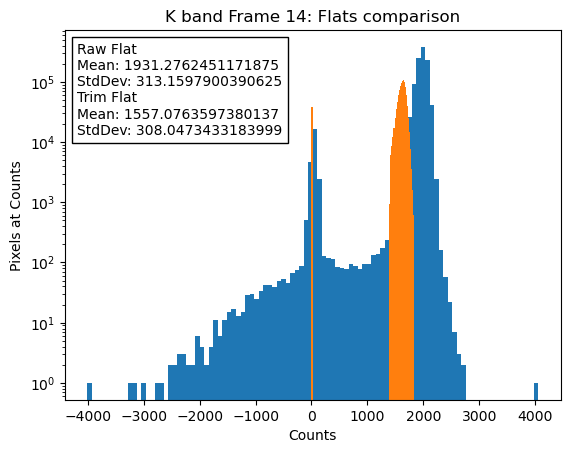

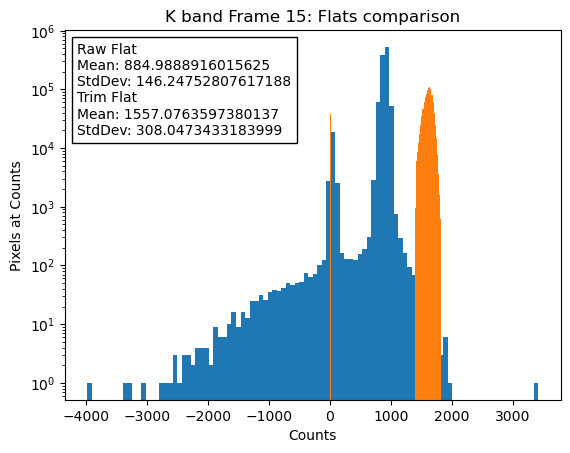

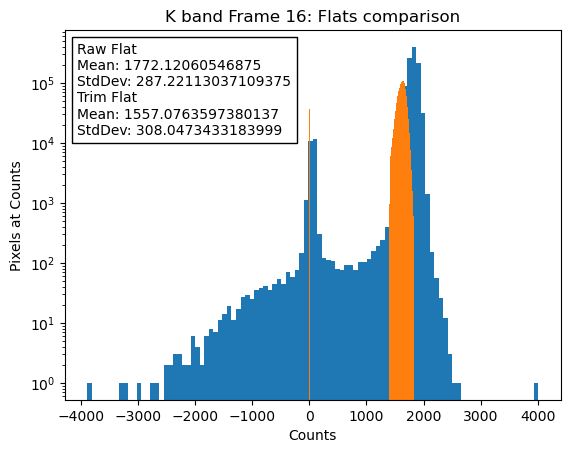

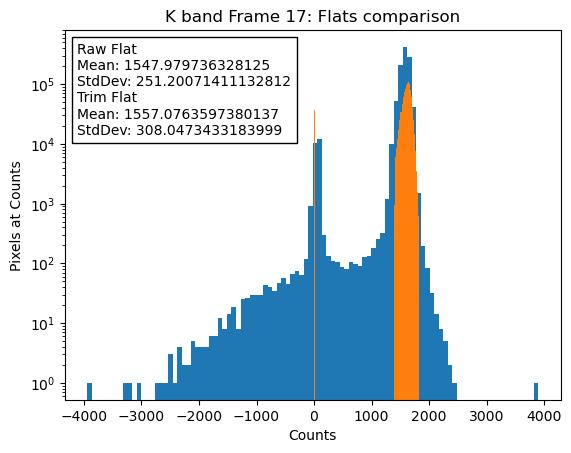

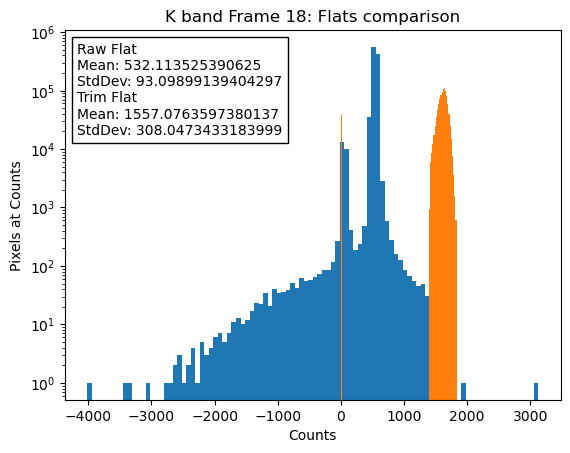

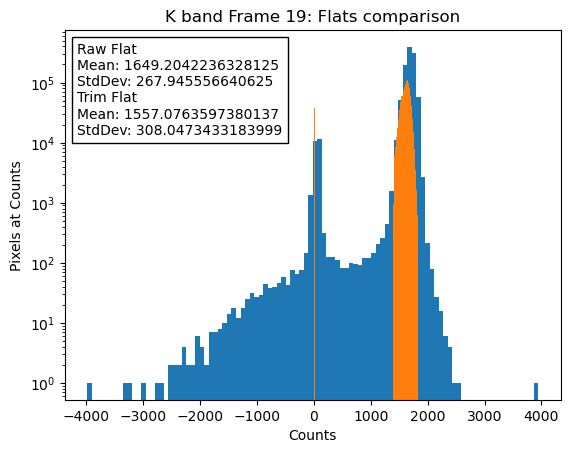

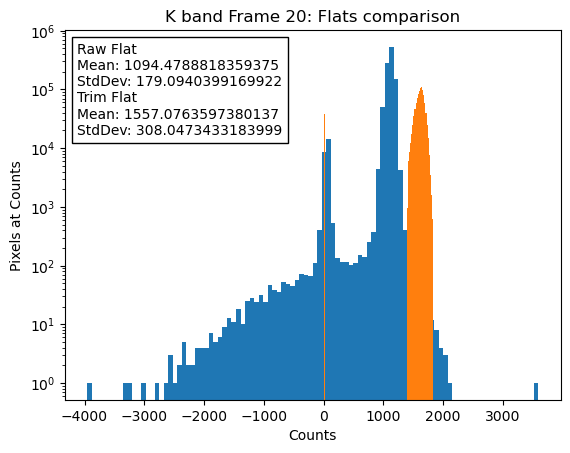

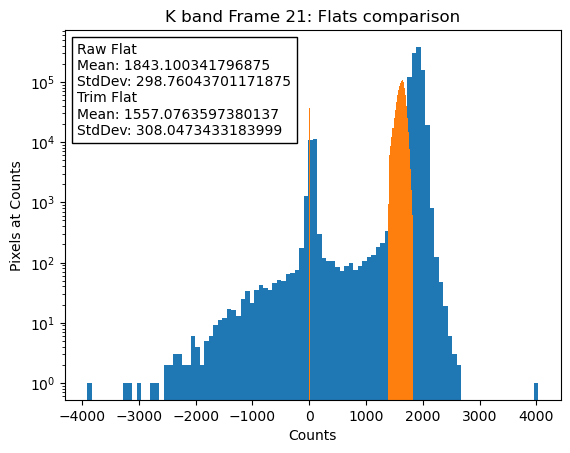

In [113]:
bands = ['H', 'J', 'K']
for band in bands:
    print(band)
    for index, file in enumerate(filedict[band]["flats"]):
        fig, ax = plt.subplots()
        raw_flat = open_fits(file)
        trim_flat = sigma_mask(masterdict[band]["flats"][1])[3]
        ax.hist(np.ndarray.flatten(raw_flat), bins=100)
        ax.hist(np.ndarray.flatten(trim_flat), bins=100)
        text_string = f"Raw Flat\nMean: {np.mean(np.ndarray.flatten(raw_flat))}\nStdDev: {np.std(np.ndarray.flatten(raw_flat))}\n"
        text_string += f"Trim Flat\nMean: {np.mean(np.ndarray.flatten(trim_flat))}\nStdDev: {np.std(np.ndarray.flatten(trim_flat))}"
        anchored_text = AnchoredText(text_string, loc=2)
        ax.add_artist(anchored_text)
        ax.set_yscale("log")
        ax.set_xlabel("Counts")
        ax.set_ylabel("Pixels at Counts")
        ax.set_title(f"{band} band Frame {index}: Flats comparison")
        plt.show()

The shift in mean and standard deviation is not as prevalent in the flats as they were in the darks frame comparisons in the cell above. We note that most frames that we obtained are bimodal with two distinct peaks. When opened in ds9, the flat images tended to have notable smears/streaks on them which is a potential explanation for the two peaks that are seen within this image, a peak at 0 corresponding to the cleaner parts of the frame with no smearing and a peak in the mid 1000s which corresponds to the values of the smears. This also makes it clear of as to why the sigma cutting is not as effective in these frames since the two peaks presents an interesting conflict since we used a pixel rejection technique which assumes a sole, uniform peak.

Thankfully, of the two peaks, one is clearly the dominant one and is where the pixels are being determined from so our issue is not too apparent, but it would be interesting to consider other ways in which pixel rejection strategies could be applied to compensate for this. Pixels that were eliminated were those that were 3 sigma away from the mean.

Histogram Comparison (Science) Pre and Post Sky Correction

H


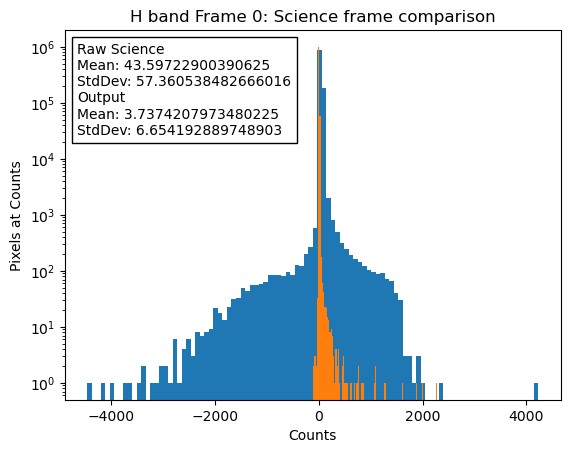

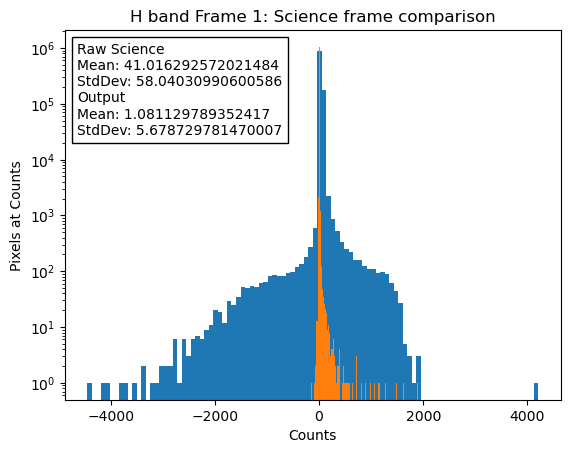

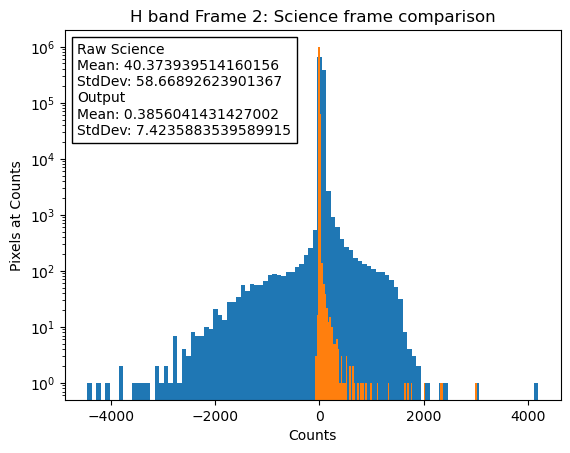

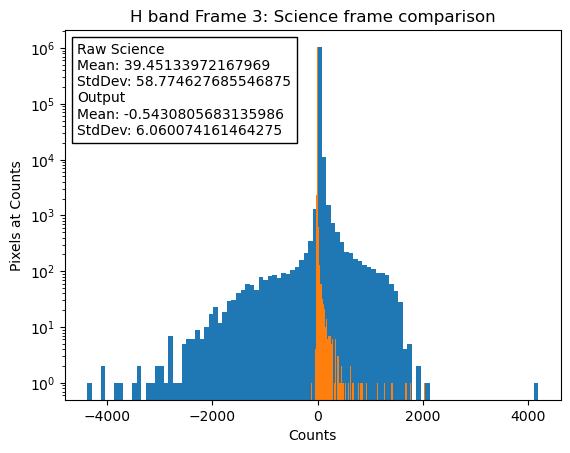

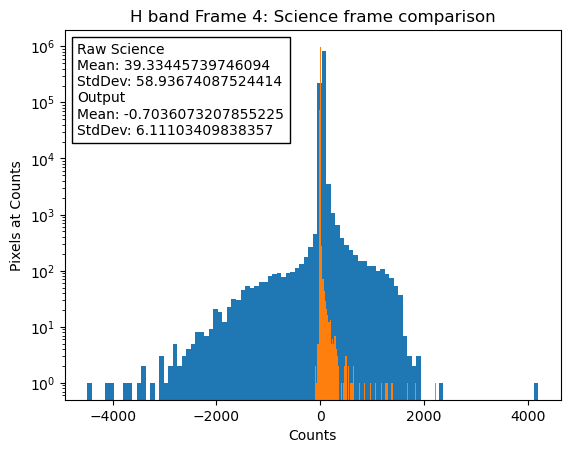

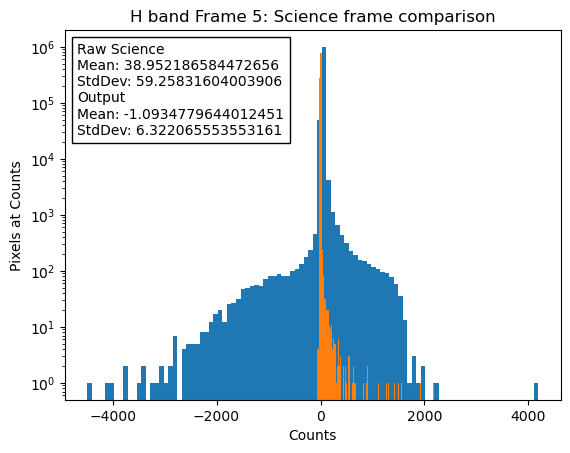

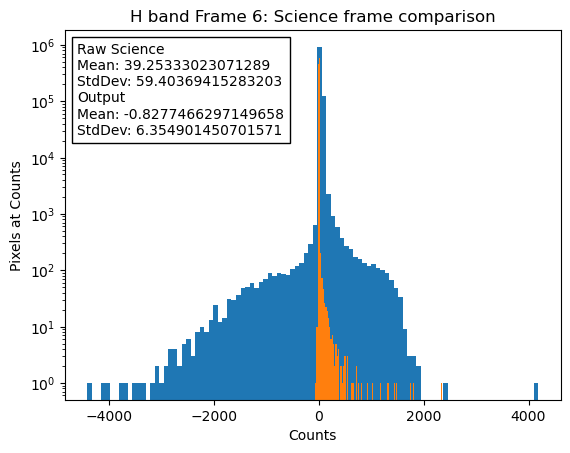

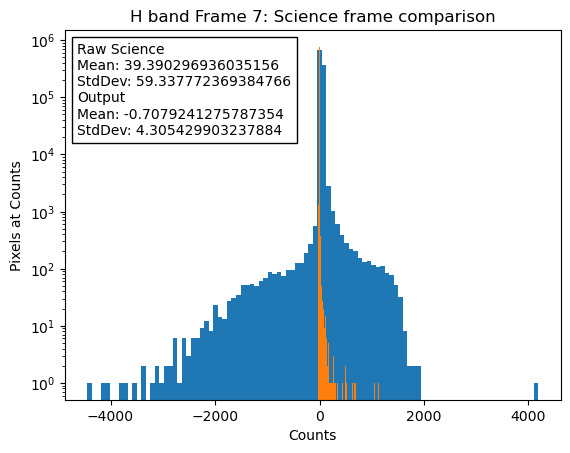

J


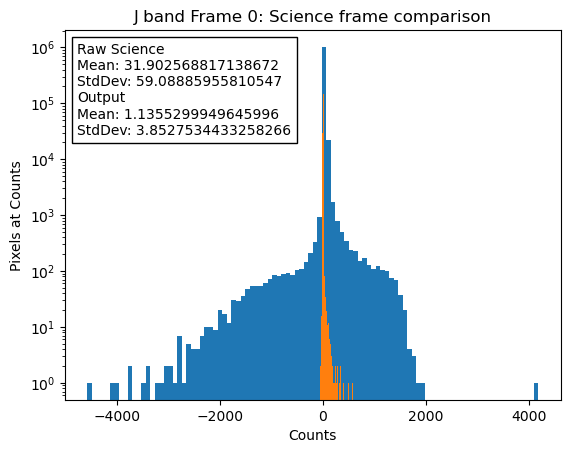

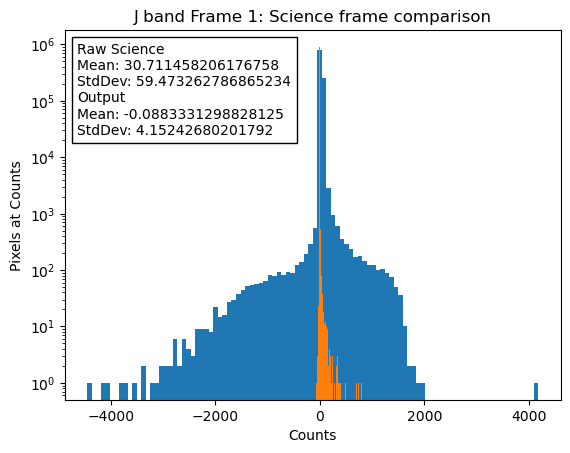

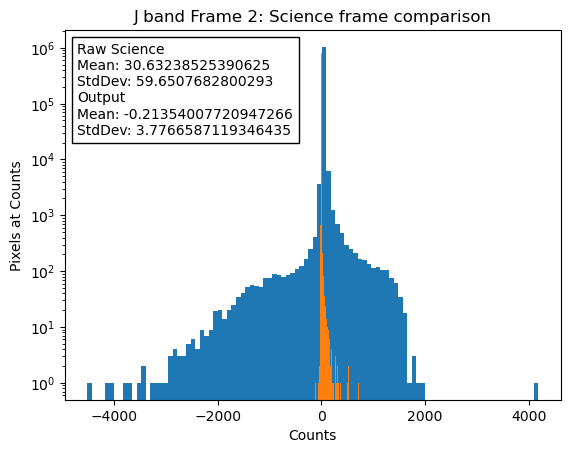

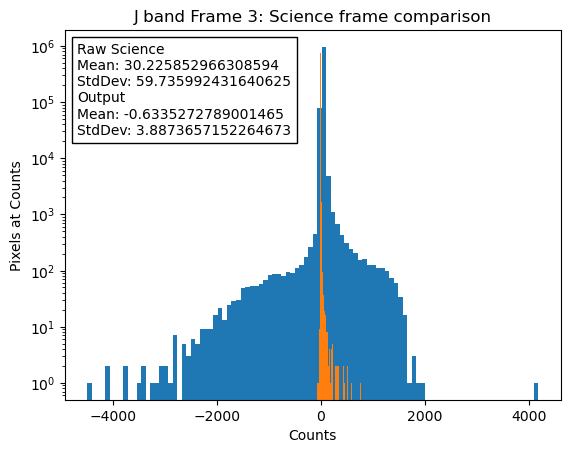

K


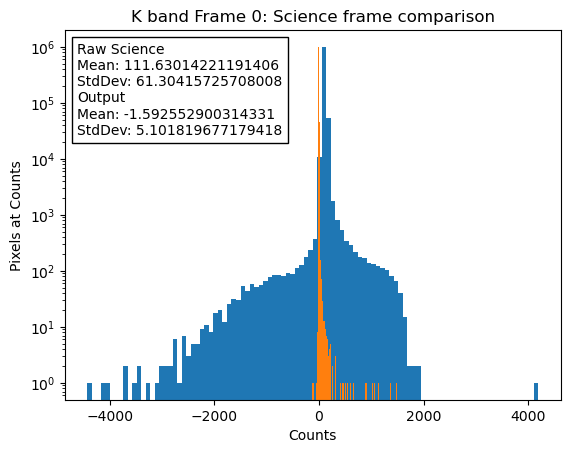

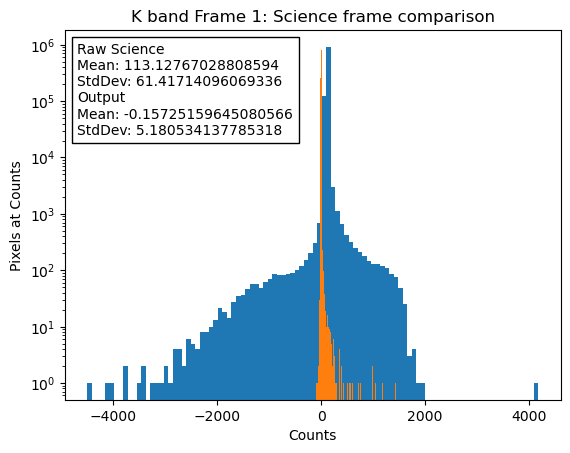

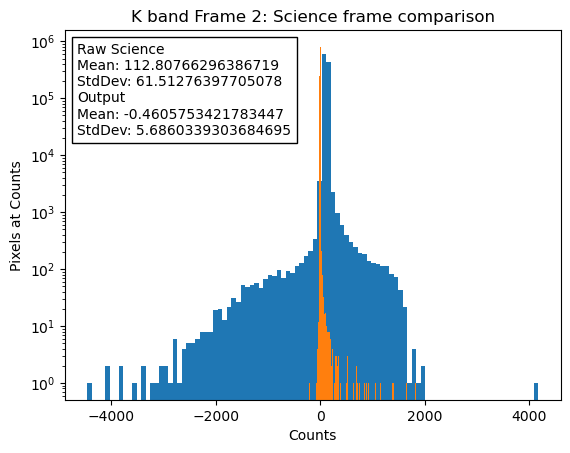

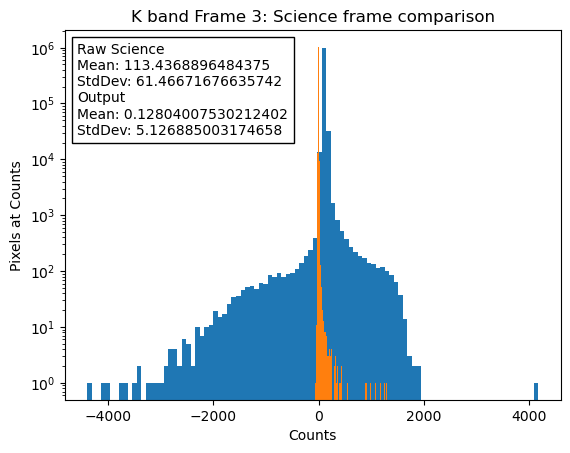

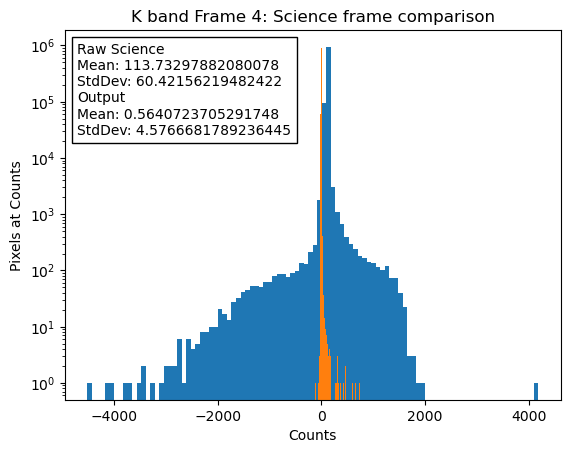

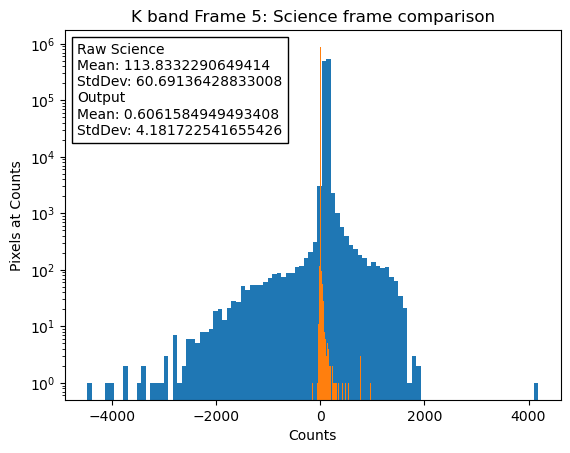

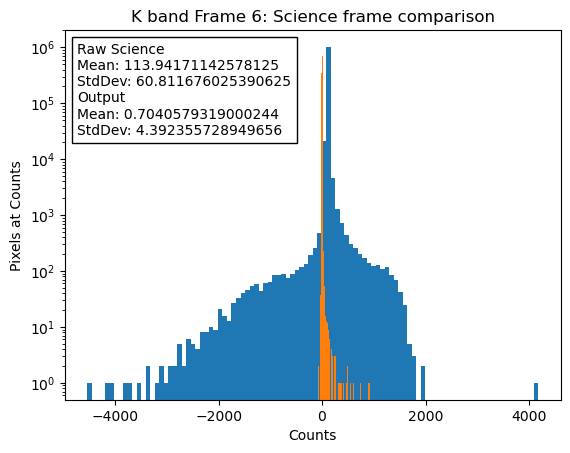

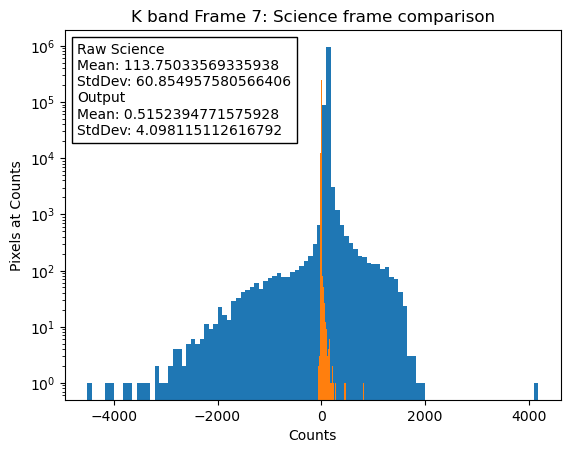

In [114]:
bands = ['H', 'J', 'K']
for band in bands:
    print(band)
    path_input = './2M1207_bands/' + band + 'band/'
    path_output = path_input + 'out/'
    filelist_out = sorted(glob.glob(path_output+'*.fits'))
    for index, file in enumerate(filedict[band]["sci"]):
        fig, ax = plt.subplots()
        raw_sci = open_fits(file)
        post_sci = open_fits(filelist_out[index])
        ax.hist(np.ndarray.flatten(raw_sci), bins=100)
        ax.hist(np.ndarray.flatten(post_sci), bins=100)
        text_string = f"Raw Science\nMean: {np.mean(np.ndarray.flatten(raw_sci))}\nStdDev: {np.std(np.ndarray.flatten(raw_sci))}\n"
        text_string += f"Output\nMean: {np.mean(np.ndarray.flatten(post_sci))}\nStdDev: {np.std(np.ndarray.flatten(post_sci))}"
        anchored_text = AnchoredText(text_string, loc=2)
        ax.add_artist(anchored_text)
        ax.set_yscale("log")
        ax.set_xlabel("Counts")
        ax.set_ylabel("Pixels at Counts")
        ax.set_title(f"{band} band Frame {index}: Science frame comparison")
        plt.show()

I've also realised that I neglected to show what the hot and cold pixel maps look like during the intermediate steps of the data reduction process. Below is an example for how these maps were calculated for the 'H' band.

/var/folders/sj/wxtxl35d5pl6ht44_743jjv80000gn/T/ipykernel_5576/4077649199.py:5: RuntimeWarning: invalid value encountered in divide
  bad_mask = np.zeros((1024, 1024)) + bad_pixels/bad_pixels


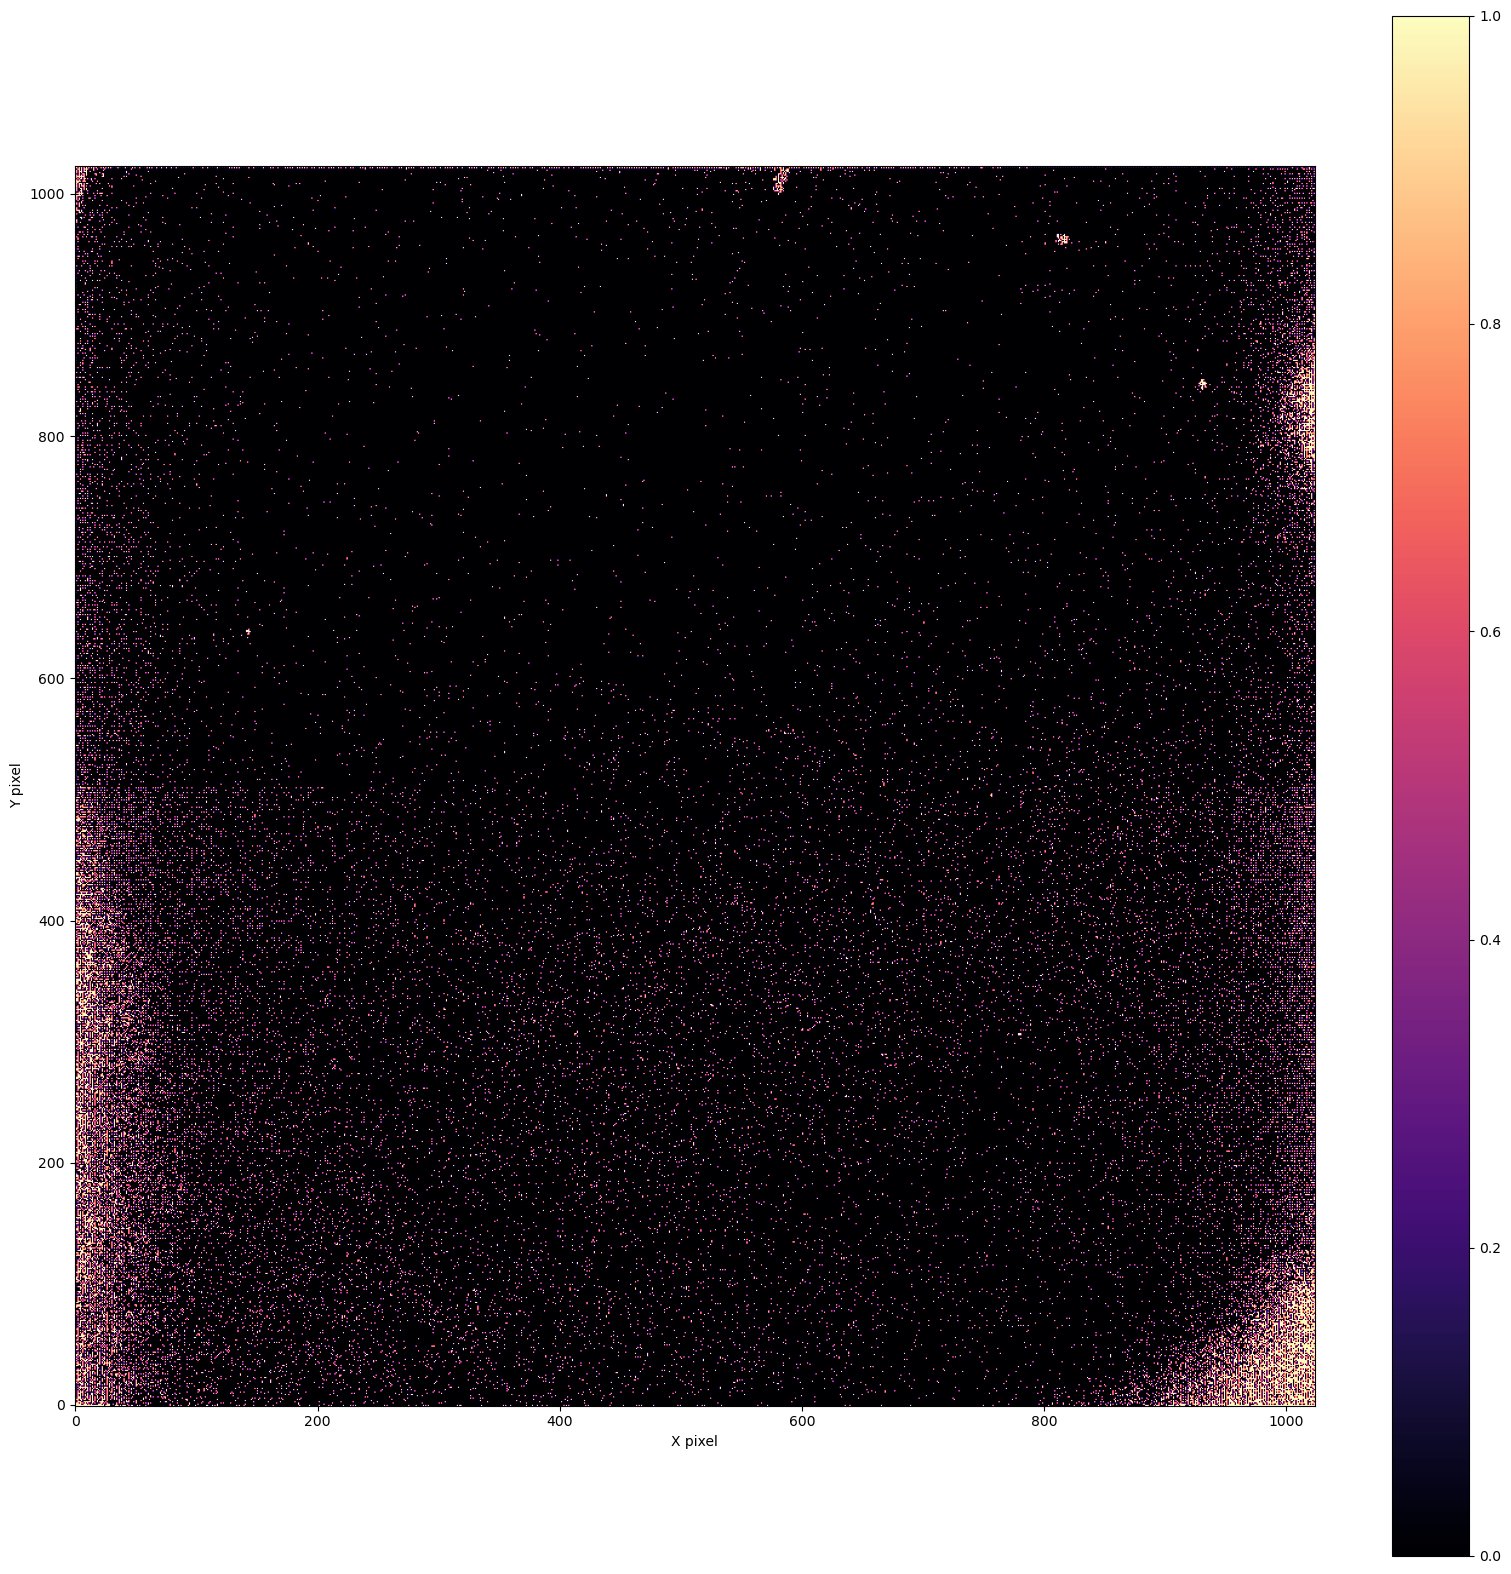

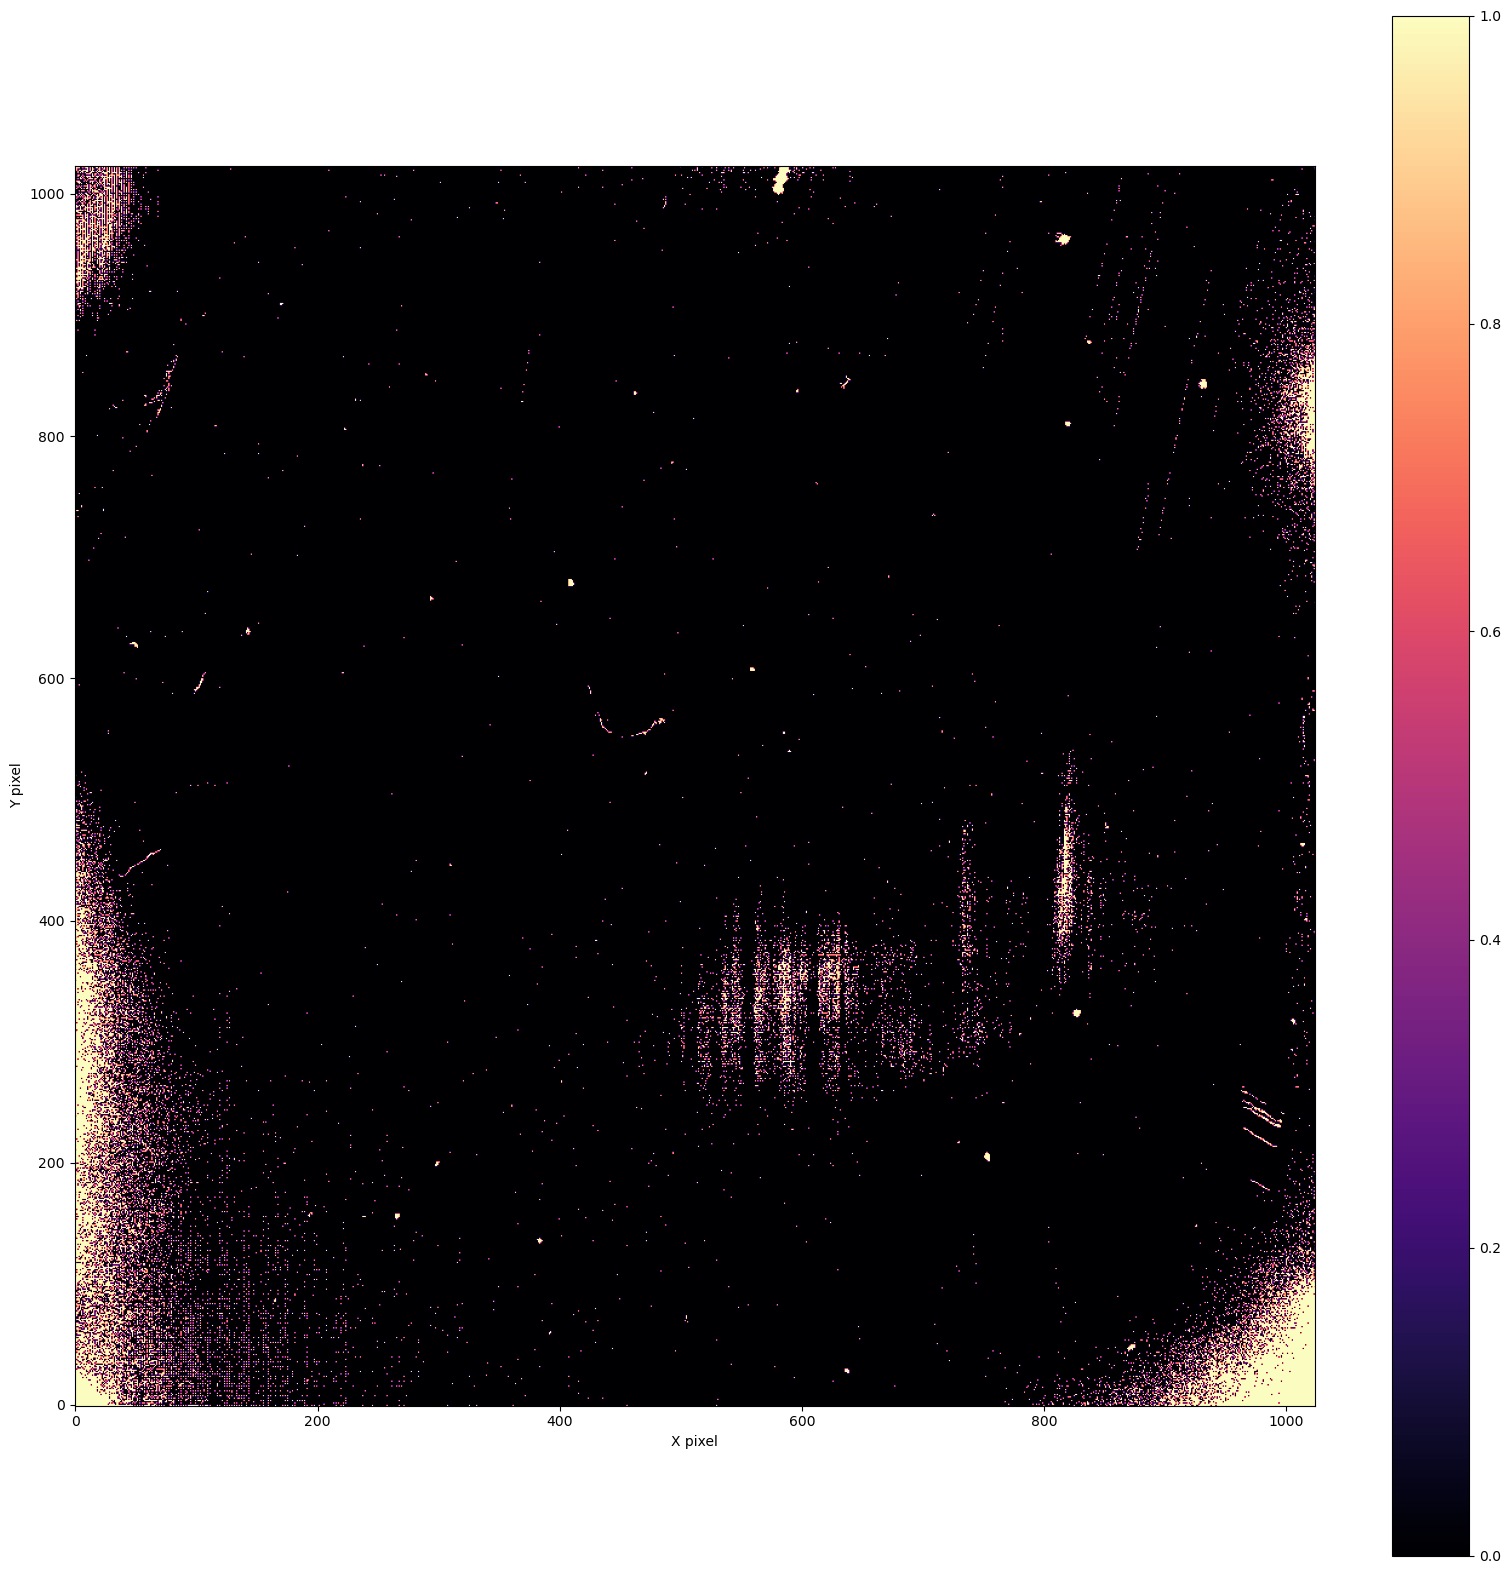

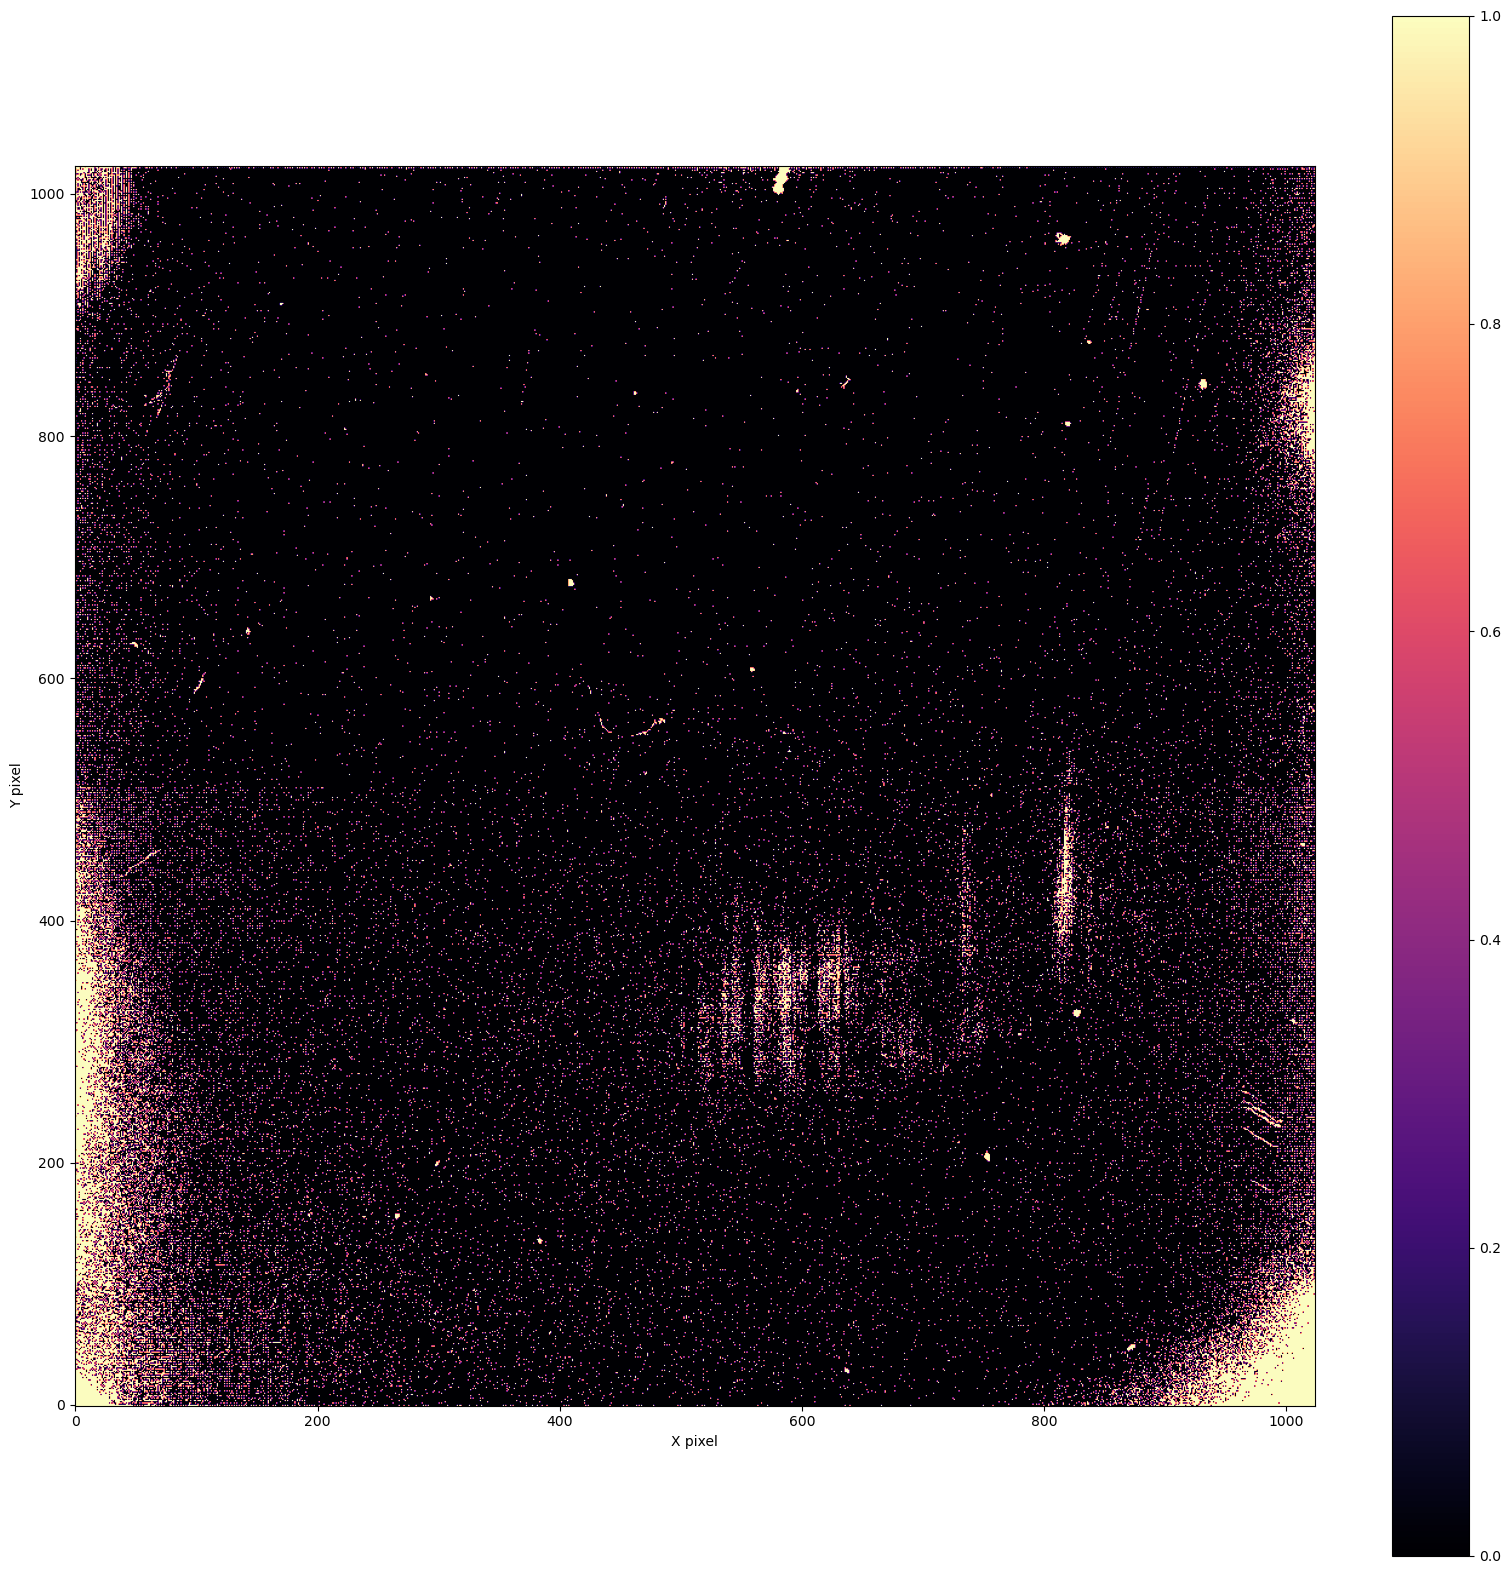

In [118]:
hot_pixels = sigma_mask(masterdict['H']["darks"][1])[0]
cold_pixels = sigma_mask(masterdict['H']["flats"][1])[0]
bad_pixels = hot_pixels + cold_pixels
# From our hot pixels map, we can create a mask so that we can eliminate any flagged pixels for ommision.
bad_mask = np.zeros((1024, 1024)) + bad_pixels/bad_pixels
plot_whole_image(hot_pixels, vmin=0,vmax=1)
plot_whole_image(cold_pixels, vmin=0, vmax=1)
plot_whole_image(bad_pixels, vmin=0, vmax=1)

# Discussion (Part 1)

It appears that our data reduction steps for the science images dramatically reduced the background noise from the sky as expected. Pixels that were eliminated were those that were 3 sigma away from the mean. The mean value of the pixels are 0, which is a desirable trait to have as it implies that the values that are remaining in the image are that of objects of interest. We note that on the processed science images, we have a distinct tail present within our histogram which is not as well defined in the raw science image. This is a reflection of the pixels associated with our star, another indicator that our object is now much more distinct in our image and that the SNR is higher.

It is also worth noting that this tail is quite prevalent in all of our processed frames, but slightly less significant within the J-band frames. This is inline with our magnitude estimates during the photometry portion of this lab, where we found that we achieved higher magnitude estimates for the exoplanet in the J-band images. Clearly, the removal of the flats and darks is significant for the removal of artifacts which may appear in your science images. Artifacts such as vignetting, dust spots, are ones that can be corrected for by applying the correct data reduction procedures. Artifacts from the CCD are taken care of by the application of data reduction techniques using the dark frames taken. Removing the sky background from your science images is also extremely important as it removes all of the noise taken in by sources that are not yours (assuming your source is moving around in different observations). These are not effects that are instrinsic to your telescope, so removing the sky background is a critical step that must be completed.

All of these corrections can be accompanied by applying a sigma cut to the master of each image (the combined image), which removes pixels which may be oversaturated or undersaturated for any number of regions. This has the added benefit of improving data analysis down the road when conducting analysis such as photometry.

# Discussion (Part 2)

Now that part 2 has been completed, it is clear that the efforts taken in part 1 were quite significant. Conducting photometry on the exoplanet to determine its flux hinges on the ability for the exoplanet to be resolved so that a correct aperture may be applied. Furthermore, proper data reduction increases the SNR of the objects that we care about as a whole, meaning that contrast is improved with better data reduction. Following this train of thought, a coronograph would have been quite useful for imaging this exoplanet since the reduction in starlight would give a better indication of the exoplanet flux. It is not unreasonable to expect that some starlight may have spilled into the exoplanet aperture and caused a shift in its measured flux.

Following the photometry of the part 2 and the data reduction of part 1, it seems that were able to replicate the results of Chauvin et al, (2004) since were able to resolve our exoplanet in at least two bands, being able to calculate a set of flux values for the two wavelengths corresponding to the bands we found the exoplanet within. I was however unable to verify if the flux values we found were comparable to those of the paper given that the SED plots provided referenced a normalized flux value, and only for the H-band.

# Conclusion

Following our data reduction procedure, we were able to increase the SNR of our science frames to directly image the exoplanet around our star for the H and K bands. We were not as lucky with being able to resolve the exoplanet within the J band and L band. We found the J band data to be perfectly servicable for the photometry on the source star but were unable to achieve enough contrast on the exoplanet to directly image it. We were unable to use the L band data as we were unable to properly resolve the source star itself.

We also conducted photometry on the exoplanet in the H and K bands and found the exoplanet to have flux values of 8.069e-17 W/m^2/micron and 5.555e-17 W/m^2/micron respectively.